Пусть X - матрица объектов $\in R^{l\times d}$, $w$ - вектор весов $\in R^d$. Логистическая регрессия оптимизирует функционал $Q(X, w) = \frac{1}{l}\sum_{i=1}^{l} \log(1+e^{-y_i<x_i, w>}) = \frac{1}{l}(logaddexp(0, -(X @ w) * y_i)).sum()$  
$\nabla Q(X, w) = \frac{1}{l}\sum_{i=1}^{l}-\frac{y_i e^{-y_i*<x_i, w>}}{1+e^{-y_i*<x_i, w>}}x_i =
-\frac{1}{l} X^T @ (scipy.special.expit(-X @ w*y) * y),$ где $*$ - это поэлементное умножение векторов, а $@$ - произведение матриц (матрицы и вектора).  
Буду оптимизировать функционал градиентным и стохастическим градиентным спусками.  
В итоге хочу протестировать мою реализацию логистичсекой регрессии на датасете вот этого чоревнования https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge, применяя Bag of Words и TF-IDF для выведеления численных признаков из текста, поэтому алгоритм умеет работать со sparse-матрицами (именно такие матрицы часто получаются на выходе Bag of Words и TF-IDF). Также добавил возможность l2-регуляризации.

Формула градиентного спуска.  
$w^{k+1} = w^k - \frac{1}{l}\sum_{i=1}^{l}-\frac{y_i e^{-y_i*<x_i, w>}}{1+e^{-y_i*<x_i, w>}}x_i = =
-\frac{1}{l} X^T @ (scipy.special.expit(-X @ w*y) * y)$  
  
Формула стохастического градиентного спуска.  
Для каждой эпохи фиксирую перестановку на X. И последовательно беру по batch_size строк из этой перестановки (в последню пачку может попасть < batch_size строк. Так на кадом шаге получаю некоторую подвыборку $X_{trunc}$ из $s$ (= batch_size) элементов.  
$w^{k+1} = w^k - \frac{1}{s}\sum_{i=1}^{s}-\frac{y_i e^{-y_i*<x_i, w>}}{1+e^{-y_i*<x_i, w>}}x_i = =
-\frac{1}{l} X_{trunc}^T @ (scipy.special.expit(-X_{trunc} @ w*y) * y)$  


In [2]:
import time
import numpy as np
import scipy
from scipy.special import expit
import scipy.sparse as sparse
from numpy.linalg import norm
import math


class GDClassifier:
    """
    Класс логистической регрессии, обучающийся обычным градиентным спуском
    Выбор шага происходит следующим образом:
    step = step_alpha / k^step_beta, где k - номер шага
    """
    def __init__(self, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, l2_coef=0.0, **kwargs):
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.l2_coef = l2_coef
        self.history = {'time': [], 'func': []}
        self.w = None
        """
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Критерий остановки: |f(x_{k+1}) - f(x_{k})| < tolerance
        l2_coef - коэффициент l2-регуляризации
        max_iter - максимальное число итераций       
        """

    #значение Loss-функции
    def func(self, X, y, w):
        if sparse.issparse(X):
            return np.logaddexp(np.zeros(X.shape[0]), 
                                  - (X.dot(w) * y)).sum() / X.shape[0] + self.l2_coef * 0.5 * norm(w) ** 2
        else:
            return np.logaddexp(np.zeros(X.shape[0]), 
                                  - np.dot(X, w) * y).sum() / X.shape[0] + self.l2_coef * 0.5 * norm(w) ** 2
    
    #градиент Loss-функции
    def grad(self, X, y, w):
        if sparse.issparse(X):
            return - (X.T).dot(expit(- X.dot(w) * y) * y) / X.shape[0] + self.l2_coef * w
        else:
            return - np.dot(X.T, expit(- np.dot(X, w) * y) * y) / X.shape[0] + self.l2_coef * w
        
    #метод fit - минимизация функционала градиентным спуском
    """
    Обучение метода по выборке X с ответами y
    X - scipy.sparse.csr_matrix или двумерный numpy.array
    y - одномерный numpy array
    w_0 - начальное приближение в методе
    """
       
    def fit(self, X, y, w_0=None, trace=False):
        previous_time = time.monotonic()
        self.history = {'time': [], 'func': []}
        if w_0 is None:
            w_0 = np.zeros(X.shape[1])
        self.history['time'].append(0)
        self.history['func'].append(self.func(X, y, w_0))
        
        self.w = w_0 - self.step_alpha * self.grad(X, y, w_0)
        self.history['func'].append(self.func(X, y, self.w))
        self.history['time'].append(time.monotonic() - previous_time)
        previous_time = time.monotonic()
        if abs(self.history['func'][1] - self.history['func'][0]) < self.tolerance:
            if trace == True:
                return self.history
            else:
                return
        else:
            for k in range(2, self.max_iter+1):
                #у нас уже была сделана 1 итерация вне цикла + в цикле будет от 2 до 1000 включительно,
                #т.е. итого 1+999 итераций
                self.w = self.w - (self.step_alpha / (k ** self.step_beta)) * self.grad(X, y, self.w)
                self.history['func'].append(self.func(X, y, self.w))
                self.history['time'].append(time.monotonic() - previous_time)
                previous_time = time.monotonic()
                if abs(self.history['func'][k] - self.history['func'][k-1]) < self.tolerance:
                    break
            if trace == True:
                return self.history
            else:
                return            
    #получение меток ответов на выборке X      
    def predict(self, X):
        if sparse.issparse(X):
            R = np.sign(X.dot(self.w))
            R[R == 0.] = 1
            return R
        else:
            R = np.sign(np.dot(X, self.w))
            R[R == 0.] = 1
            return R
    #метод predict_proba
    def predict_proba(self, X):
        if sparse.issparse(X):
            a = ((1 + np.exp(- X.dot(self.w))) ** -1).reshape(X.shape[0], 1)
            b = ((1 + np.exp(X.dot(self.w))) ** -1).reshape(X.shape[0], 1)
            return np.hstack((b, a))
        else:
            a = ((1 + np.exp(np.dot(- X, self.w))) ** -1).reshape(X.shape[0], 1)
            b = ((1 + np.exp(np.dot(X, self.w))) ** -1).reshape(X.shape[0], 1)
            return np.hstack((b, a))

    #методы, которые можно вызывать после обучения и получения значения self.w    
    def get_objective(self, X, y):
        return self.func(X, y, self.w)
        
    def get_gradient(self, X, y):
        return self.grad(X, y, self.w)
    
    def get_weights(self):
        return self.w


class SGDClassifier(GDClassifier):
    """
    Класс стохастического градиентного спуска
    batch_size - размер подвыборки, по которой считается градиент
    """
    
    def __init__(self, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, l2_coef=0.0, **kwargs):
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.l2_coef = l2_coef
        self.history = {'epoch_num': [], 'time': [], 'func': [], 'weights_diff': []}
        self.w = None
        
    def fit(self, X, y, w_0=None, trace=False, log_freq=1.0):
        np.random.seed(self.random_seed)
        previous_time = time.monotonic()
        if w_0 is None:
            w_0 = np.zeros(X.shape[1])
        self.w = w_0
        previous_weight = self.w
        self.history = {'epoch_num': [], 'time': [], 'func': [], 'weights': [], 'weights_diff': []}
        self.history['epoch_num'].append(0)
        self.history['time'].append(0)
        self.history['func'].append(self.func(X, y, w_0))
        self.history['weights_diff'].append(norm(w_0) ** 2)
        self.history['weights'].append(w_0)
        epoch_number = 0
        
        for k in range(1, self.max_iter+1):
            s = np.arange(X.shape[0])
            np.random.shuffle(s)
            iter_numbers = math.ceil(X.shape[0] / self.batch_size)
            for i in range(iter_numbers):
                #это работает с csr_matrix тоже
                X_trunc = X[s[i*self.batch_size:(i+1)*self.batch_size]]
                y_trunc = y[s[i*self.batch_size:(i+1)*self.batch_size]]
                self.w = self.w - (self.step_alpha / (k ** self.step_beta)) * self.grad(X_trunc, y_trunc, self.w)
                epoch_number += X_trunc.shape[0]
                if epoch_number / X.shape[0] - self.history['epoch_num'][-1] >= log_freq:
                    self.history['epoch_num'].append(epoch_number / X.shape[0])
                    self.history['time'].append(time.monotonic() - previous_time)
                    previous_time = time.monotonic()
                    self.history['func'].append(self.func(X, y, self.w))
                    self.history['weights_diff'].append(norm(self.w - previous_weight) ** 2)
                    self.history['weights'].append(self.w)
                    previous_weight = self.w
                    if abs(self.history['func'][-1] - self.history['func'][-2]) < self.tolerance:
                        break
            #это относится к циклу по "k" 
            if (len(self.history['func']) >= 2 and
                   abs(self.history['func'][-1] - self.history['func'][-2]) < self.tolerance):
                break
        if trace == True:
            return self.history
        else:
            return

Проверка работоспособности алгоритмов на make_blobs

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

np.random.seed(119)
#создаю выборку
sample_size = 1500
X, y = make_blobs(sample_size, centers=2)
X = np.hstack((X, np.ones((X.shape[0], 1))))
y = (y - 0.5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Accuracy: 1.0
fit time: 0.011745235000489629


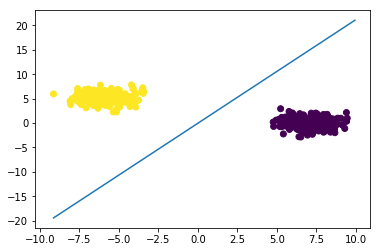

In [4]:
#обучаю классификатор стохастическим градиентным спуском
oracle = SGDClassifier(batch_size=50, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
start = time.monotonic()
res = oracle.fit(X_train, y_train, trace=True)
finish = time.monotonic()
weights = oracle.get_weights()
#делаю предсказания
pred = oracle.predict(X_test)
accuracy = (pred == y_test).sum() / y_test.shape[0]
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
plt.plot(x, - (1 / weights[1]) * (weights[0] * x + weights[2]))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.show()

Accuracy: 1.0
fit time: 0.000994983000055072


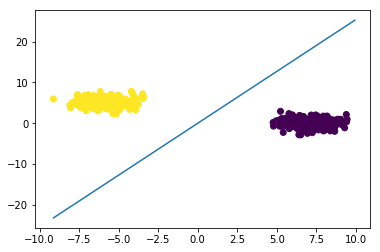

In [5]:
old_oracle = GDClassifier(step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, l_2_coef=0.0)
start = time.monotonic()
res = old_oracle.fit(X_train, y_train, trace=True)
finish = time.monotonic()
weights = old_oracle.get_weights()
#делаю предсказания
pred = old_oracle.predict(X_test)
accuracy = (pred == y_test).sum() / y_test.shape[0]
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
plt.plot(x, - (1 / weights[1]) * (weights[0] * x + weights[2]))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.show()

Контест на Kaggle
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Эксперименты.  
Посмотрю на работу GD и SGD при разных параметрах step_alpha, step_beta, batch_size.

$$step = \frac{step_{alpha}}{k^{step_{beta}}},$$ где k - номер итерации






Препроцессинг toxic_train.csv

In [17]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

df = pd.read_csv("toxic_train.csv")
df = df[['Unnamed: 0', 'comment_text', 'is_toxic']]
df.columns = ['id', 'text', 'is_toxic']
df.loc[:, 'is_toxic'] = (df.loc[:, 'is_toxic'].astype('int') - 0.5) * 2
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: x.lower())
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: re.sub('[^а-яёa-z0-9]', ' ', x))
df.head()

id                                               text  is_toxic
0   0  explanation why the edits made under my userna...      -1.0
1   1  d aww  he matches this background colour i m s...      -1.0
2   2  hey man  i m really not trying to edit war  it...      -1.0
3   3    more i can t make any real suggestions on im...      -1.0
4   4  you  sir  are my hero  any chance you remember...      -1.0

Препроцессинг toxic_test.csv

In [18]:
df_test = pd.read_csv("toxic_test.csv")
df_test.head()

df_test = df_test[['Unnamed: 0', 'comment_text', 'is_toxic']]
df_test.columns = ['id', 'text', 'is_toxic']
df_test.loc[:, 'is_toxic'] = (df_test.loc[:, 'is_toxic'].astype('int') - 0.5) * 2
df_test.loc[:, 'text'] = df_test.loc[:, 'text'].apply(lambda x: x.lower())
df_test.loc[:, 'text'] = df_test.loc[:, 'text'].apply(lambda x: re.sub('[^а-яёa-z0-9]', ' ', x))
df_test.head()

id                                               text  is_toxic
0   0  thank you for understanding  i think very high...      -1.0
1   1                    dear god this site is horrible       -1.0
2   2       somebody will invariably try to add relig...      -1.0
3   3       it says it right there that it is a type ...      -1.0
4   4          before adding a new product to the lis...      -1.0

С помощью CountVectorizer() выделяю признаки текстов и добавляю столбец из 1 для возможности сдвига гиперплоскости

In [0]:
vectorizer = CountVectorizer(min_df=0.001)

Train

In [20]:
X_train = vectorizer.fit_transform(df.loc[:, 'text'])
X_train = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_train, np.ones((X_train.shape[0], 1)))))
y_train = df.loc[:, 'is_toxic'].values
X_train, y_train.shape

(<52061x3737 sparse matrix of type '<class 'numpy.float64'>'
 	with 1847494 stored elements in Compressed Sparse Row format>, (52061,))

Test

In [21]:
X_test = vectorizer.transform(df_test.loc[:, 'text'])
X_test = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_test, np.ones((X_test.shape[0], 1)))))
y_test = df_test.loc[:, 'is_toxic'].values
X_test, y_test.shape

(<20676x3737 sparse matrix of type '<class 'numpy.float64'>'
 	with 649028 stored elements in Compressed Sparse Row format>, (20676,))

Буду брать параметр step_alpha из набора [0.01, 0.1, 0.5, 1.0] (при step_alpha > 1 дисперсия значений функционала становится очень большой, это замедляет сходимость и портит читаемость графика).

Из графика ниже видно, что чем меньше step_alpha, тем больше времени требуется для сходимости метода. Причём алгоритм "не успевает" дойти до минимума маленькими шагами и останавливается на больших значениях функционала.   
Это можно понять из нестрогих рассуждений: пусть $step\_alpha_1 = 10step\_alpha_2$, тогда в моменты остановок примерно выполняется $f_1^{'}step\_alpha_1 = f_2^{'}step\_alpha_2 < tolerance$, т.е. $f_1^{'} = 10f_2^{'}$. А это говорит о том, что в момент остановки спуска с меньшим шагом функционал будет меняться в 10 раз сильнее, чем в случае с большим шагом, а это косвенно говорит о том, что спуск с меньшим шагом остановится дальше от оптимума.  
При step_alpha = 1 дисперсия значений большая, но он сходится за 10 секунд почти к самому оптимальному значению среди всех четырёх alpha.

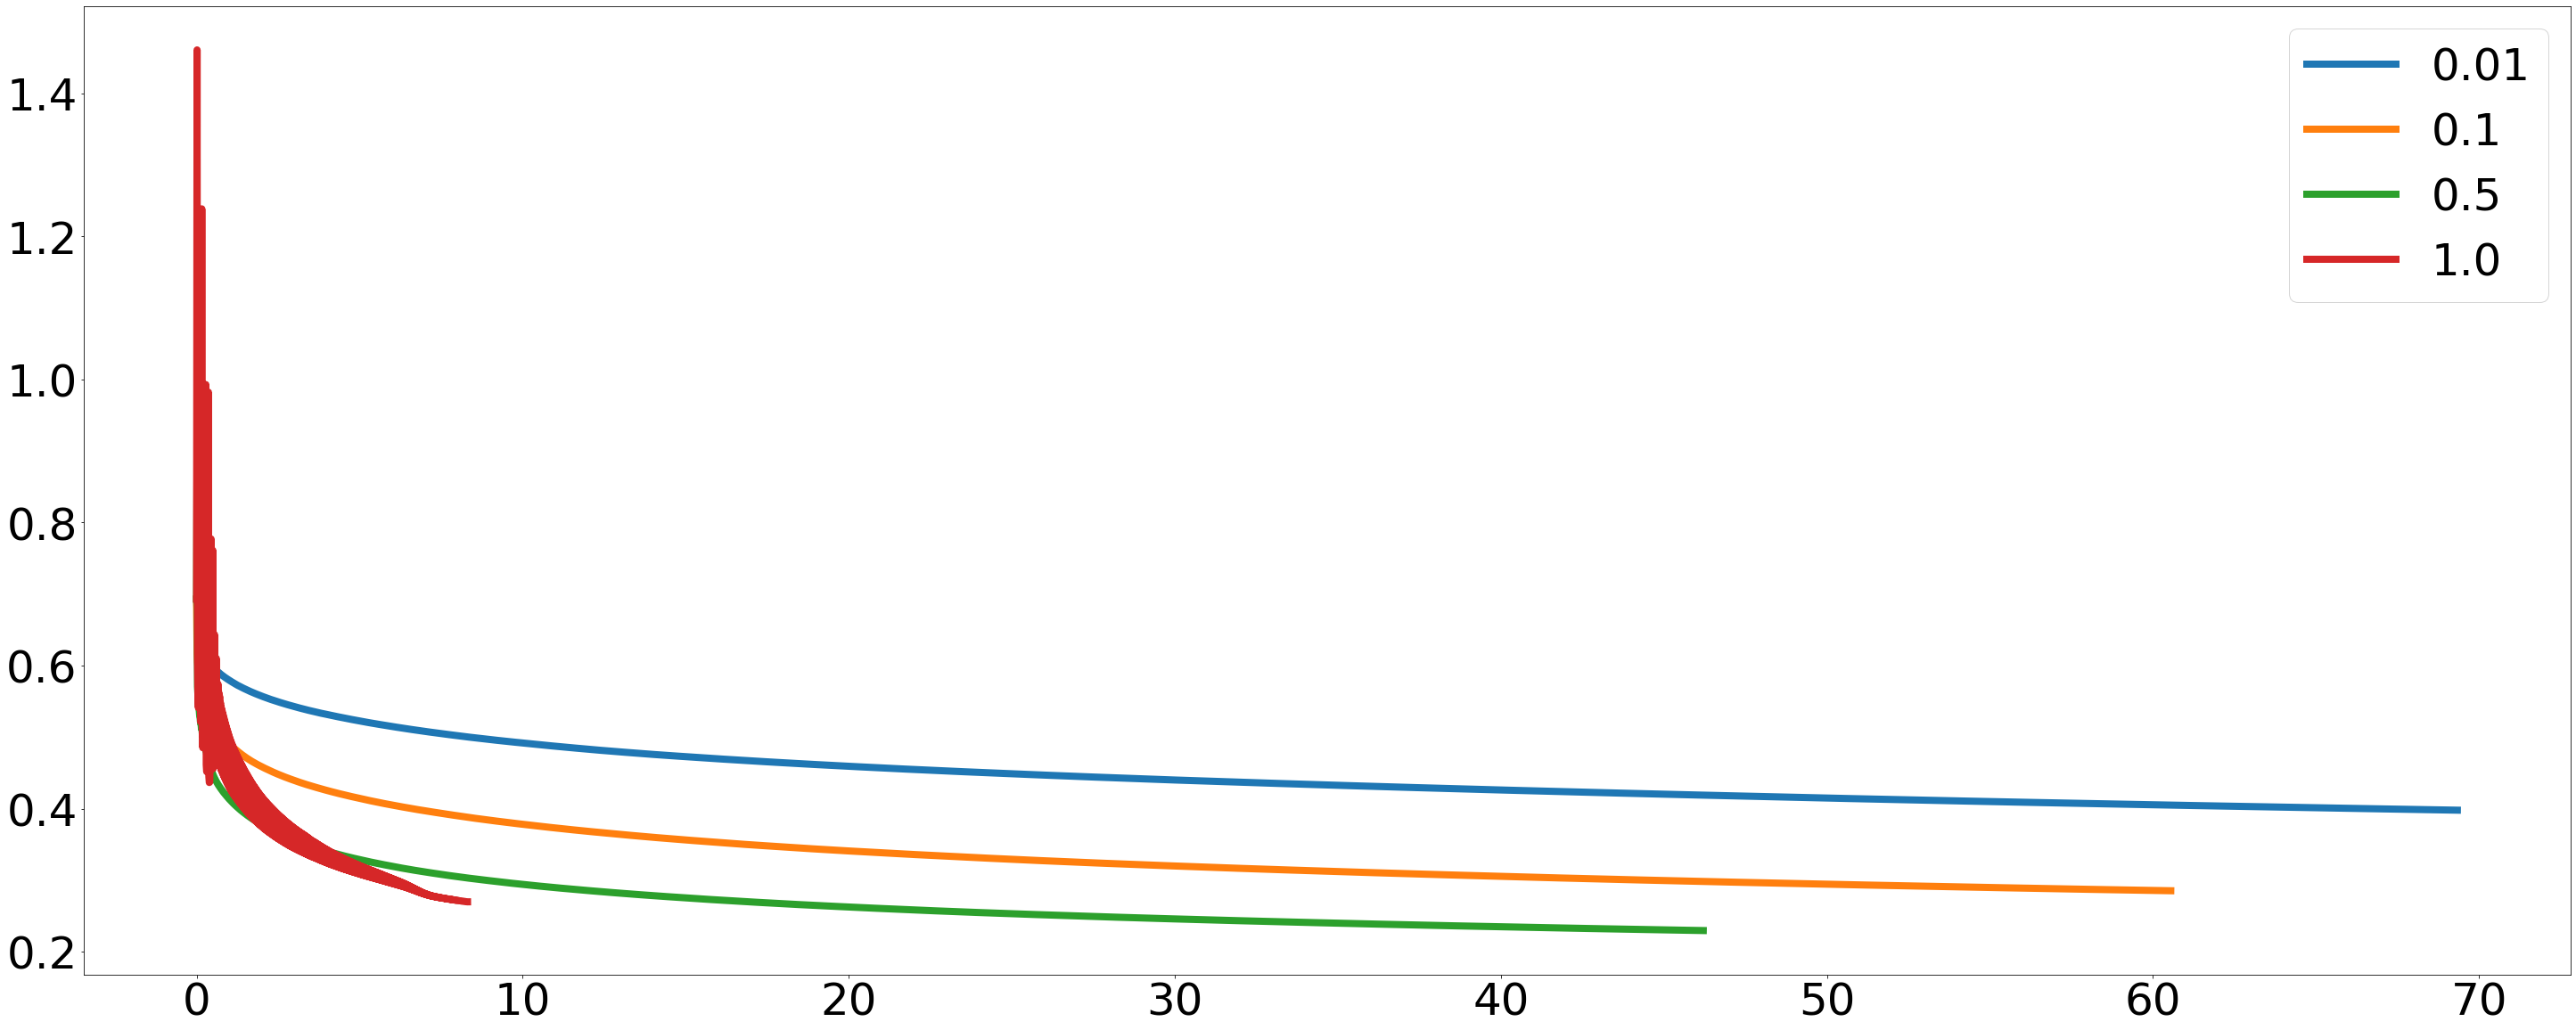

In [22]:
alphas = [0.01, 0.1, 0.5, 1.0]
fig = plt.figure(figsize=(50, 20))
for alpha in alphas:
    oracle = GDClassifier(step_alpha=alpha, step_beta=0.0, 
                 tolerance=1e-5, max_iter=10000, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=alpha)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

График зависимости значения функции потерь от итерации метода

Т.к. время на одну итерацию градиентного спуска примерно совпадает для каждого значения alpha (основная сложность - взятие градиента в точке), то этот график похож на график для времени работы.  
При каждом значении step_alpha методы сошлись, но на разных итерациях. Методу с мешьшим шагом потребовалось больше итераций, чтобы сойтись (сойтись в смысле разности значений функционала, но не в смысле попадения в минимум).

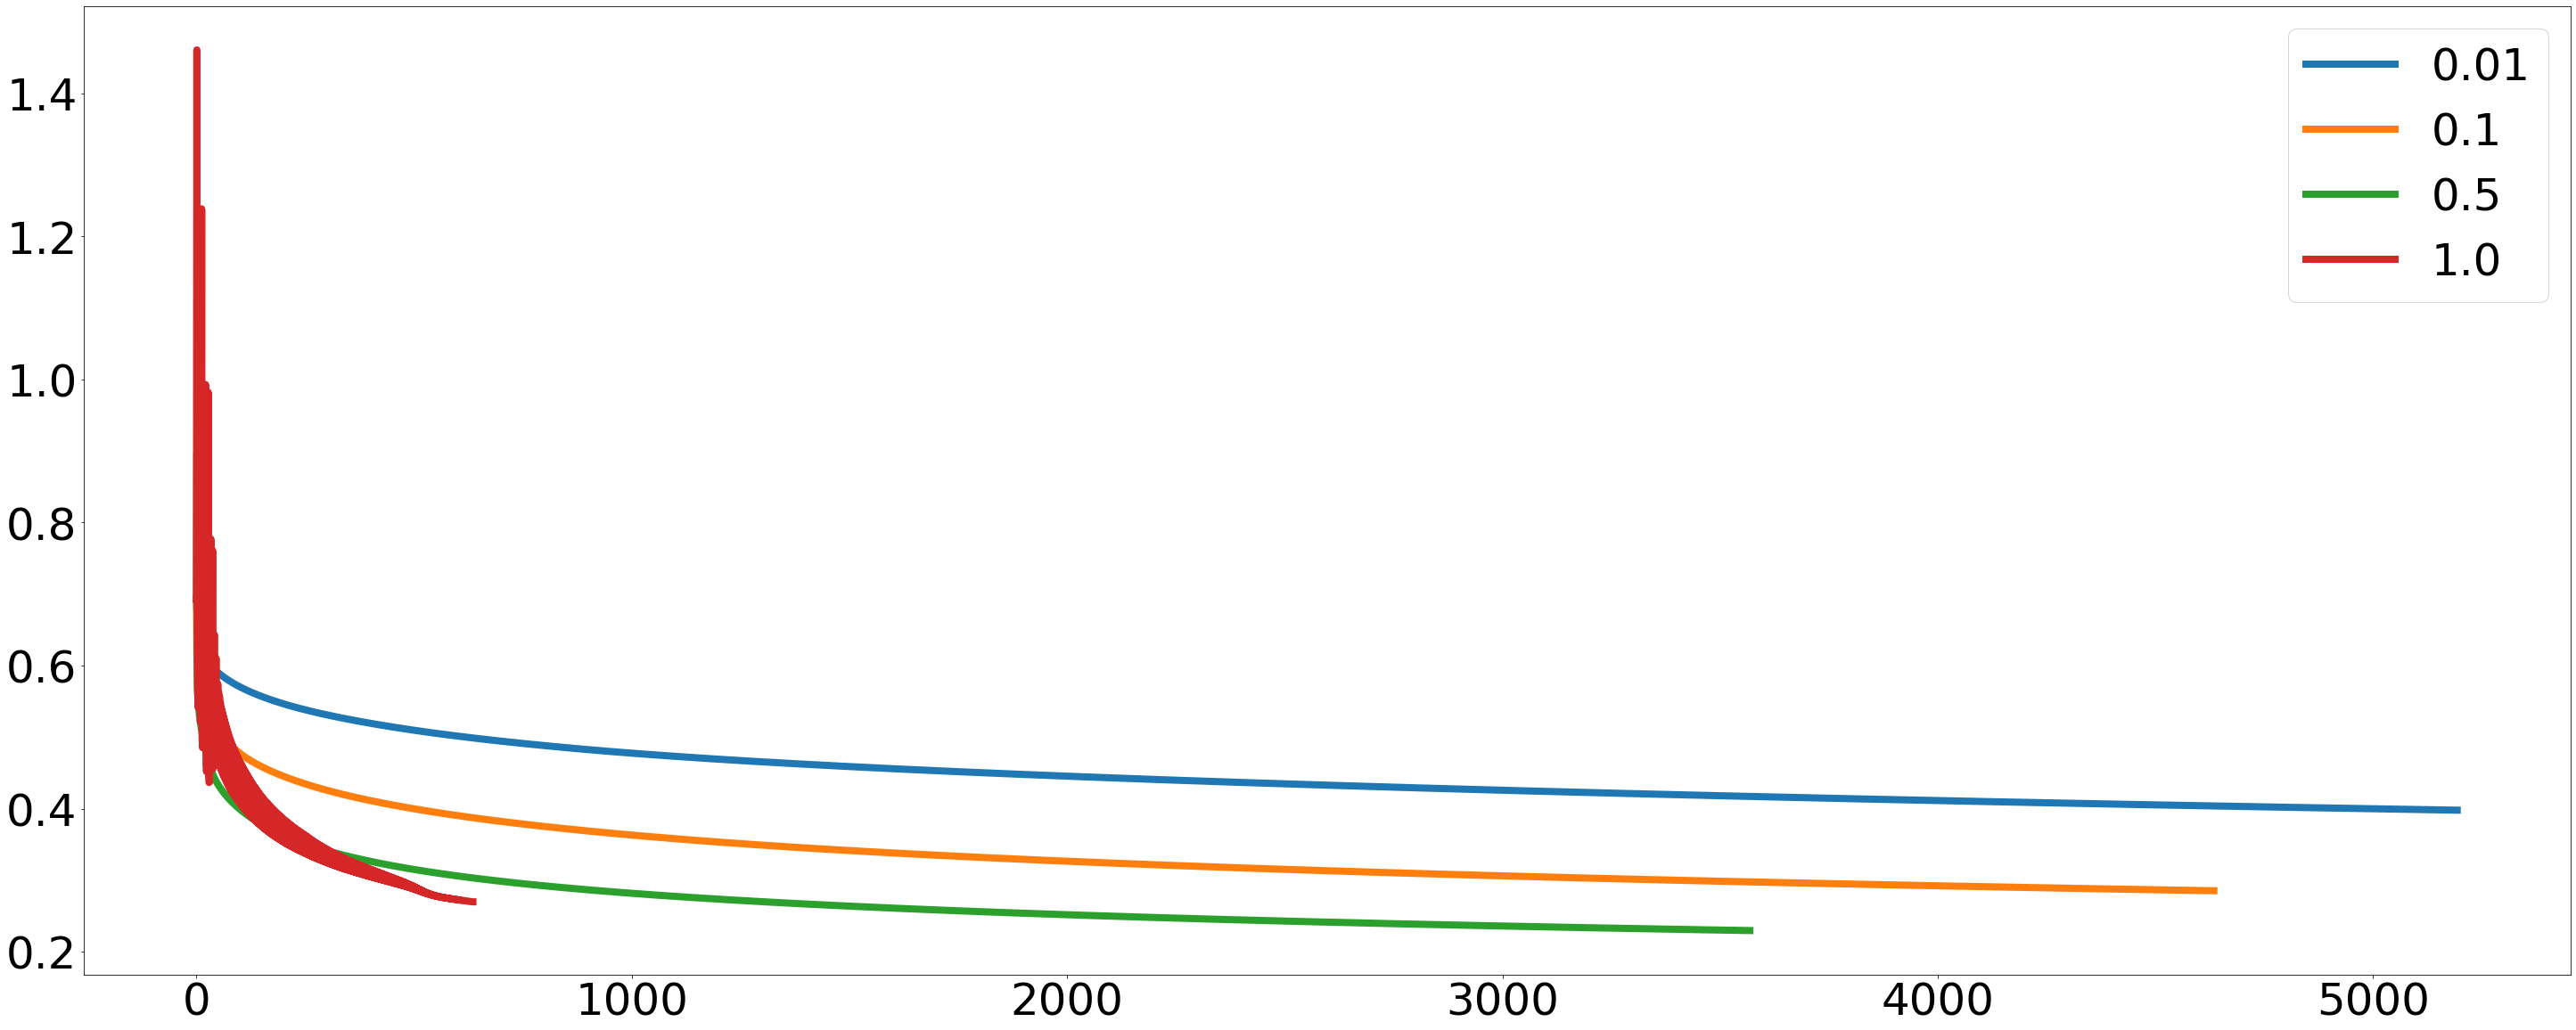

In [0]:
alphas = [0.01, 0.1, 0.5, 1.0]
fig = plt.figure(figsize=(50, 20))
for alpha in alphas:
    oracle = GDClassifier(step_alpha=alpha, step_beta=0.0, 
                 tolerance=1e-5, max_iter=10000, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    plt.plot(oracle.history['func'], lw = 8, label=alpha)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от реального времени работы метода

Видим перевёрнутую картину относительно первых двух графиков: чем лучше минимизировали функционал, тем лучше accuracy получаем. Чем больше времени тем ближе спуск к минимума функционала. В случае с шагом 1.0 хорошая accuracy достигается быстрее всего, и лишь немного уступает accuracy с шагом 0.5.

In [0]:
alphas = [0.01, 0.1, 0.5, 1.0]
accuracy = []
time_lst = []
for alpha in alphas:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000, 5000):
        oracle = GDClassifier(step_alpha=alpha, step_beta=0.0, 
                     tolerance=1e-5, max_iter=max_iter, l_2_coef=0.0)
        oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

<Figure size 3600x1440 with 0 Axes>

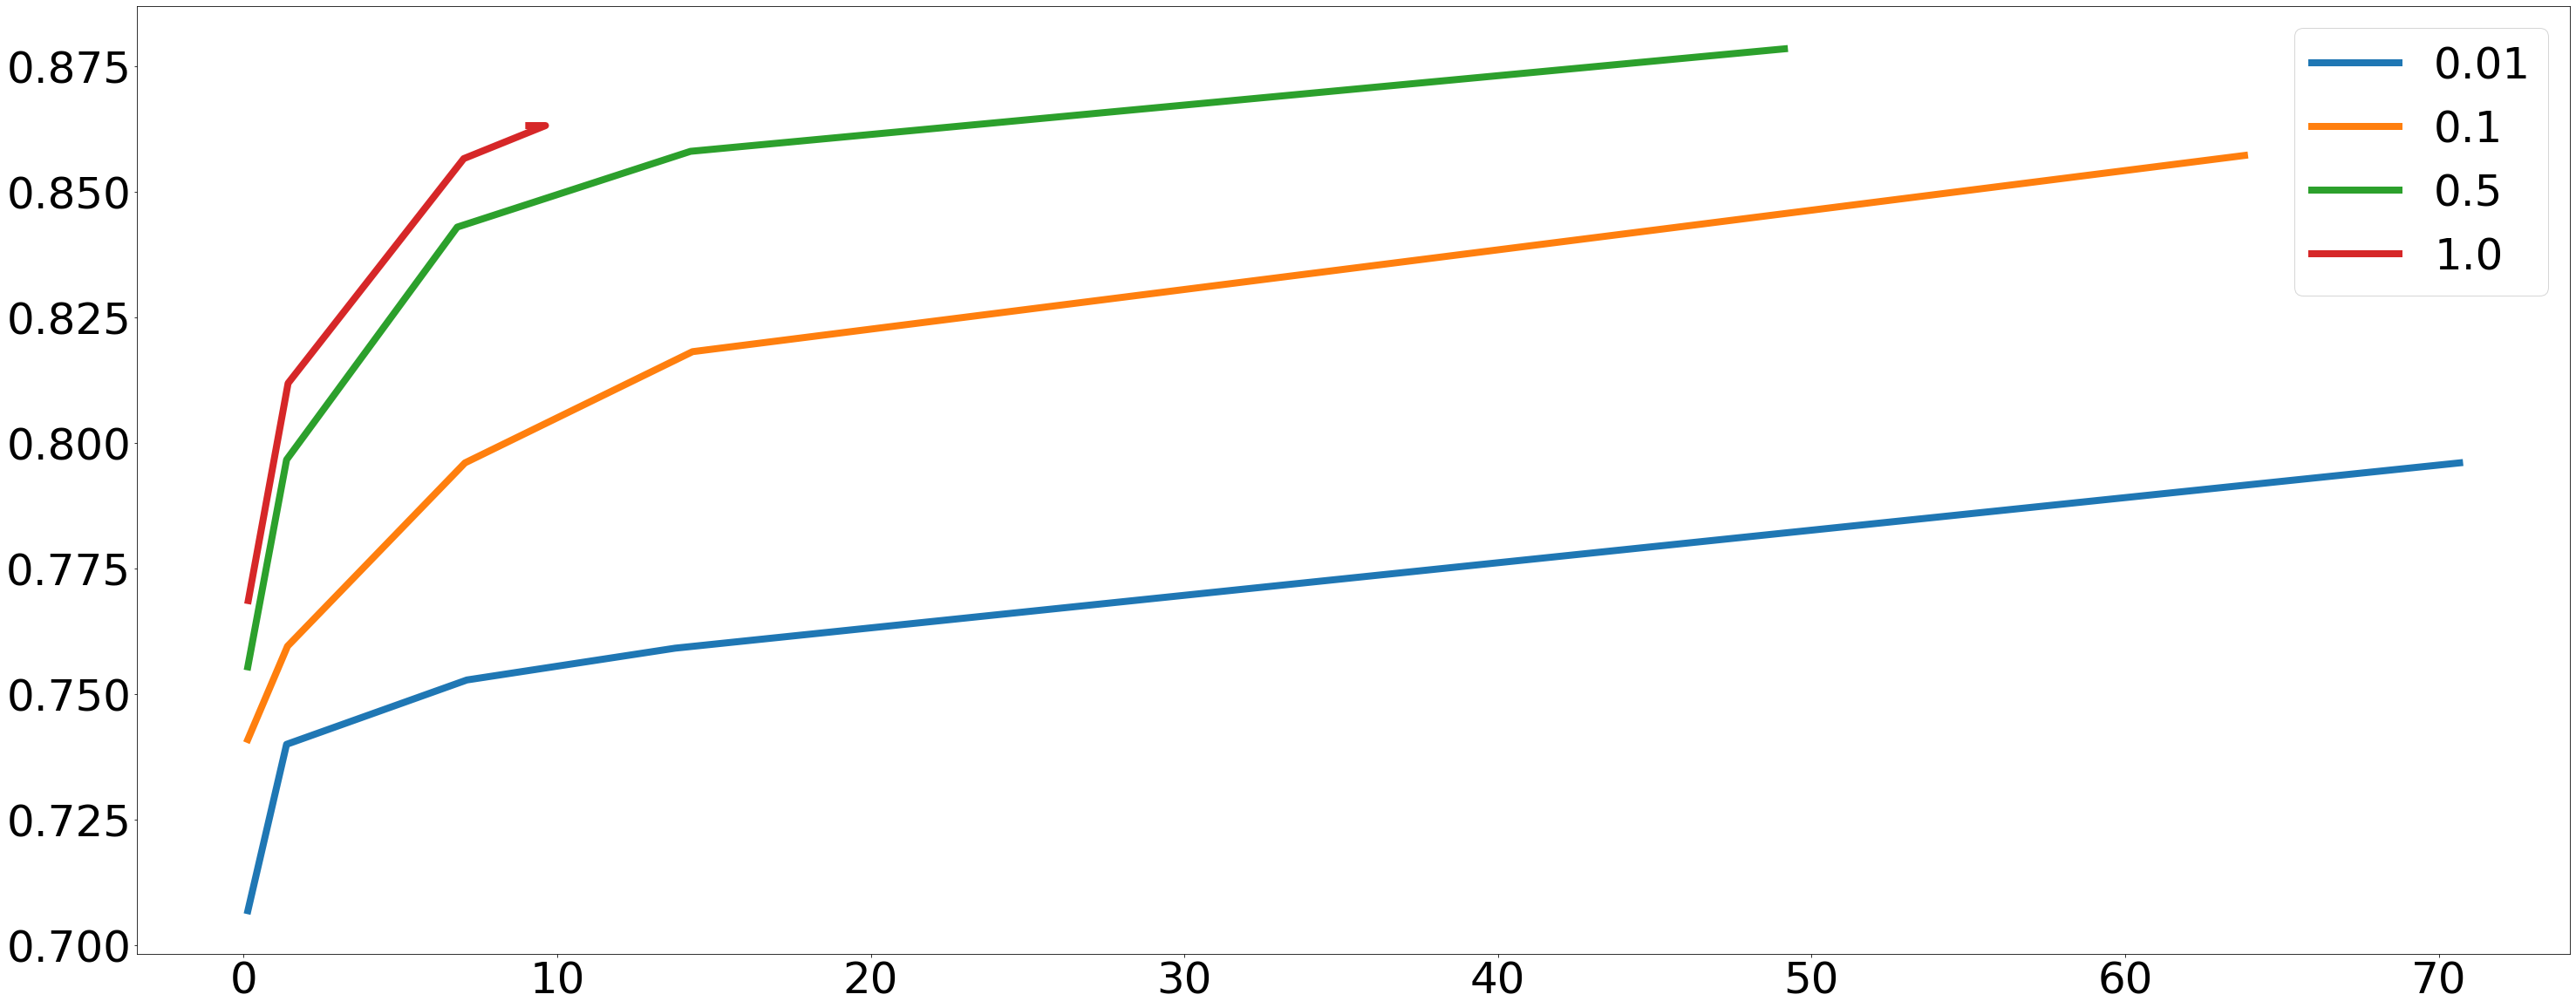

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=alphas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

Количество итераций коррелирует с временме работы спуска, поэтому на графиках видны те же результаты.

In [0]:
alphas = [0.01, 0.1, 0.5, 1.0]
accuracy = []
iter_lst = []
for alpha in alphas:
    curr_accuracy = []
    curr_iter_lst = []
    for max_iter in (10, 100, 500, 1000, 5000):
        oracle = GDClassifier(step_alpha=alpha, step_beta=0.0, 
                     tolerance=1e-5, max_iter=max_iter, l_2_coef=0.0)
        oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter_lst.append(len(oracle.history['func']))
    iter_lst.append(curr_iter_lst)
    accuracy.append(curr_accuracy)

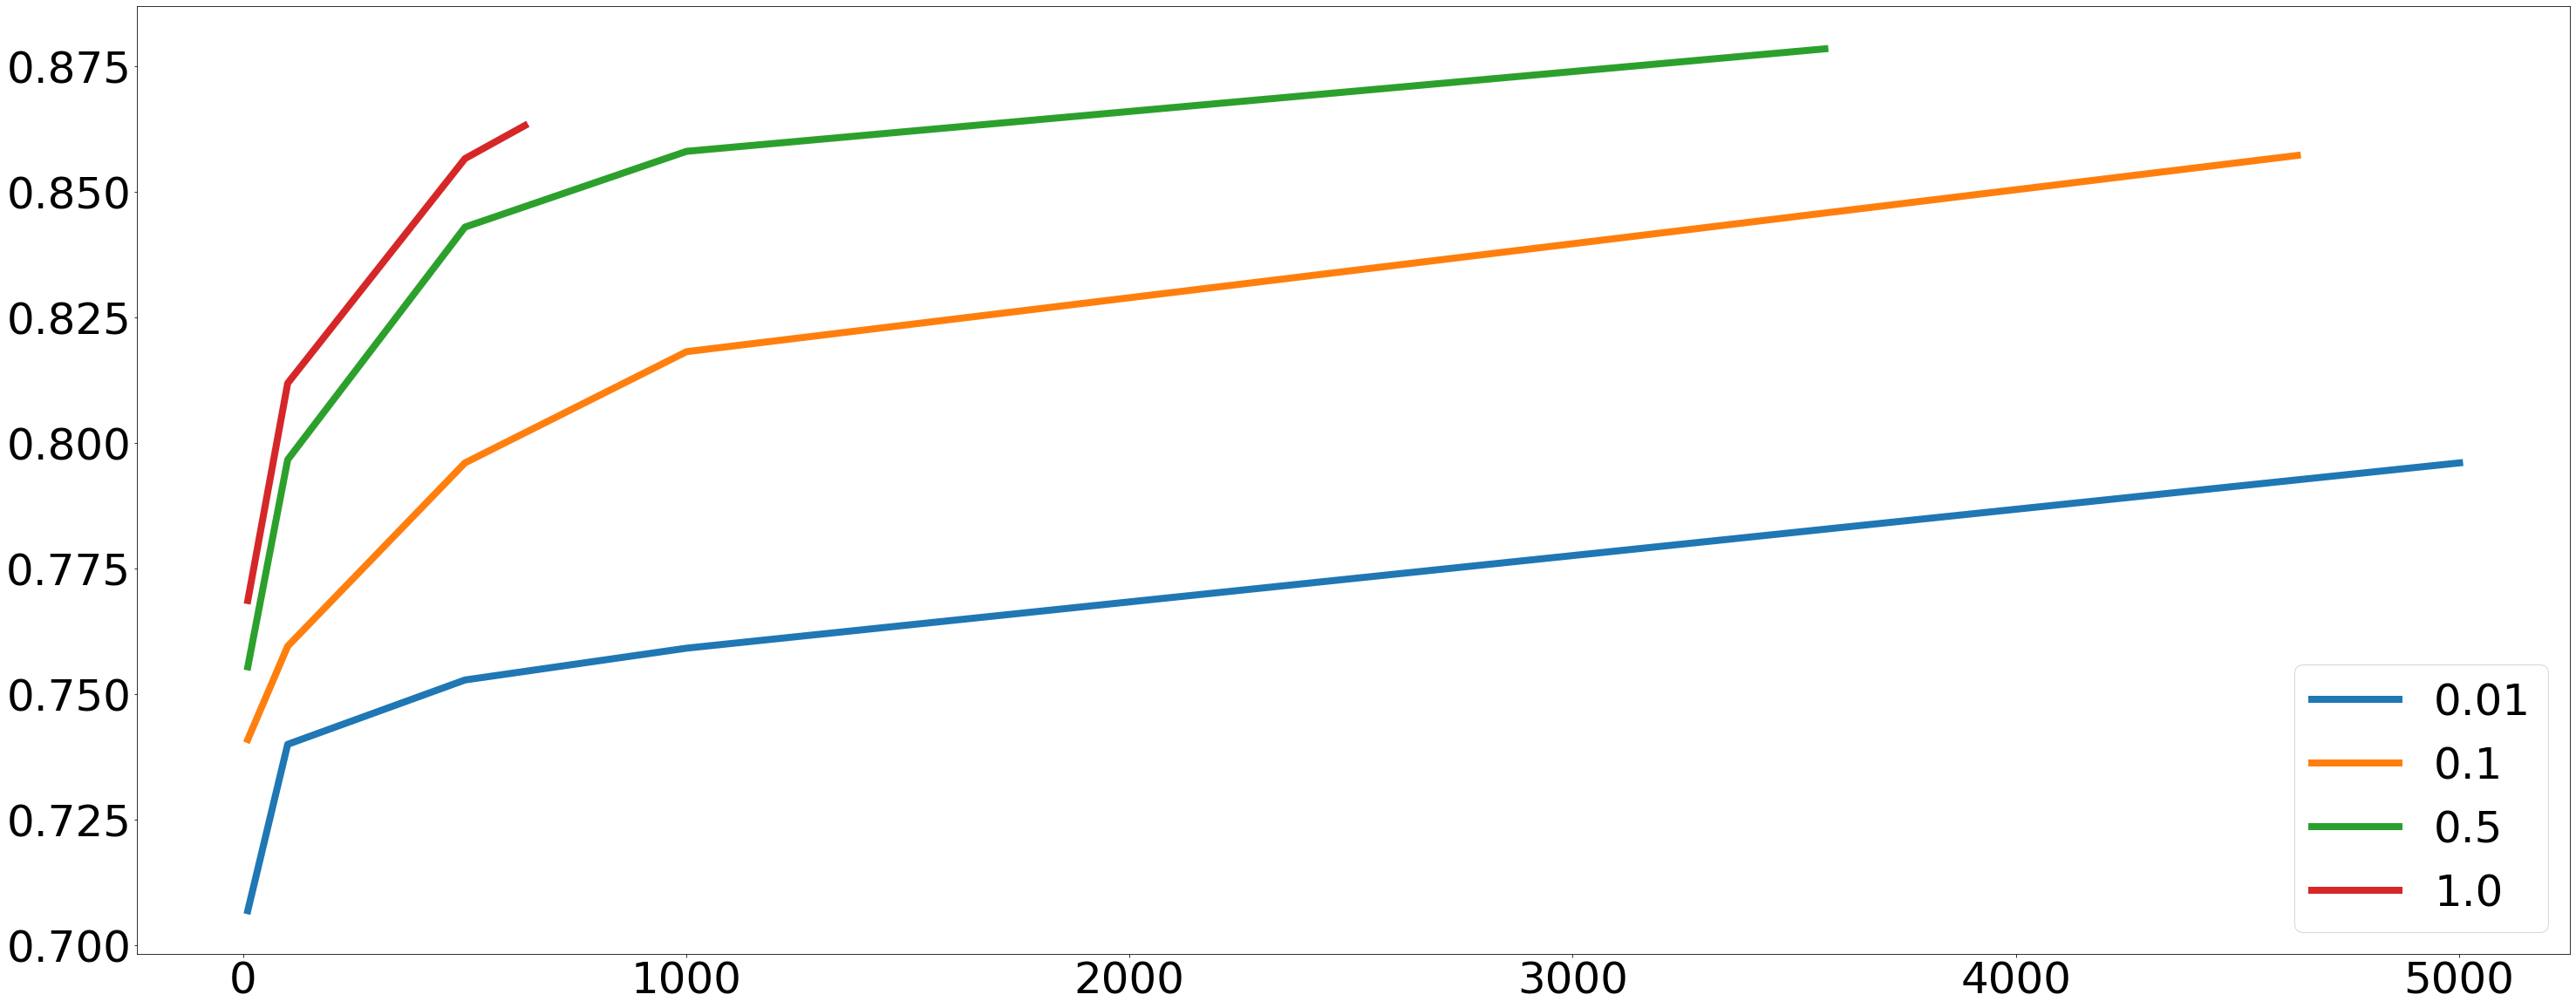

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=alphas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

При большом количестве итераций step_alpha = 0.5 показывает лучшую accuracy, но в соотношении время спуска/accuracy однозначно выигрывает step_alpha = 1, поэтому для экономии времени в экспериментах для step_beta и начального приближения буду использовать его.

step_beta

Зависимость функции потерь от реального времени работы метода

Если взять step_beta большой, то шаг очень быстро становится маленьким, и метод оставнавливается, не успев дойти до минимума. При step_beta = 0.01 результат похож на step_beta = 0.0, но большой разницы нет. 

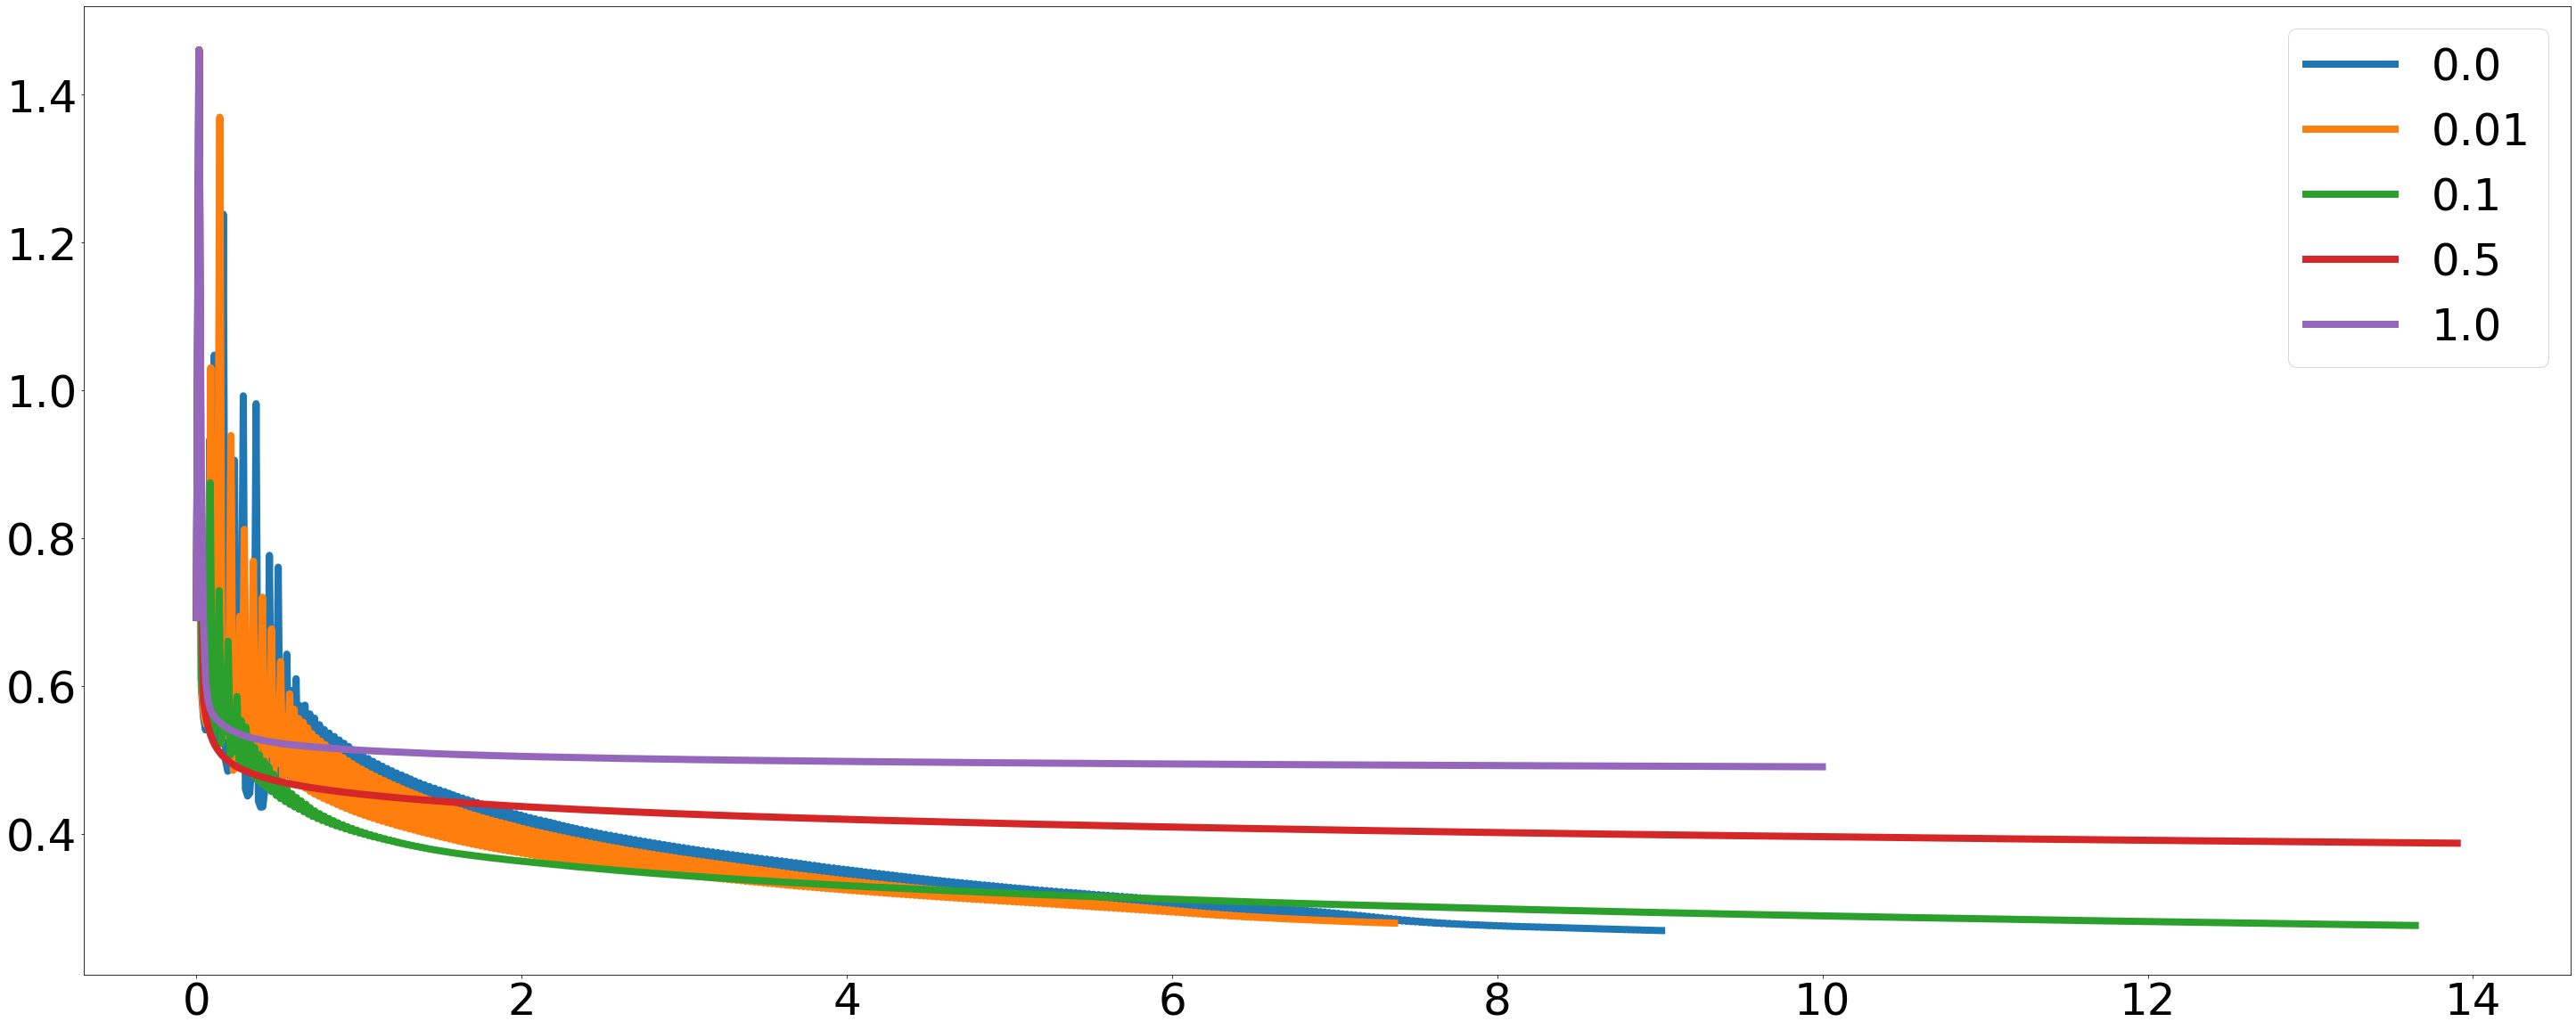

In [0]:
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
fig = plt.figure(figsize=(50, 20))
for beta in betas:
    oracle = GDClassifier(step_alpha=1.0, step_beta=beta, 
                 tolerance=1e-5, max_iter=1000, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=beta)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость функции потерь от итерации метода

Картина похожа на предыдущий график.

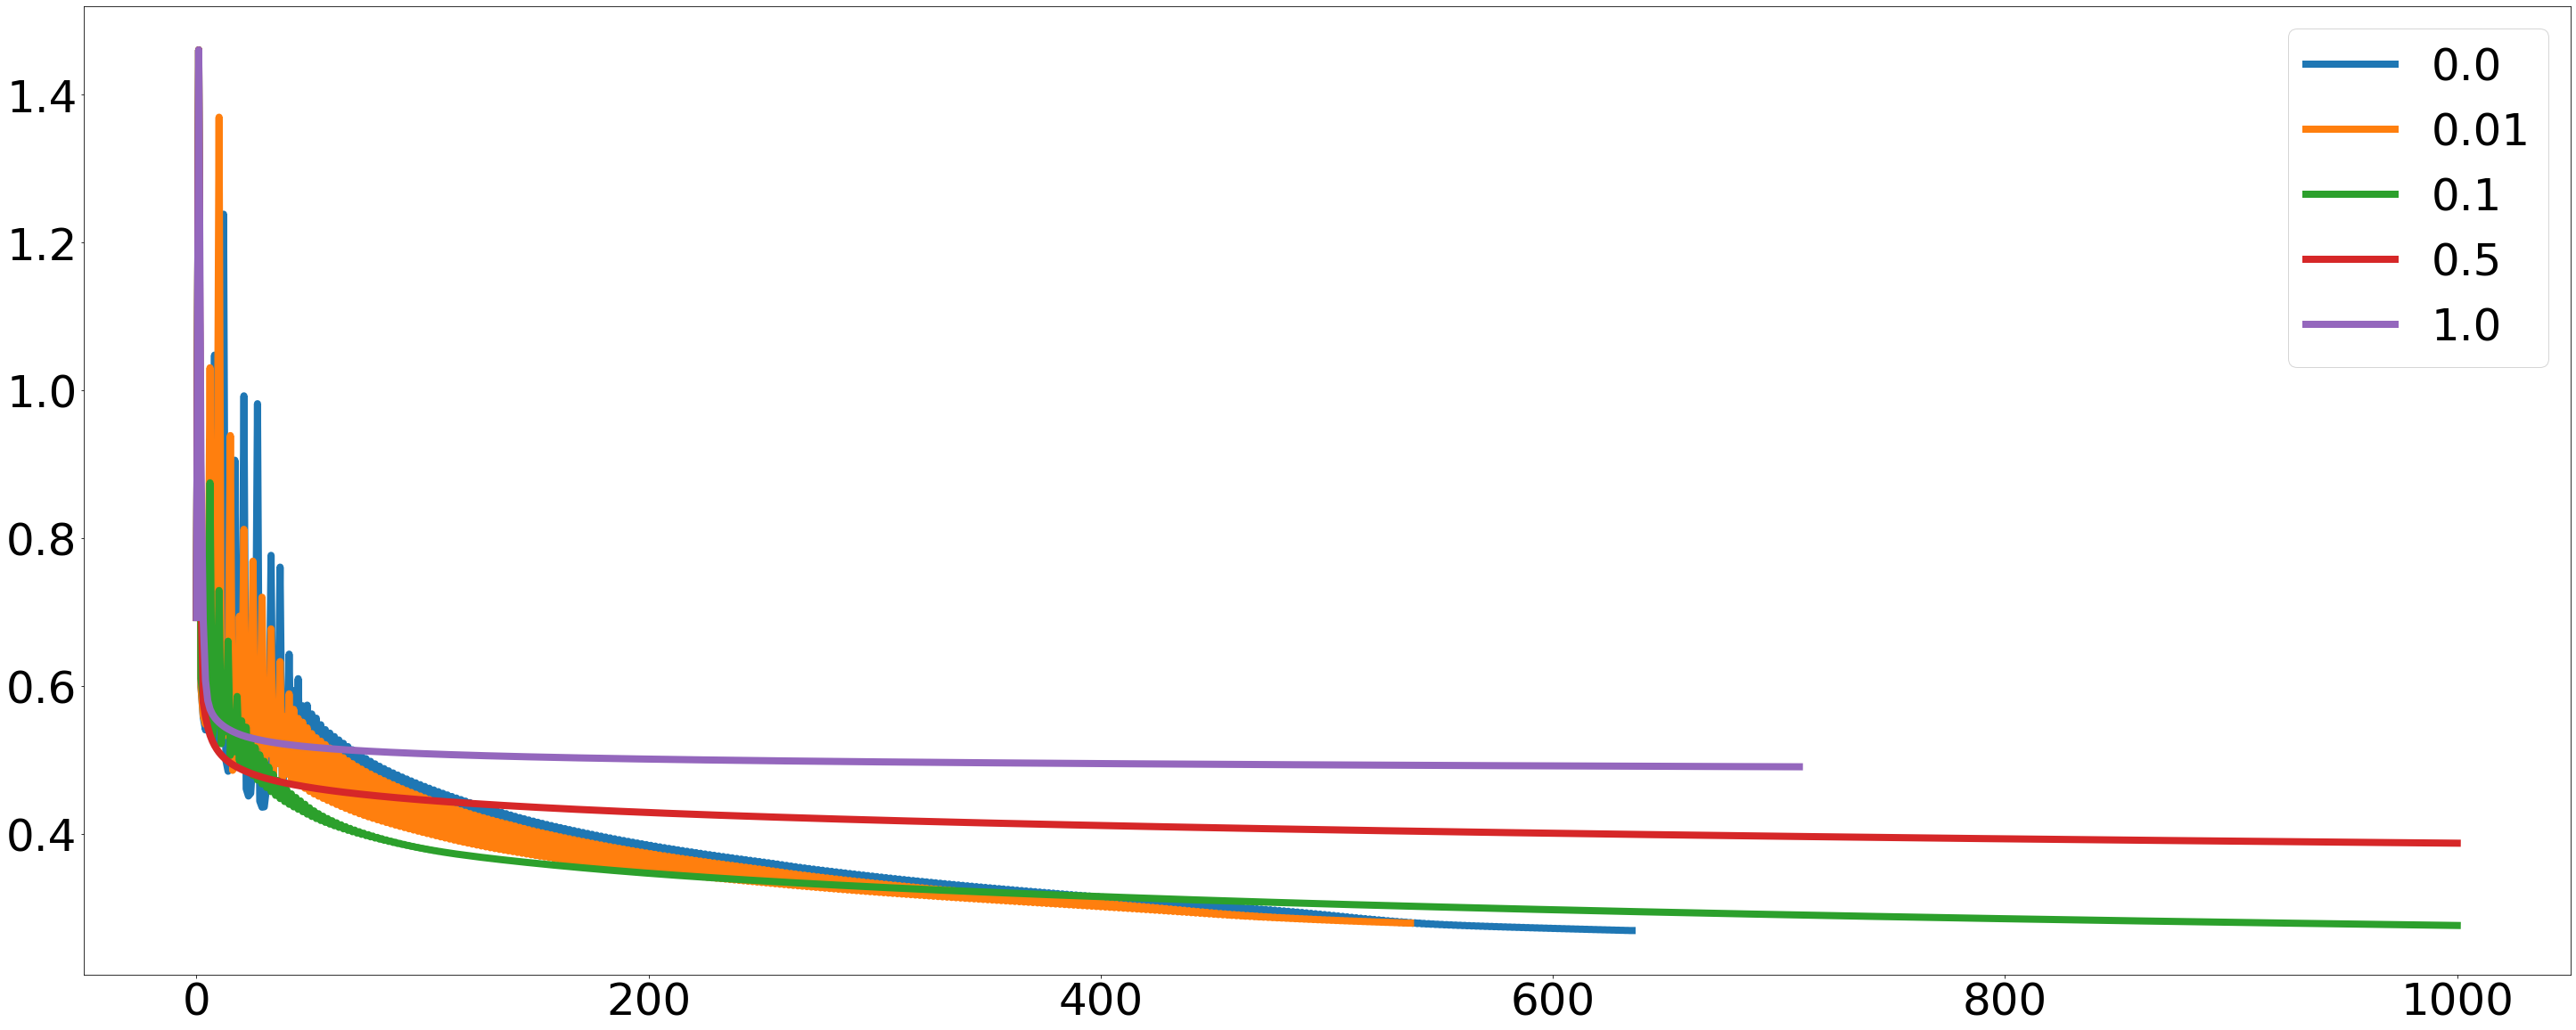

In [0]:
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
fig = plt.figure(figsize=(50, 20))
for beta in betas:
    oracle = GDClassifier(step_alpha=1.0, step_beta=beta, 
                 tolerance=1e-5, max_iter=1000, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    plt.plot(oracle.history['func'], lw = 8, label=beta)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от реального времени работы метода

Картина всё также симметрична. Спуск со step_alpha = 0.01 остановится на итерации около 4000 как на графике выше, поэтому step_beta = 0.0 выглядит предпочтительнее.

In [0]:
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
accuracy = []
time_lst = []
for beta in betas:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000, 5000):
        oracle = GDClassifier(step_alpha=1.0, step_beta=beta, 
                     tolerance=1e-5, max_iter=max_iter, l_2_coef=0.0)
        oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

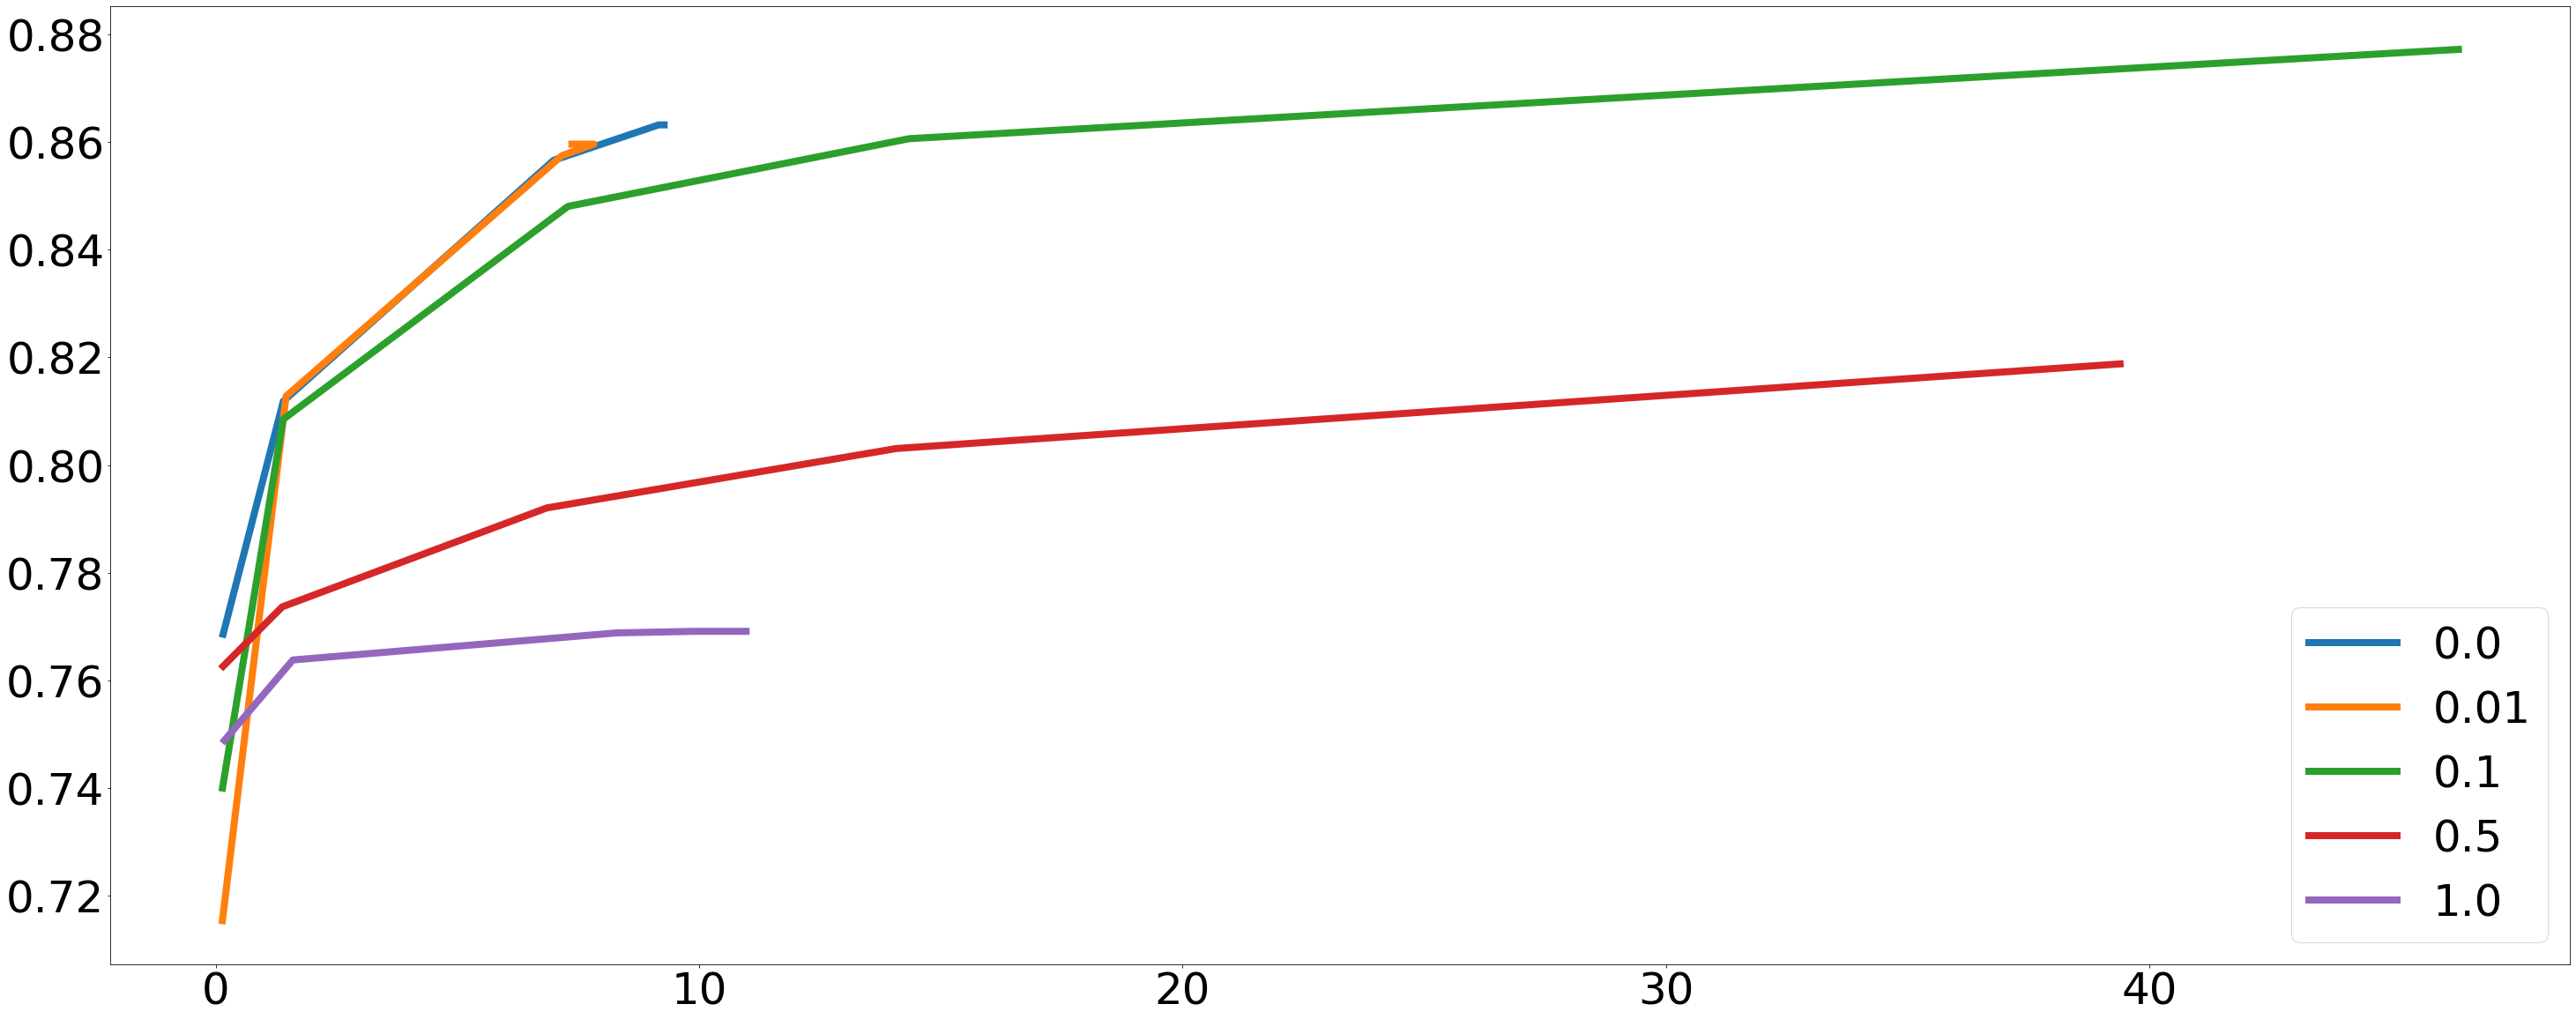

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=betas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

In [0]:
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
accuracy = []
iter_lst = []
for beta in betas:
    curr_accuracy = []
    curr_iter_lst = []
    for max_iter in (10, 100, 500, 1000, 5000):
        oracle = GDClassifier(step_alpha=1.0, step_beta=beta, 
                     tolerance=1e-5, max_iter=max_iter, l_2_coef=0.0)
        oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter_lst.append(len(oracle.history['func']))
    iter_lst.append(curr_iter_lst)
    accuracy.append(curr_accuracy)

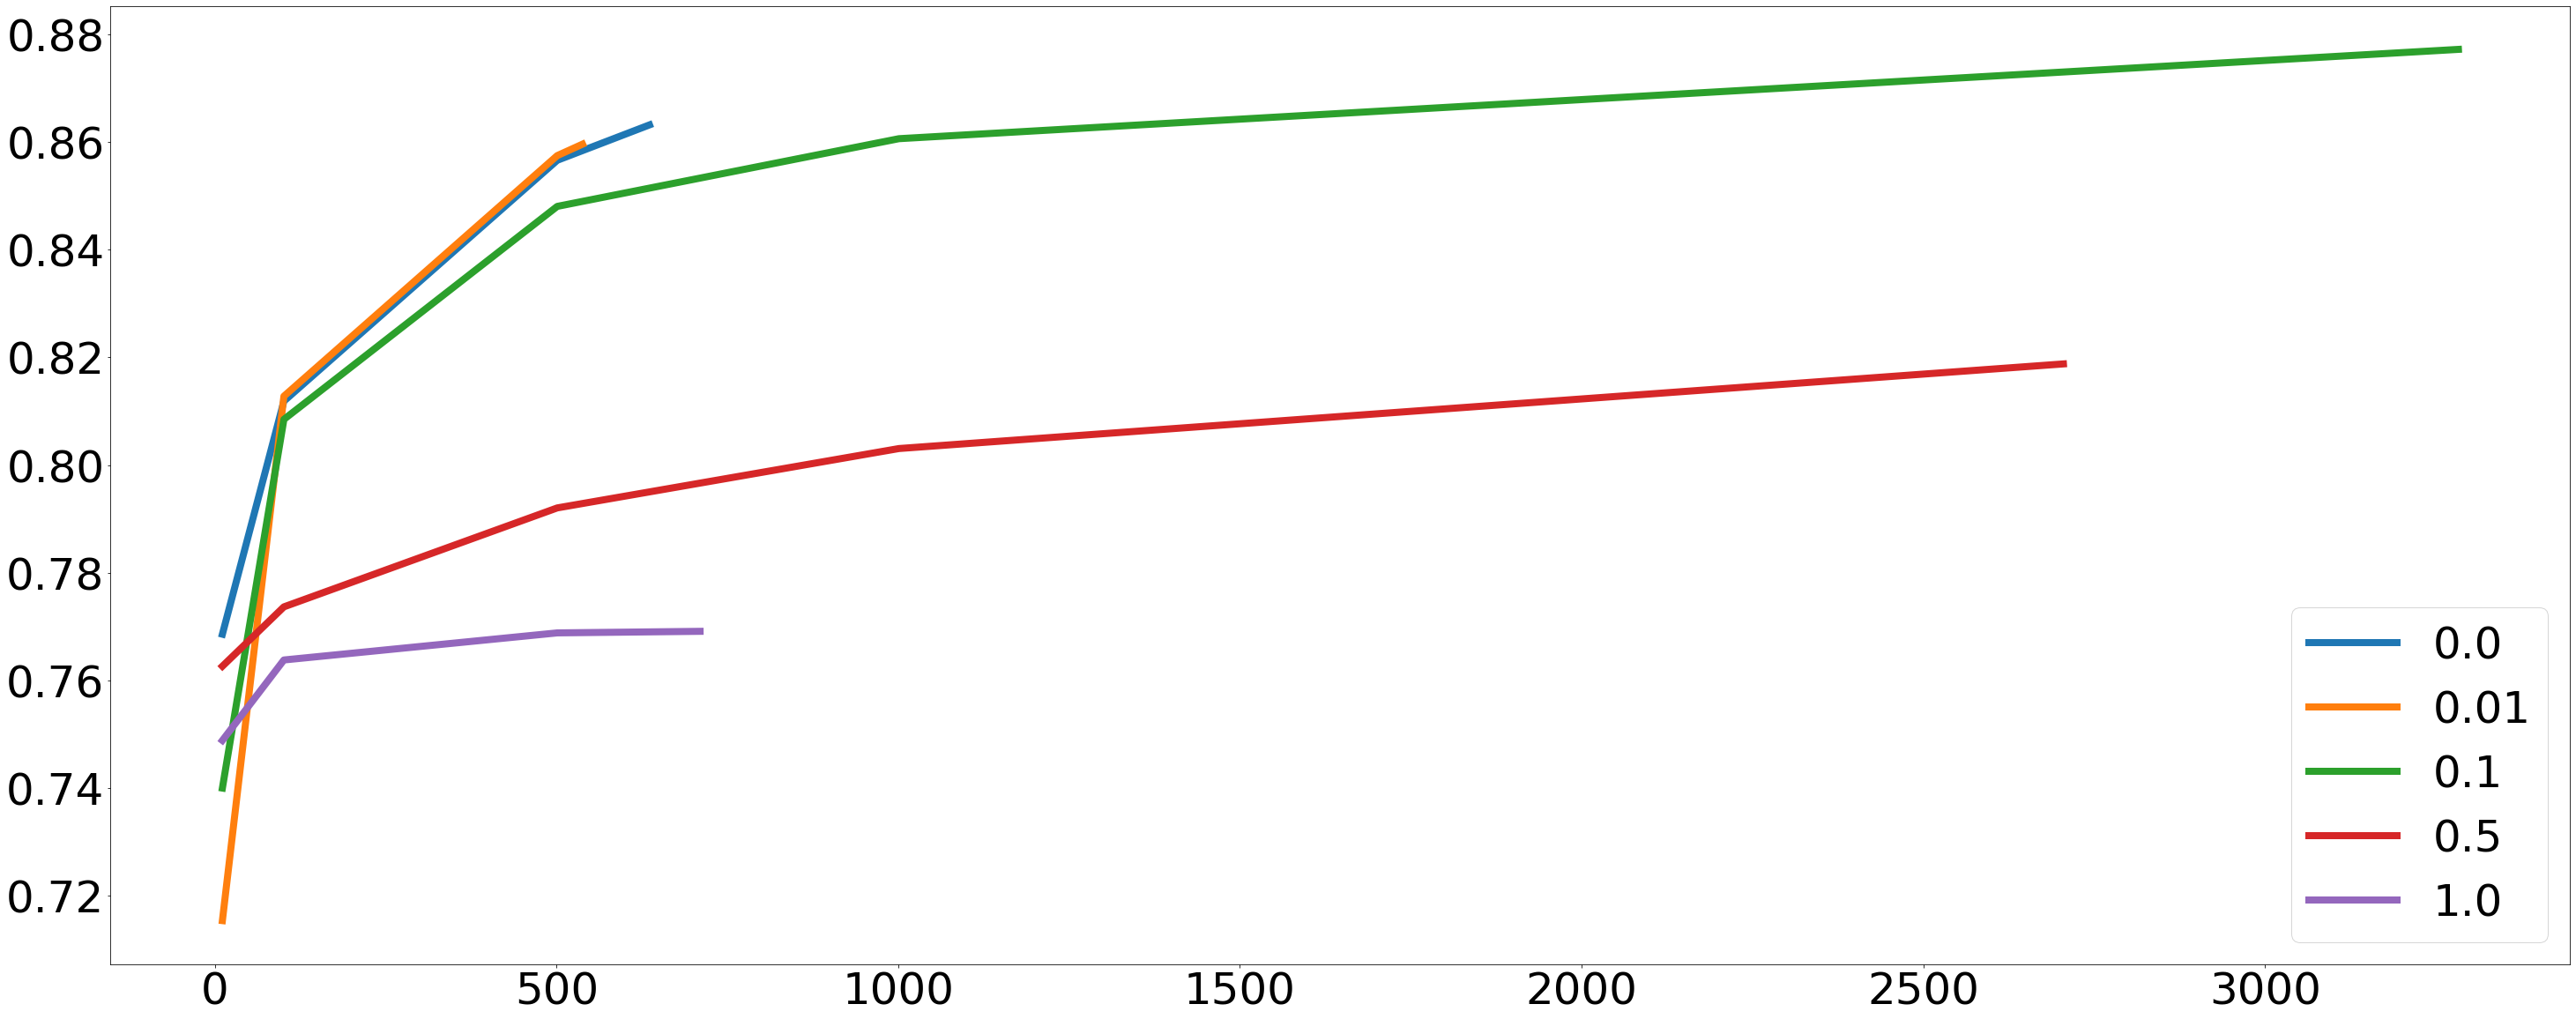

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=betas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Оптимальный в смысле скорость работы/accuracy параметр step_beta это 0.00, поэтому в последнем эксперименте буду использовать его.

Начальное приближение. Рассмотрю только зависимость точности от реального времени работы метода и зависимость точности от итерации метода, так 

Ниже два не очень показательных графика. Начинаясь с какого-то рандомного приближения и большого значения функционала за несколько итерций все спуски сходятся к примерно одинаковым значениям. Надо смотреть на accuracy.

Зависимость значения функции потерь от реального времени работы алгоритма

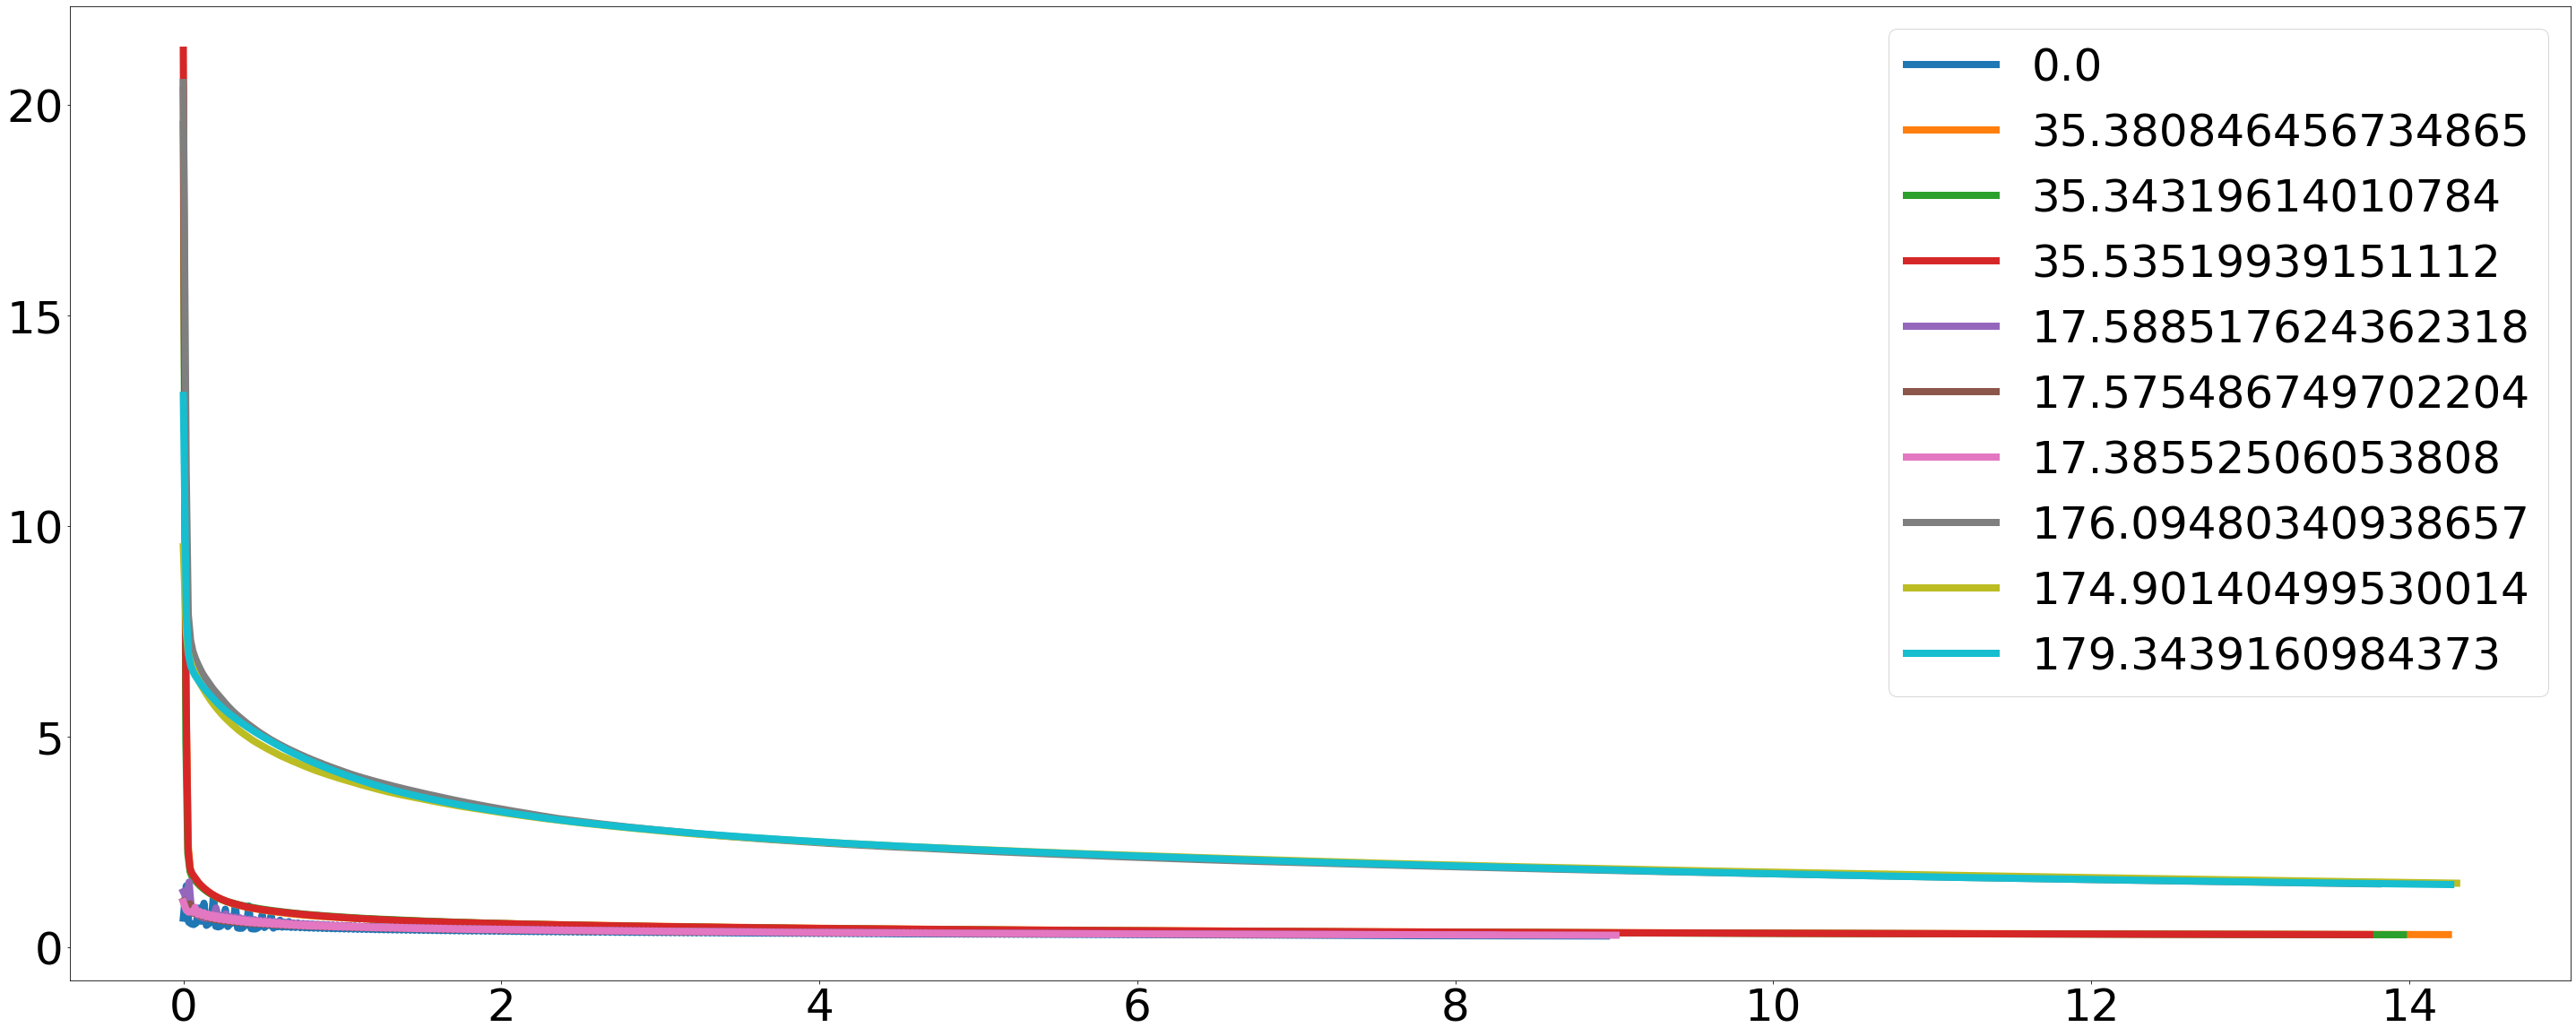

In [0]:
fig = plt.figure(figsize=(50, 20))
weights = ([np.zeros(X_train.shape[1])] 
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)] 
           + [10 * (np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
for w_0 in weights:
    oracle = GDClassifier(step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True, w_0=w_0)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=norm(w_0))
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость значения функции потерь от итерации

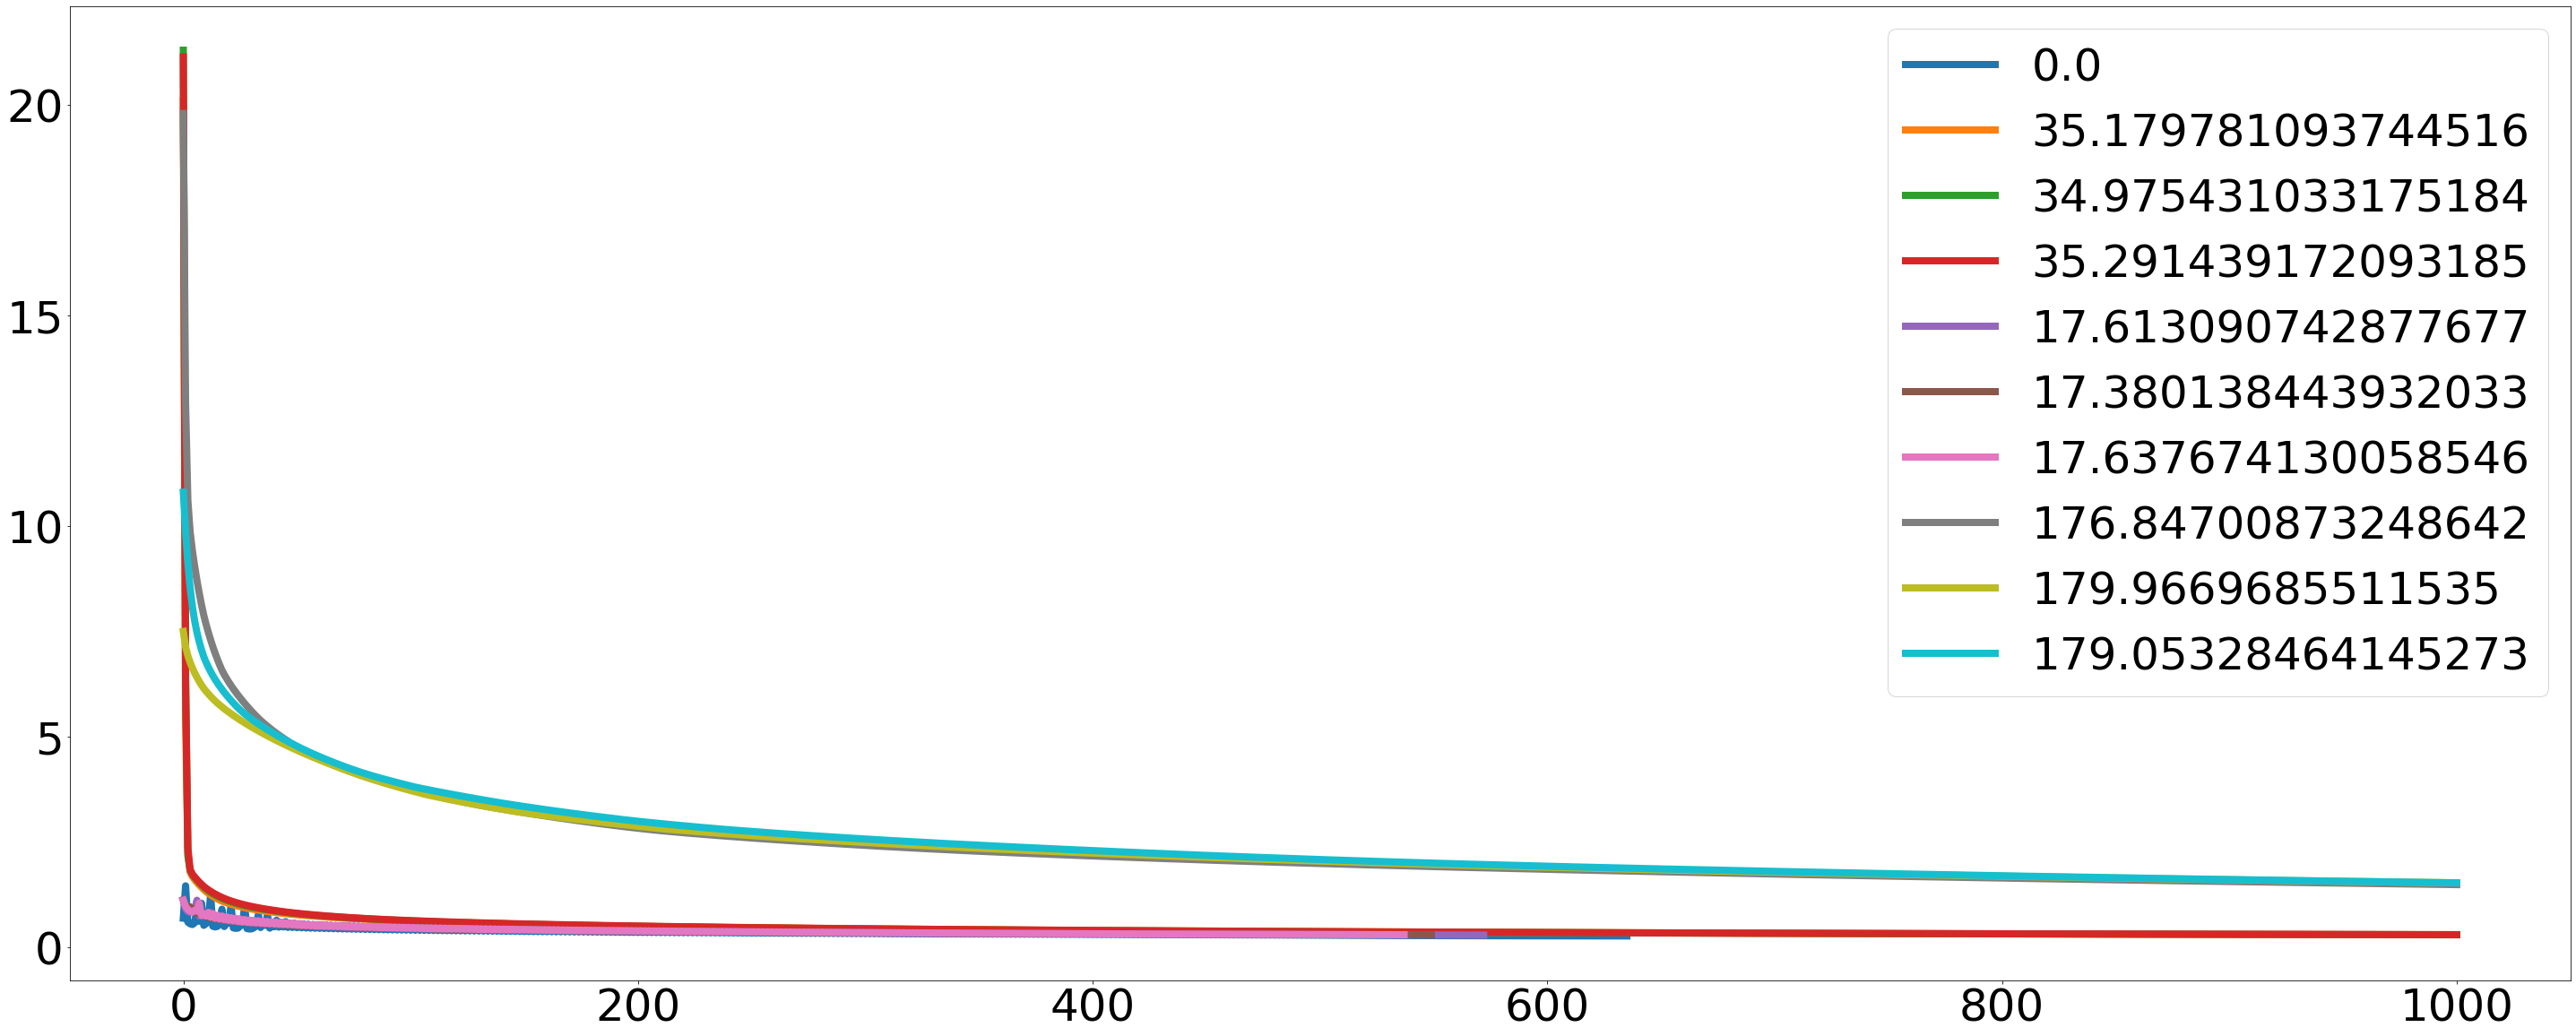

In [0]:
fig = plt.figure(figsize=(50, 20))
weights = ([np.zeros(X_train.shape[1])] 
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)] 
           + [10 * (np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
for w_0 in weights:
    oracle = GDClassifier(step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True, w_0=w_0)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(oracle.history['func'], lw = 8, label=norm(w_0))
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от реального времени работы метода

Посмотрим на начальные приближеия из всех 0 и ещё 9 случайных по схеме ниже + из точки, полученной в результе fit-а модели. В легенде указана норма начального приближения.

In [0]:
oracle = GDClassifier(step_alpha=1.0, step_beta=0.0, 
                     tolerance=1e-5, max_iter=1000, l_2_coef=0.0)
oracle.fit(X_train, y_train, trace=True)
original = original = oracle.get_weights()

In [0]:
weights = ([np.zeros(X_train.shape[1])] + [original]
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)] 
           + [10 * (np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
accuracy = []
time_lst = []
for w_0 in weights:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000):
        if np.all(w_0 == original):
            tolerance = 1e-7
        else:
            tolerance = 1e-5
        oracle = GDClassifier(step_alpha=1.0, step_beta=0.0, 
                     tolerance=tolerance, max_iter=max_iter, l_2_coef=0.0)
        oracle.fit(X_train, y_train, trace=True, w_0=w_0)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

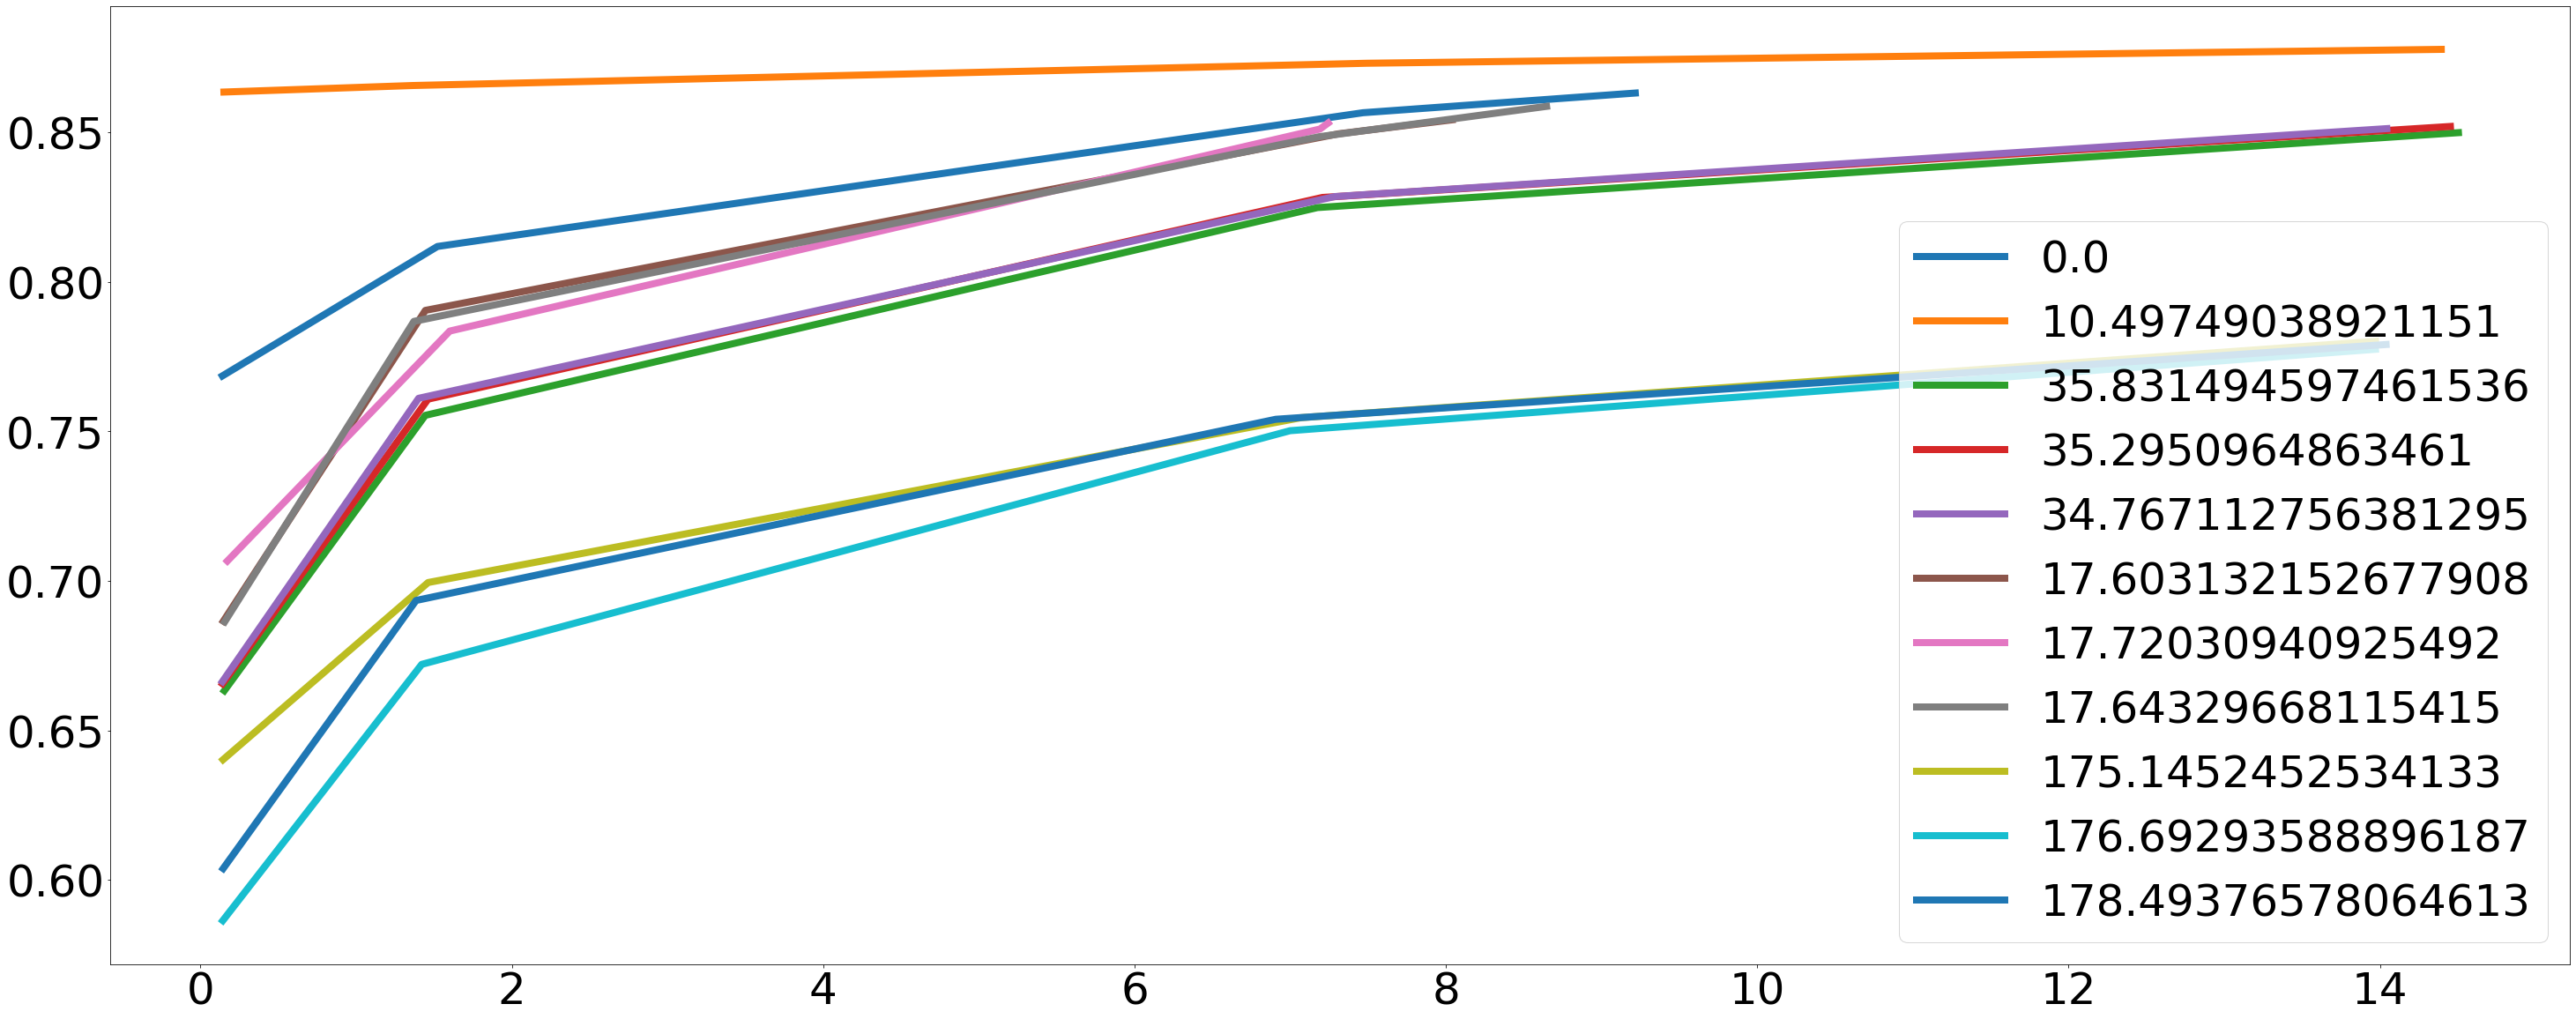

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=norm(weights[i]))
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

In [0]:
weights = ([np.zeros(X_train.shape[1])] + [original]
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)] 
           + [10 * (np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
accuracy = []
iter_lst = []
for w_0 in weights:
    curr_accuracy = []
    curr_iter = []
    for max_iter in (10, 100, 500, 1000):
        if np.all(w_0 == original):
            tolerance = 1e-7
        else:
            tolerance = 1e-5
        oracle = GDClassifier(step_alpha=1.0, step_beta=0.0, 
                     tolerance=tolerance, max_iter=max_iter, l_2_coef=0.0)
        oracle.fit(X_train, y_train, trace=True, w_0=w_0)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter.append(len(oracle.history['func']))
    iter_lst.append(curr_iter)
    accuracy.append(curr_accuracy)

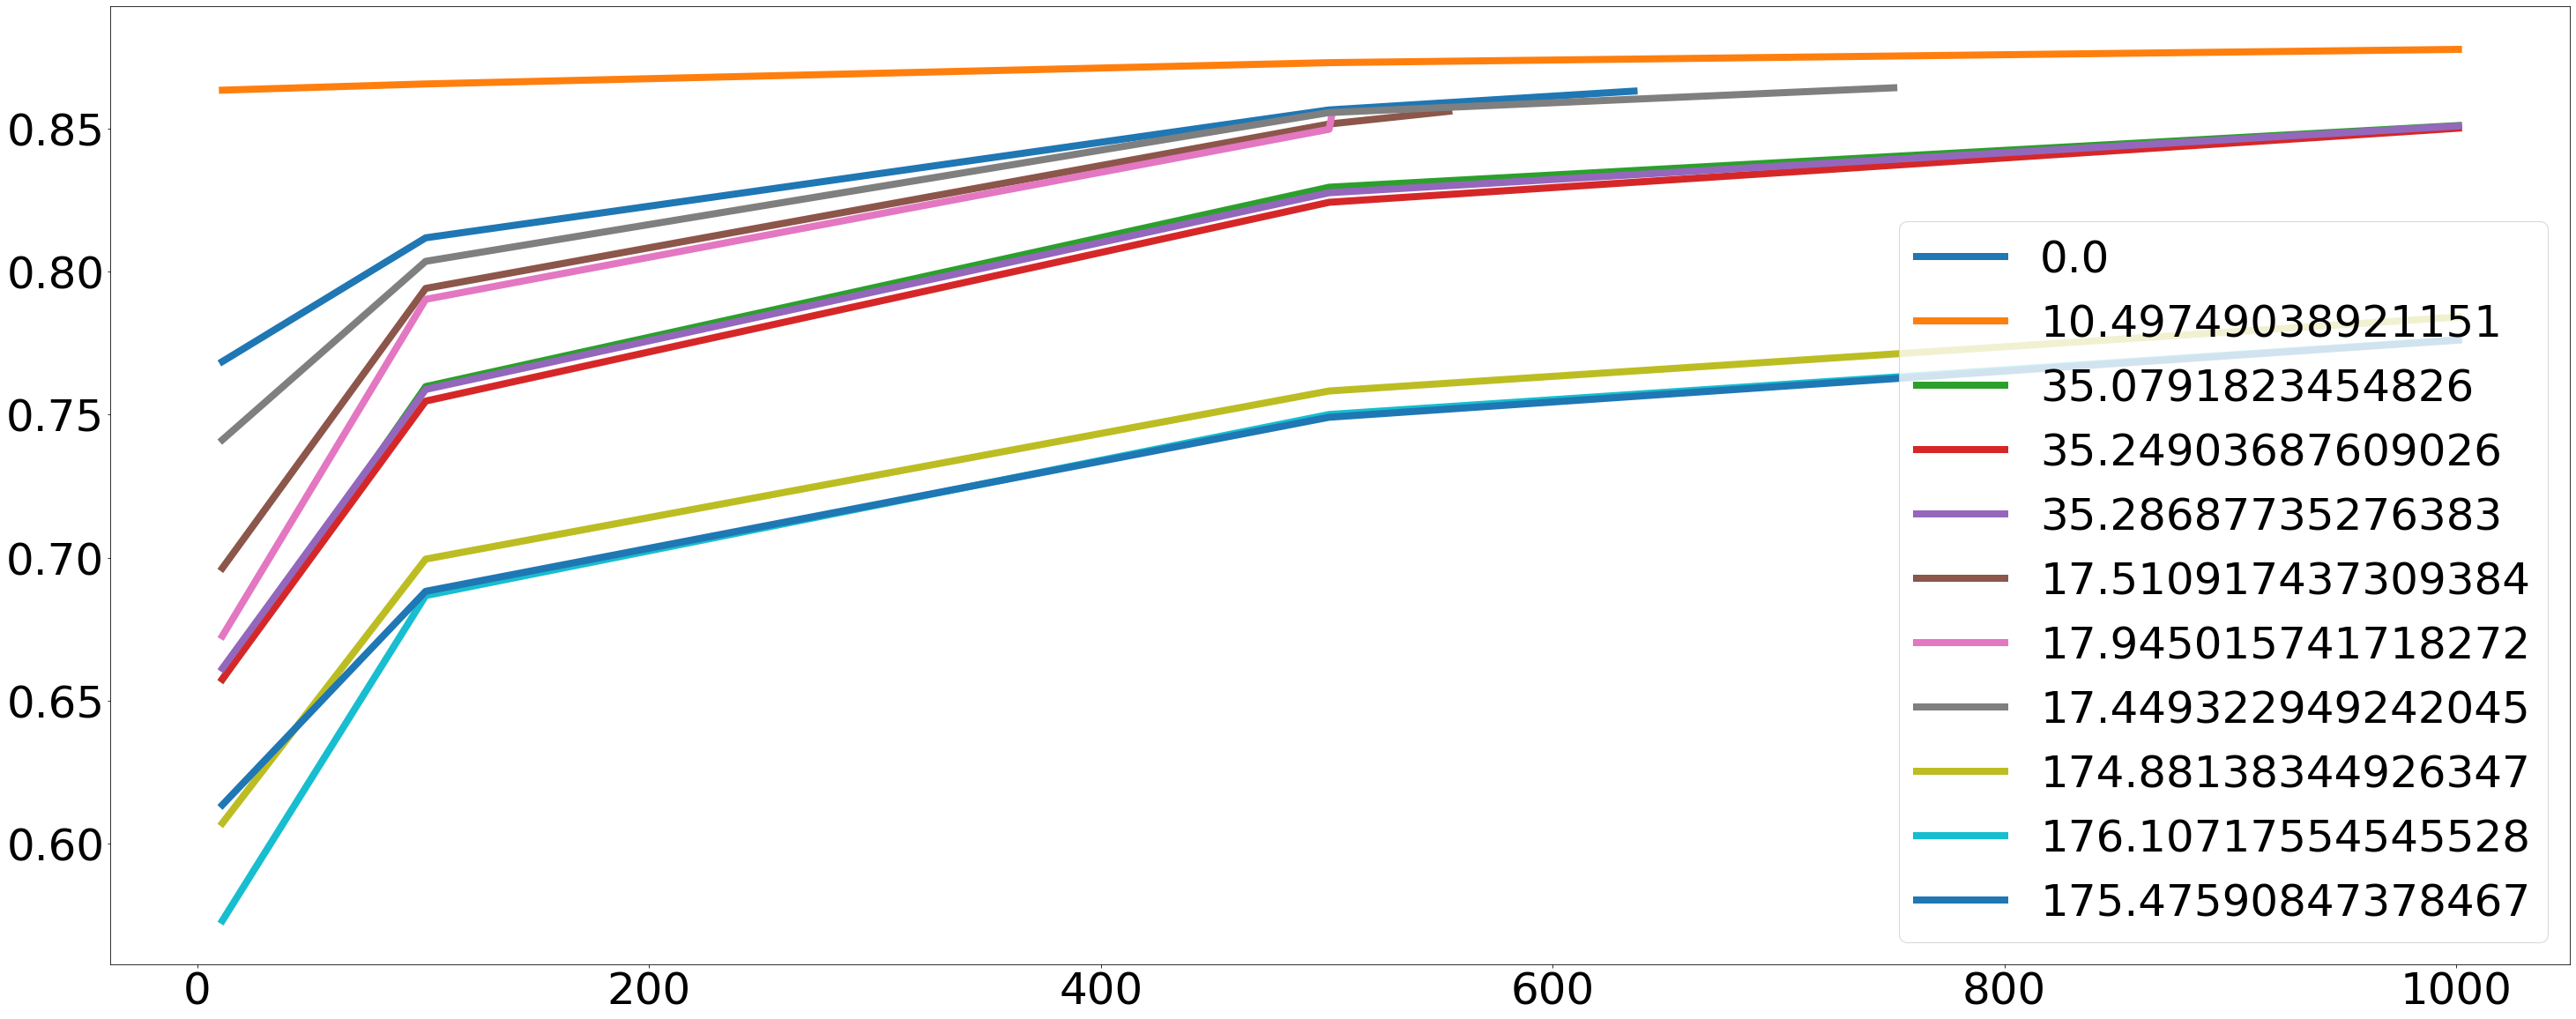

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=norm(weights[i]))
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

В зависимости от начального приближения есть разница в скорости сходимости. Нижние (на графике) линии не сошлись (дошли до max_iter). Судя по средним линиям, которые почти сошлись, нижние линии тоже придут к уровню спуска с нач. условием = 0.0. В данной задаче приближение 0.0 достаточно хорошо. Точка нач. приближения, полученная после fit-а после уменьшения tolerance дала ещё немного accuracy: с 0.85 до 0.88.

Начну с batch_size так как это критично влияет на время работы.

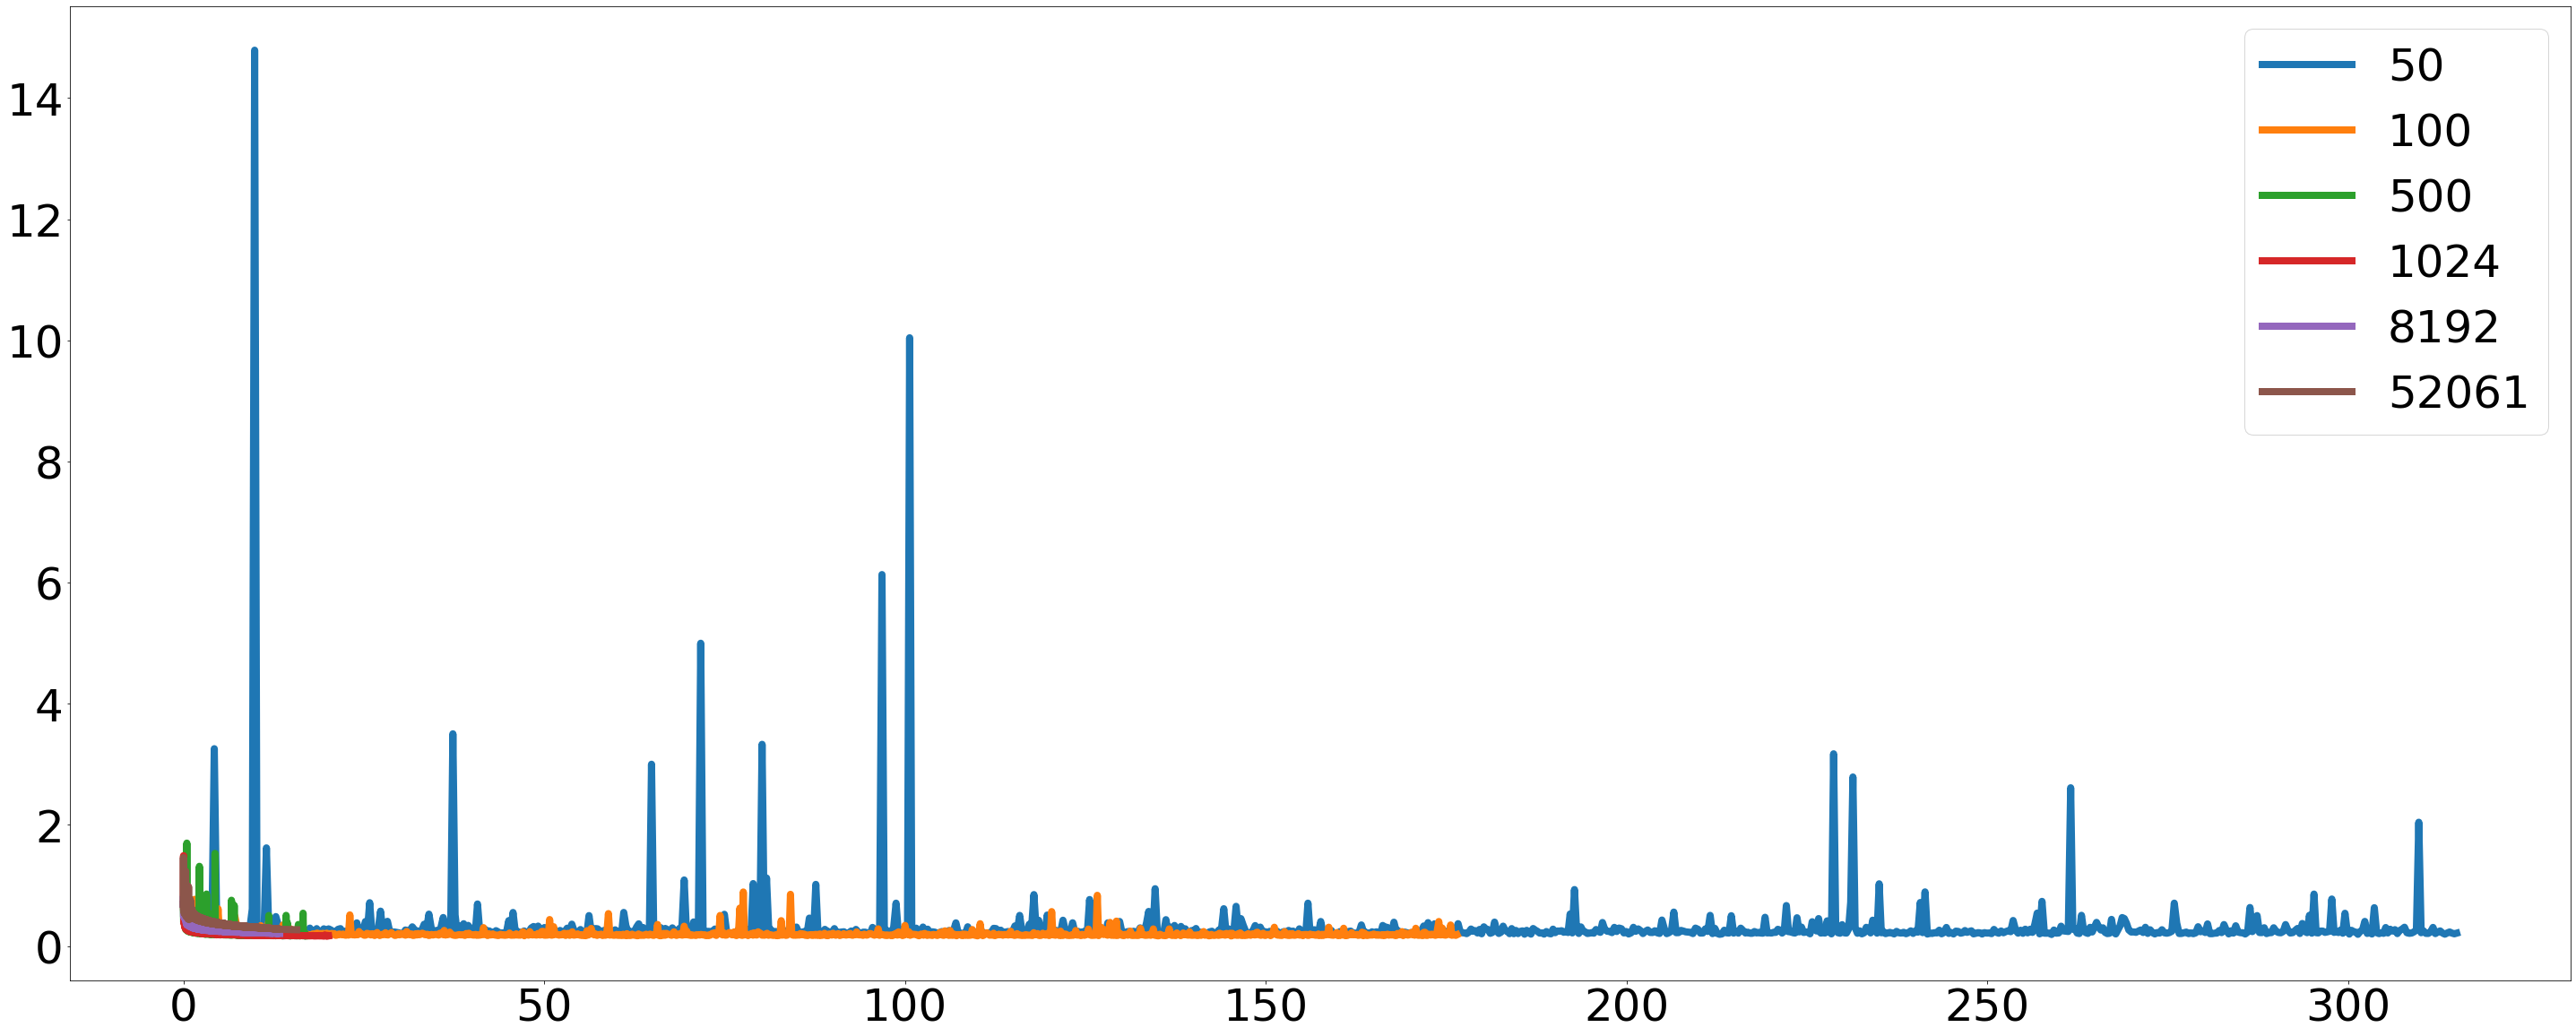

In [0]:
fig = plt.figure(figsize=(50, 20))
batch_sizes = [50, 100, 500, 1024, 8192, X_train.shape[0]]
for batch_size in batch_sizes:
    oracle = SGDClassifier(batch_size=batch_size, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=batch_size)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Выборка 50к достаточно небольшая, batch_size = всей выборке показывает достаточно неплохие результаты, а маленькие батчи (размер=50 и размер=100) обучается очень долго, возможно, из-за 1000 и 500 итераций внутри цикла внутри одной эпохи. В дальнейших экспериментах эти батчи уберу.

График зависимости значения функции потерь от итерации метода

batch_size = 256 оказался тоже очень волатильным. Буду смотреть между [512, 1024, 8192, X_train.shape[0]].  
Поведение при X_train.shape[0] совпадает с обычным градиентным спуском (см. соответсвующий предыдущий график).  
512 - 8192 намного лучше оптимизируют функционал, причём за меньшее число эпох (если сравнивать с итерациями).

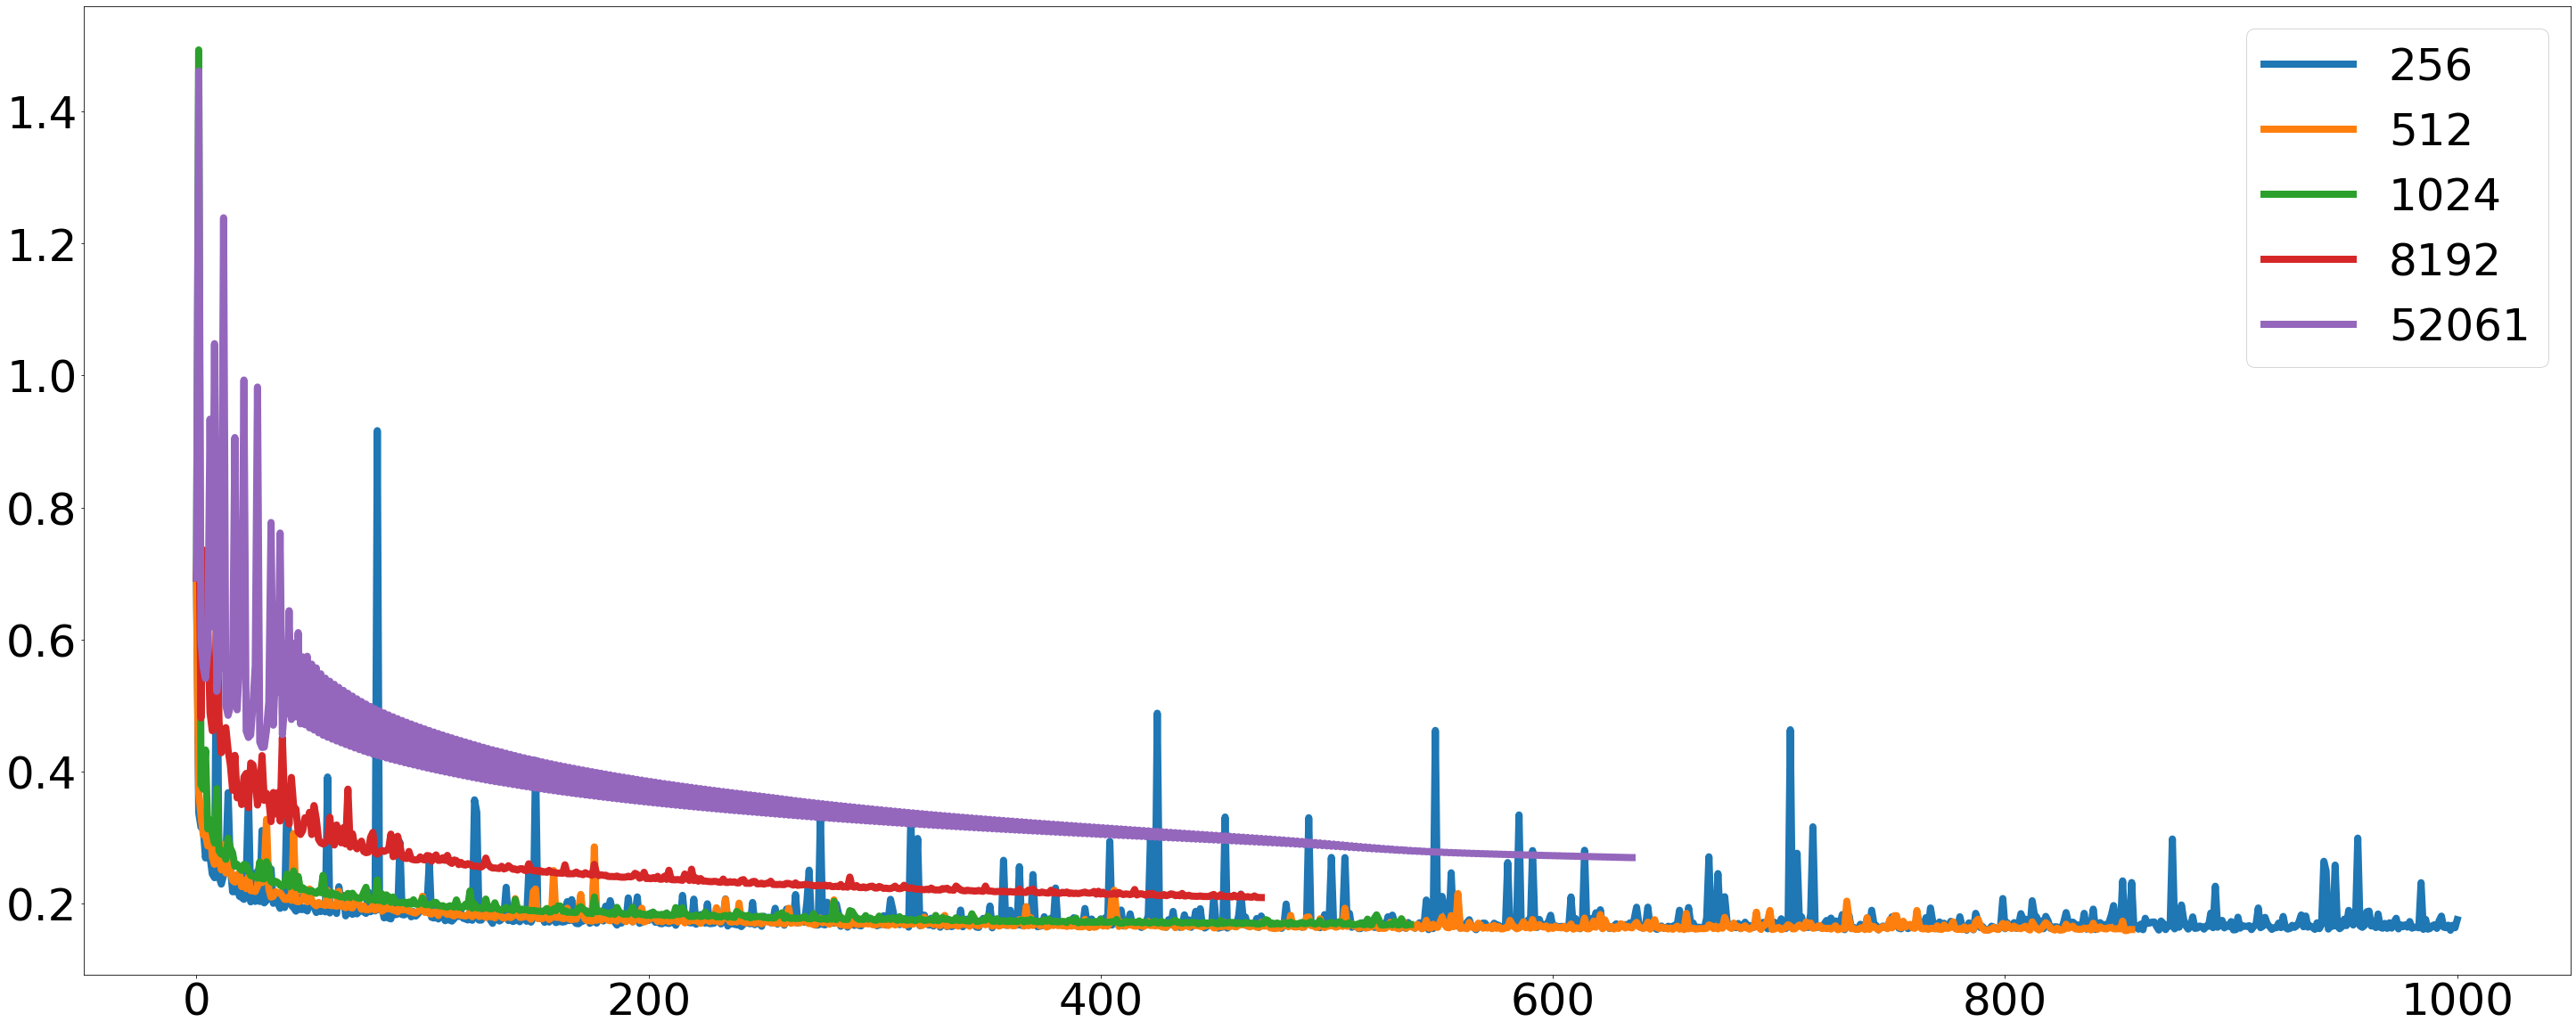

In [0]:
fig = plt.figure(figsize=(50, 20))
batch_sizes = [256, 512, 1024, 8192, X_train.shape[0]]
for batch_size in batch_sizes:
    oracle = SGDClassifier(batch_size=batch_size, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    plt.plot(oracle.history['func'], lw = 8, label=batch_size)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от реального времени работы метода

In [0]:
batch_sizes = [512, 1024, 8192, X_train.shape[0]]
accuracy = []
time_lst = []
for batch_size in batch_sizes:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=batch_size, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

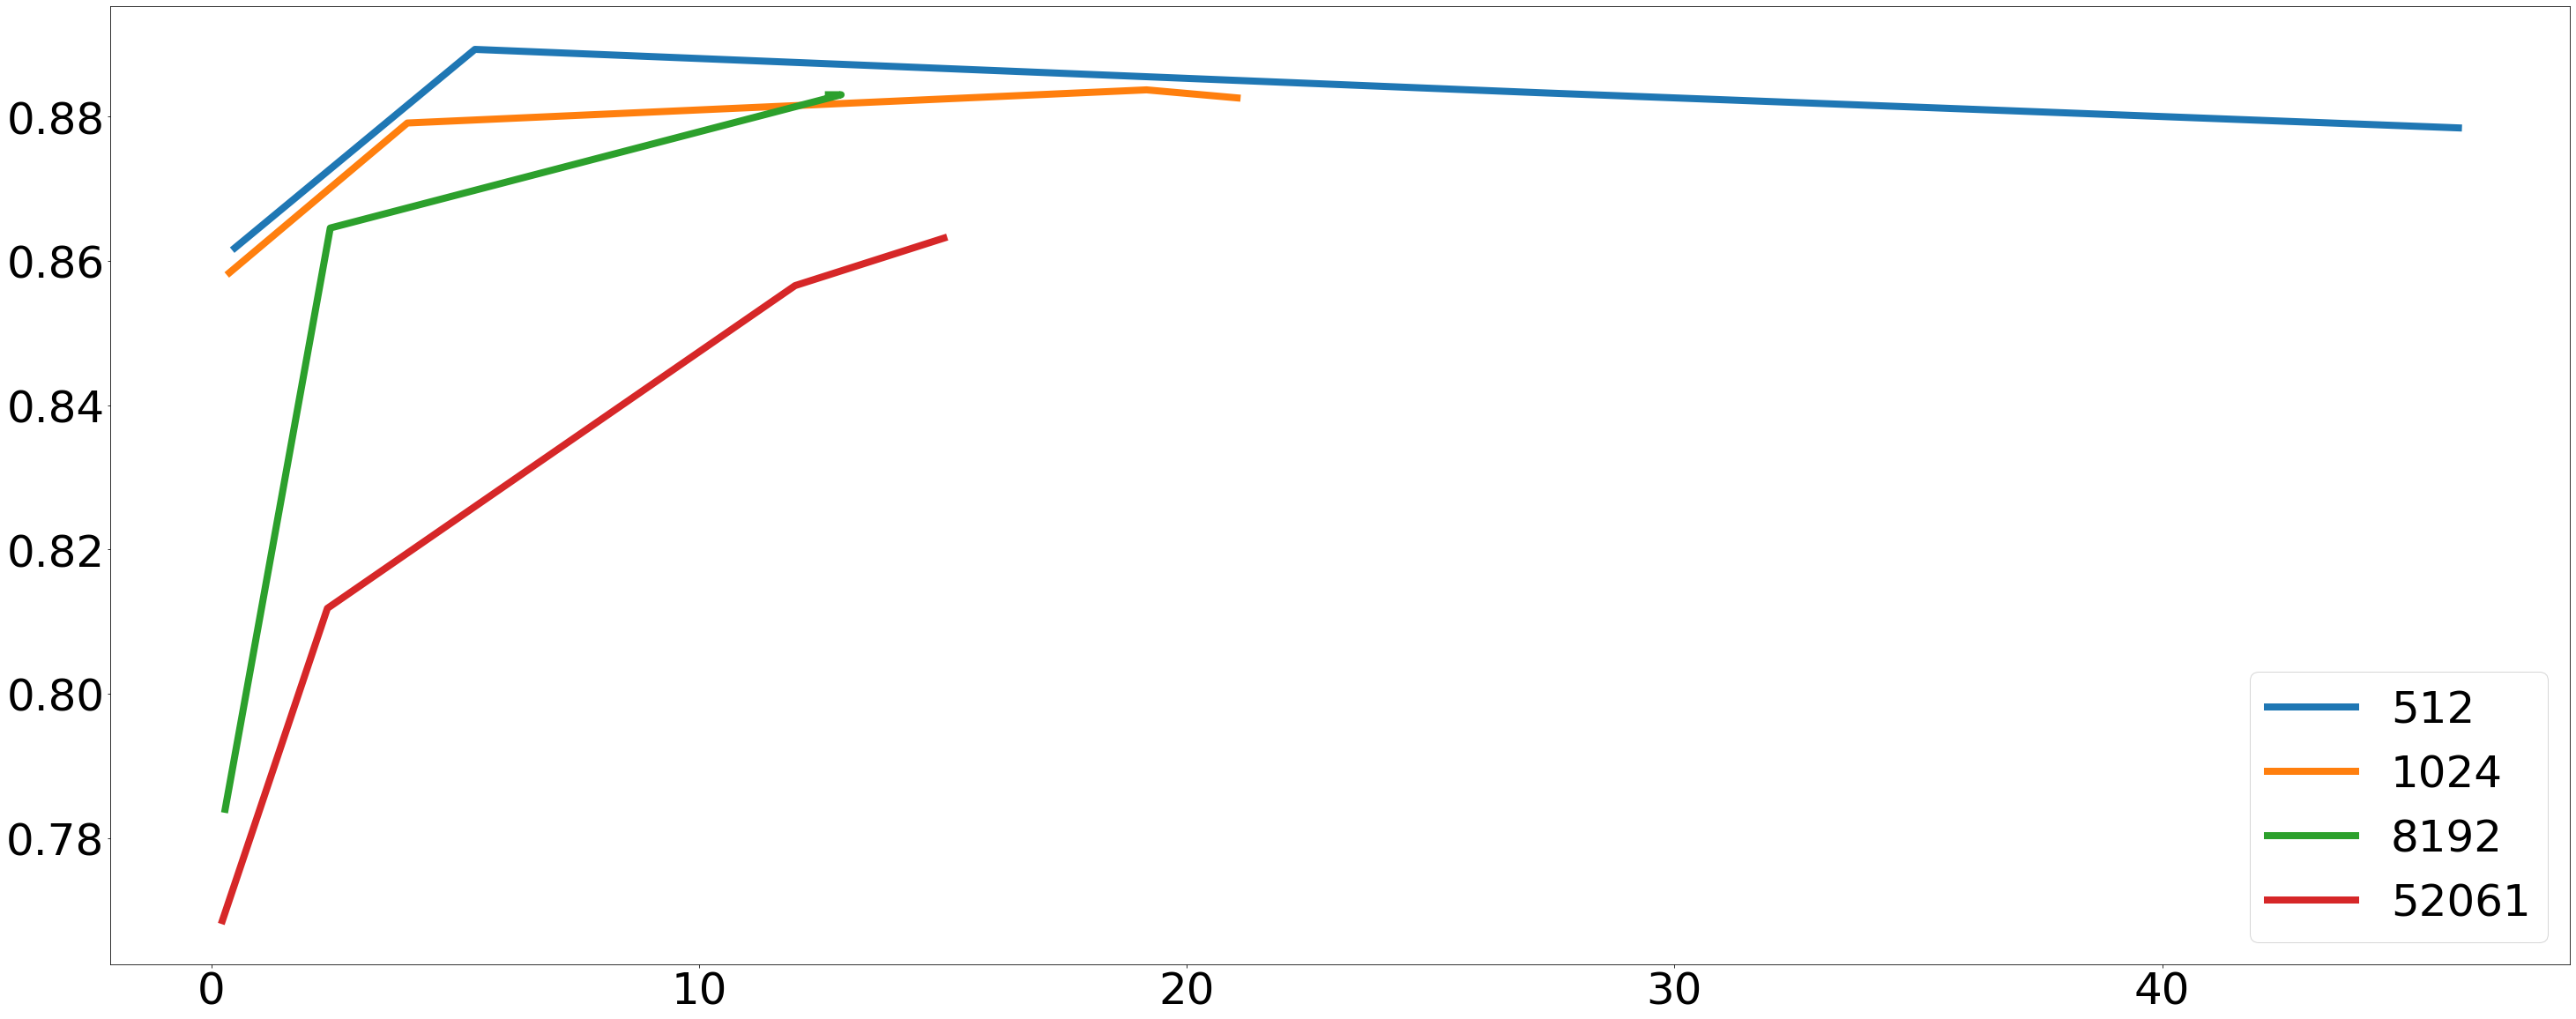

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=batch_sizes[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

In [0]:
batch_sizes = [512, 1024, 8192, X_train.shape[0]]
accuracy = []
iter_lst = []
for batch_size in batch_sizes:
    curr_accuracy = []
    curr_iter_lst = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=batch_size, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter_lst.append(len(oracle.history['func']))
    iter_lst.append(curr_iter_lst)
    accuracy.append(curr_accuracy)

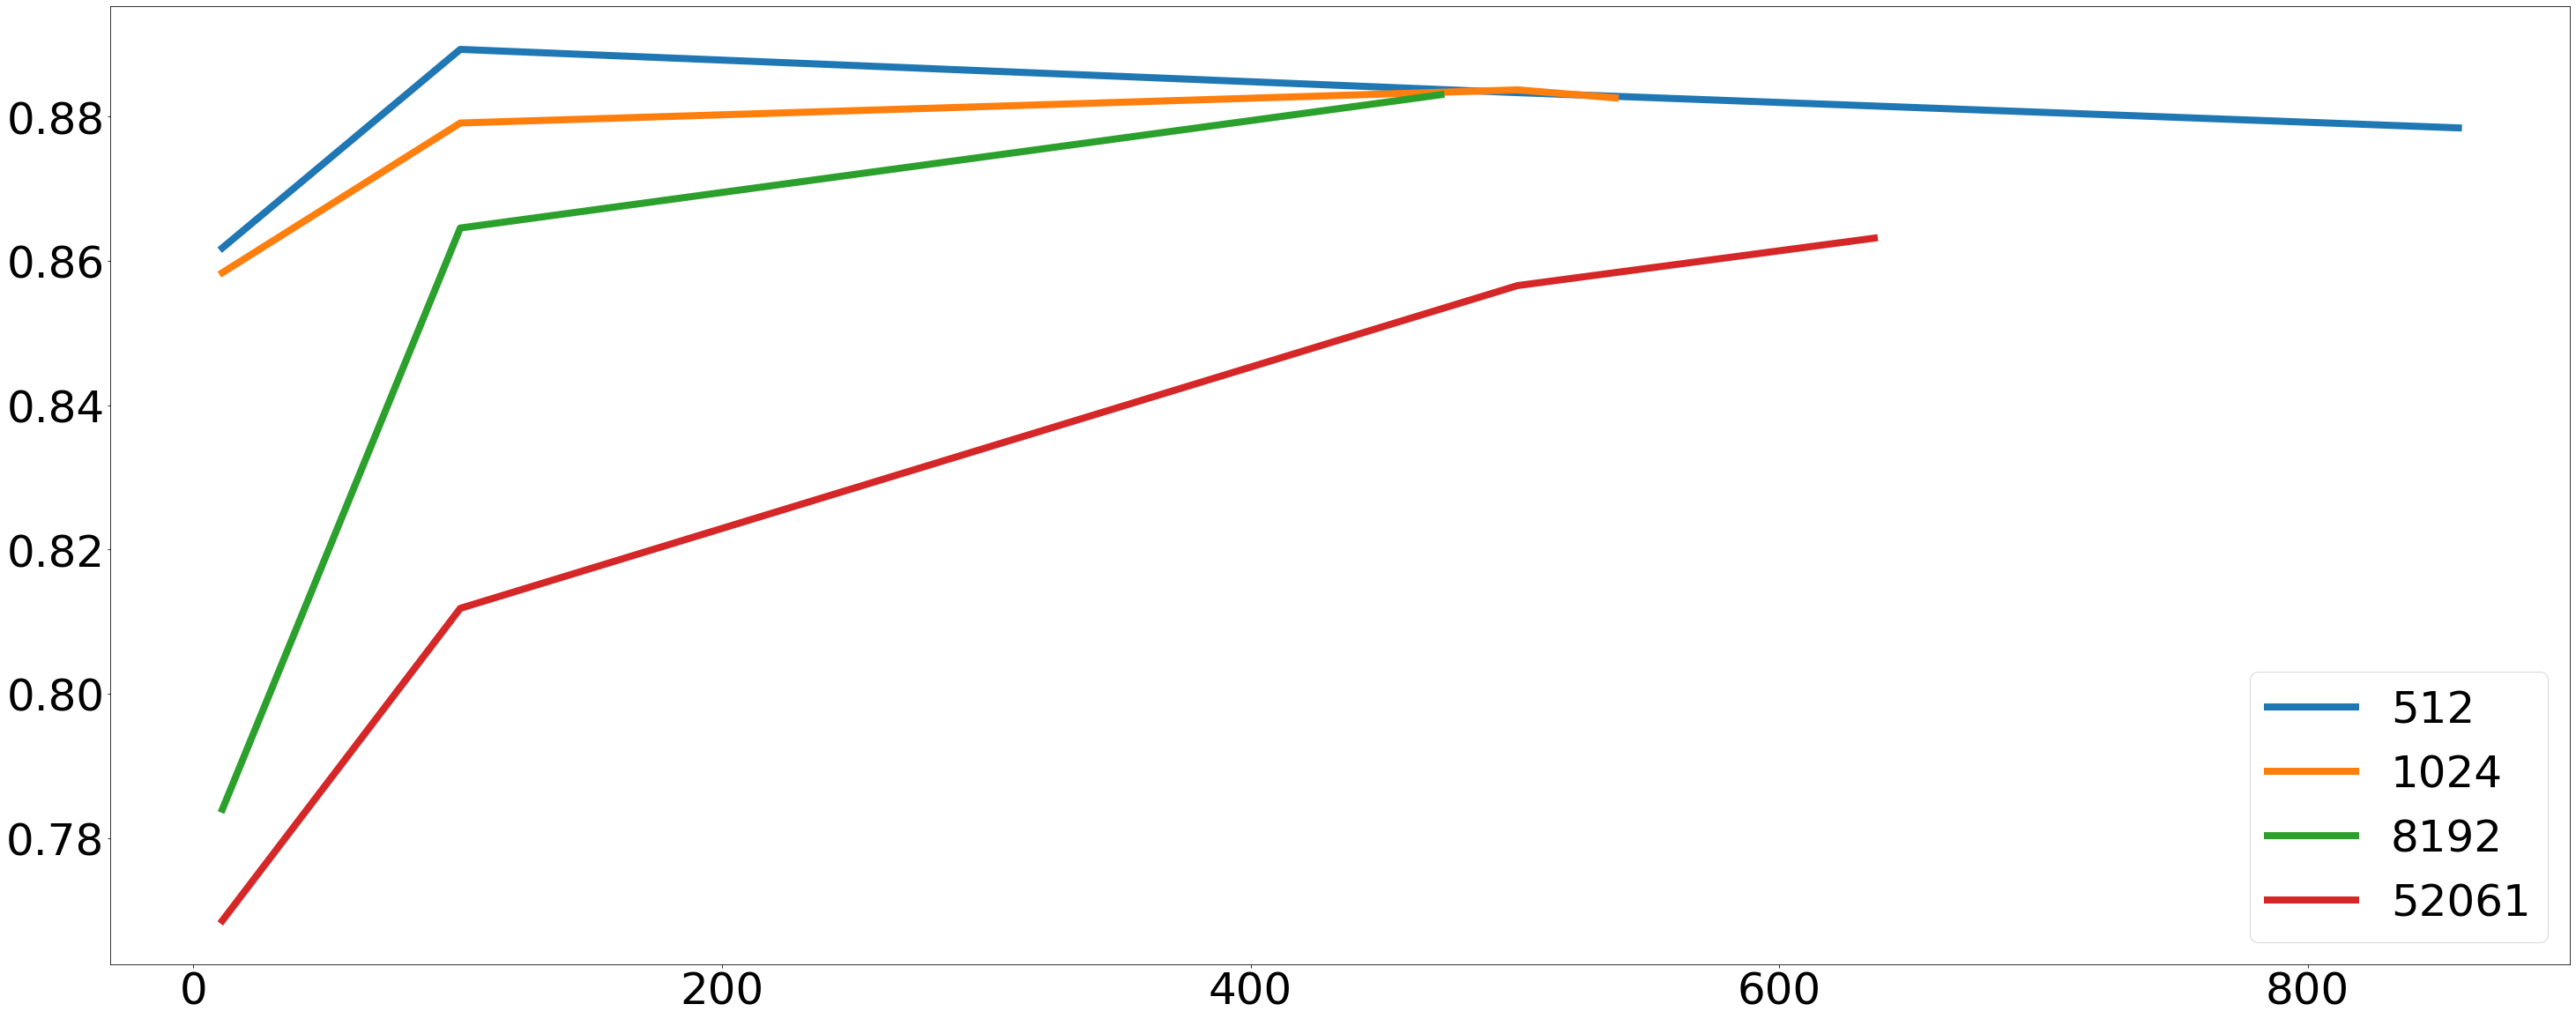

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=batch_sizes[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Поведение при batch_size = 512 достаточно необычное: accuracy даже убывает после достижения некоторого максимума. Кажется, что batch_size = 512 маловат и начинает идти не в ту сторону. В дальнейшем остановлюсь на batch_size = 8192.

In [0]:
import time
start = time.monotonic()
oracle = SGDClassifier(batch_size=1024, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
res = oracle.fit(X_train, y_train, trace=True)
finish = time.monotonic()
pred = oracle.predict(X_test)
score = (pred == y_test).sum() / y_test.shape[0]
print("batch_size: " + str(1024))
print("fit_time: " + str(finish - start))
print("accuracy: " + str(score))

batch_size: 1024
fit_time: 20.371399943018332
accuracy: 0.882617527568195


In [0]:
import time
start = time.monotonic()
oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
res = oracle.fit(X_train, y_train, trace=True)
finish = time.monotonic()
pred = oracle.predict(X_test)
score = (pred == y_test).sum() / y_test.shape[0]
print("batch_size: " + str(8192))
print("fit_time: " + str(finish - start))
print("accuracy: " + str(score))

batch_size: 8192
fit_time: 12.224503820005339
accuracy: 0.8830528148578062


Итого: в дальнейших экспериментах использую batch_size = 8192

step_alpha

Заранее скажу: по итогам экспериментов у меня не нашлось оснований брать что-то другое кроме step_alpha = 1.0, step_beta = 0.0. Кажется, что шаг надо выбирать автоматически в зависимости от изменения функционала (например, похожим образом делают в методе Рунге-Кутта). Заранее фиксированная формула не даст в общем случае лучшего результата.

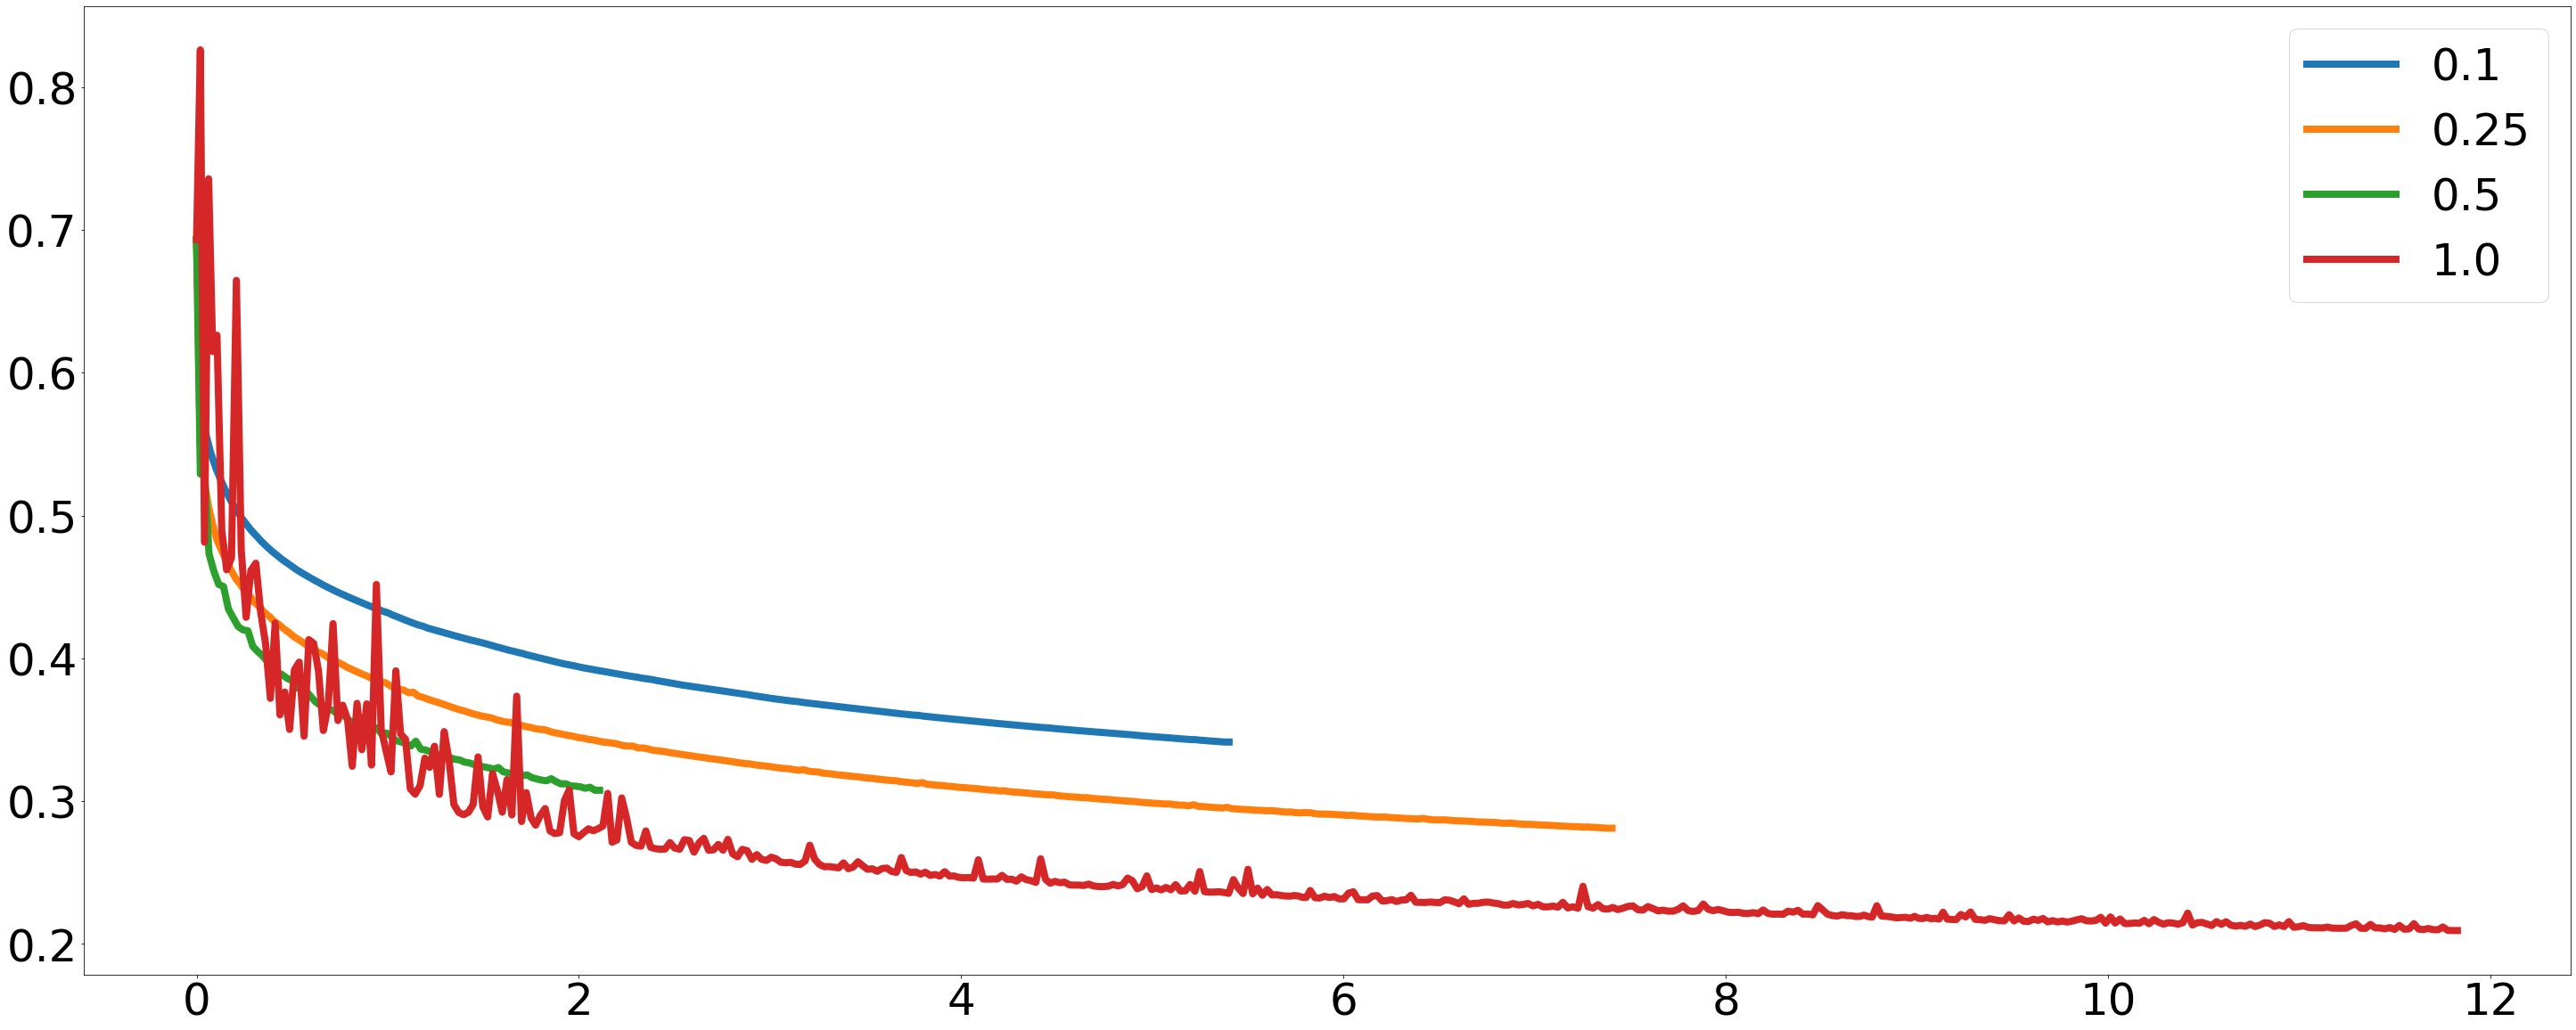

In [0]:
fig = plt.figure(figsize=(50, 20))
alphas = [0.1, 0.25, 0.5, 1.0]
for alpha in alphas:
    oracle = SGDClassifier(batch_size=8192, step_alpha=alpha, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=alpha)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

График зависимости значения функции потерь от итерации метода

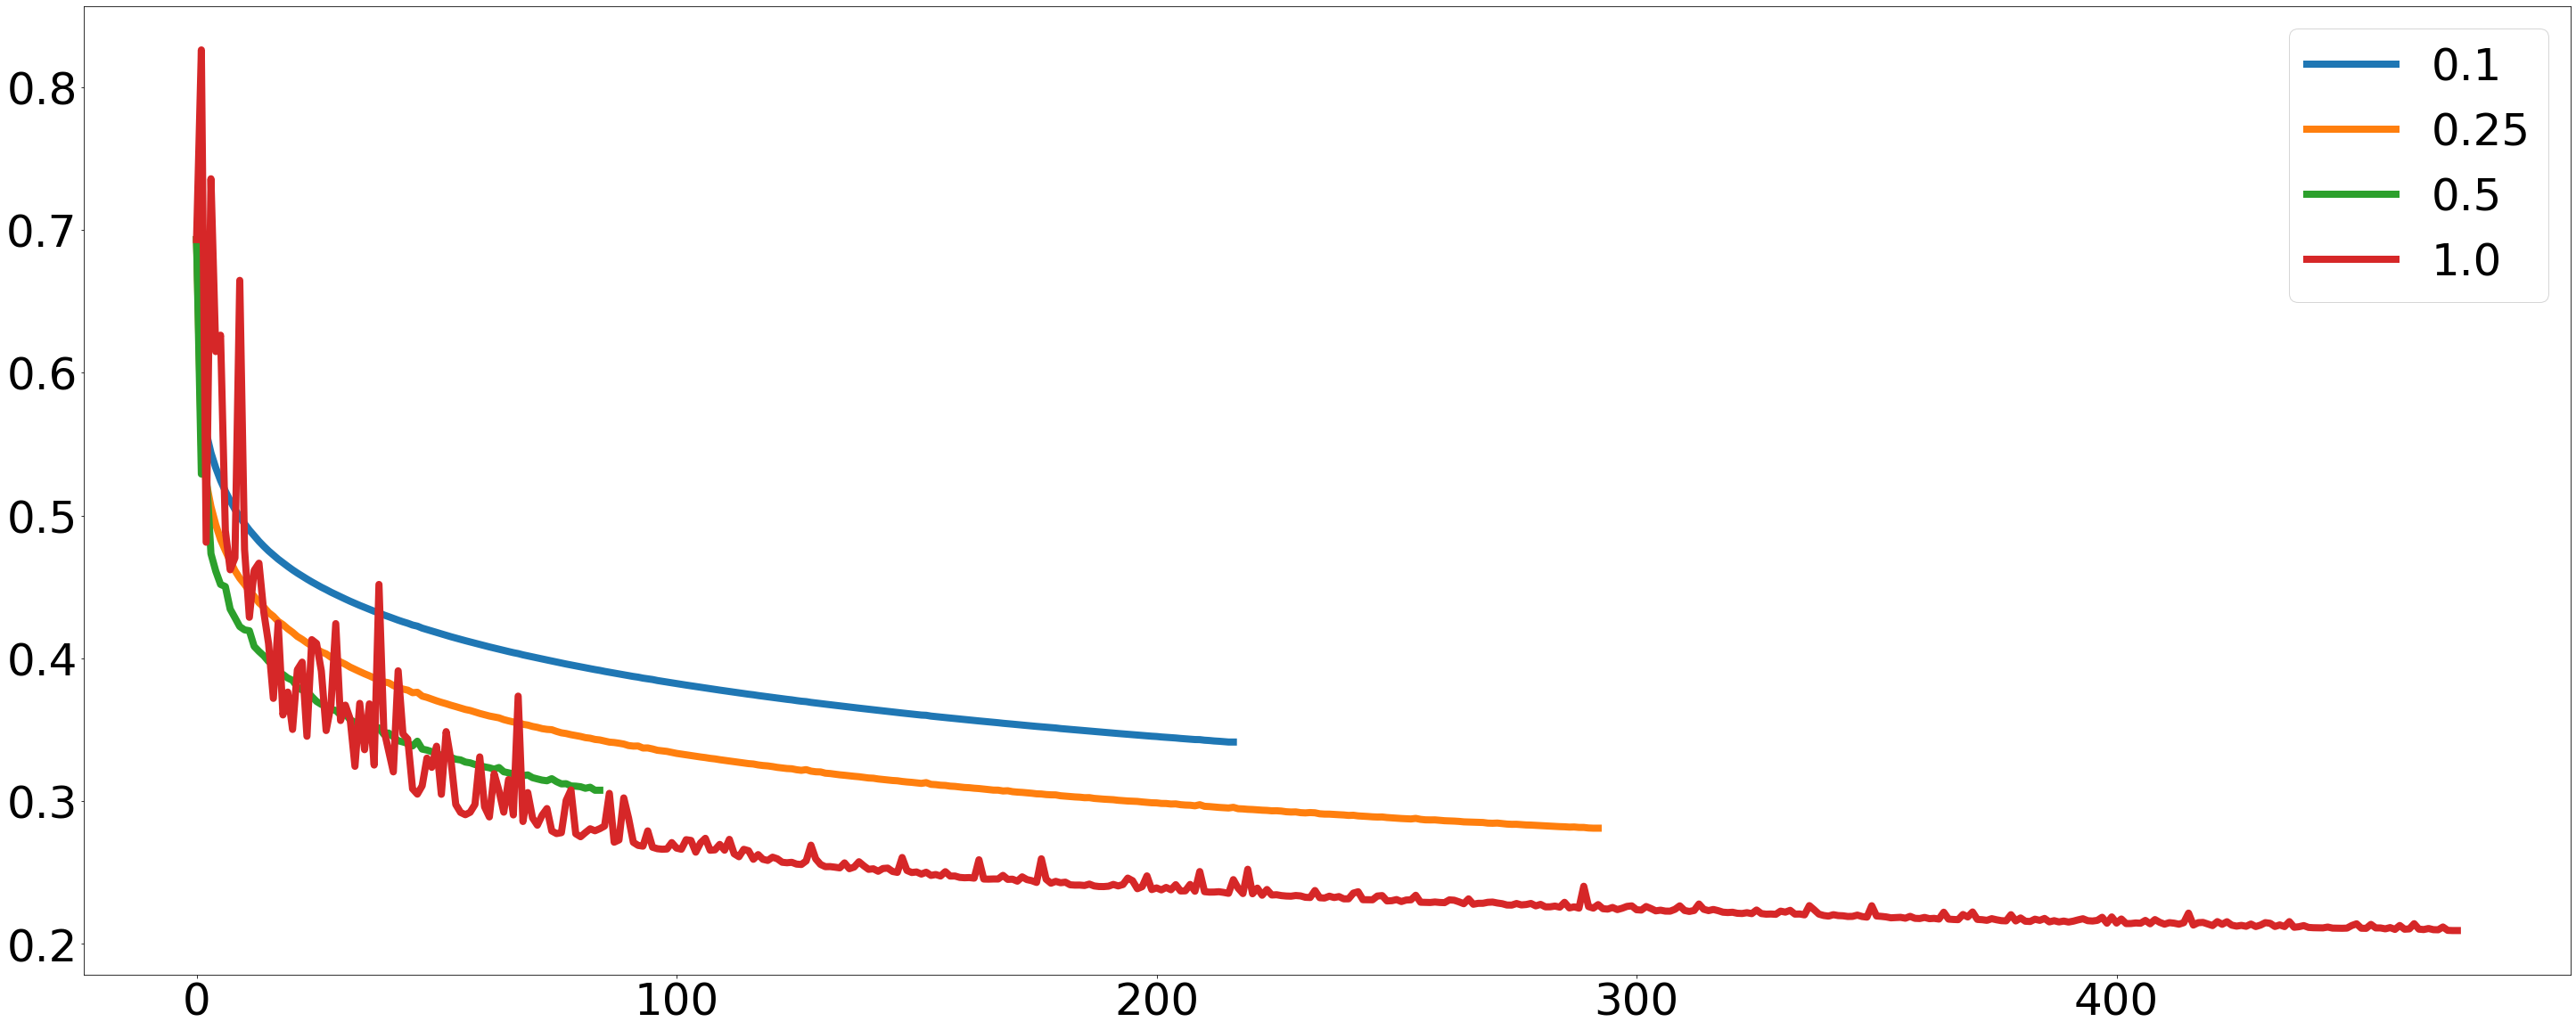

In [0]:
fig = plt.figure(figsize=(50, 20))
alphas = [0.1, 0.25, 0.5, 1.0]
for alpha in alphas:
    oracle = SGDClassifier(batch_size=8192, step_alpha=alpha, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    plt.plot(oracle.history['func'], lw = 8, label=alpha)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Итог в плане минимизации функционала step_alpha = 1.0 даёт наилучший результат (в обычном спуске такого однозначного эффекта не было)

Зависимость точности от реального времени работы метода

In [0]:
alphas = [0.1, 0.25, 0.5, 1.0]
accuracy = []
time_lst = []
for alpha in alphas:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=8192, step_alpha=alpha, step_beta=0.0, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

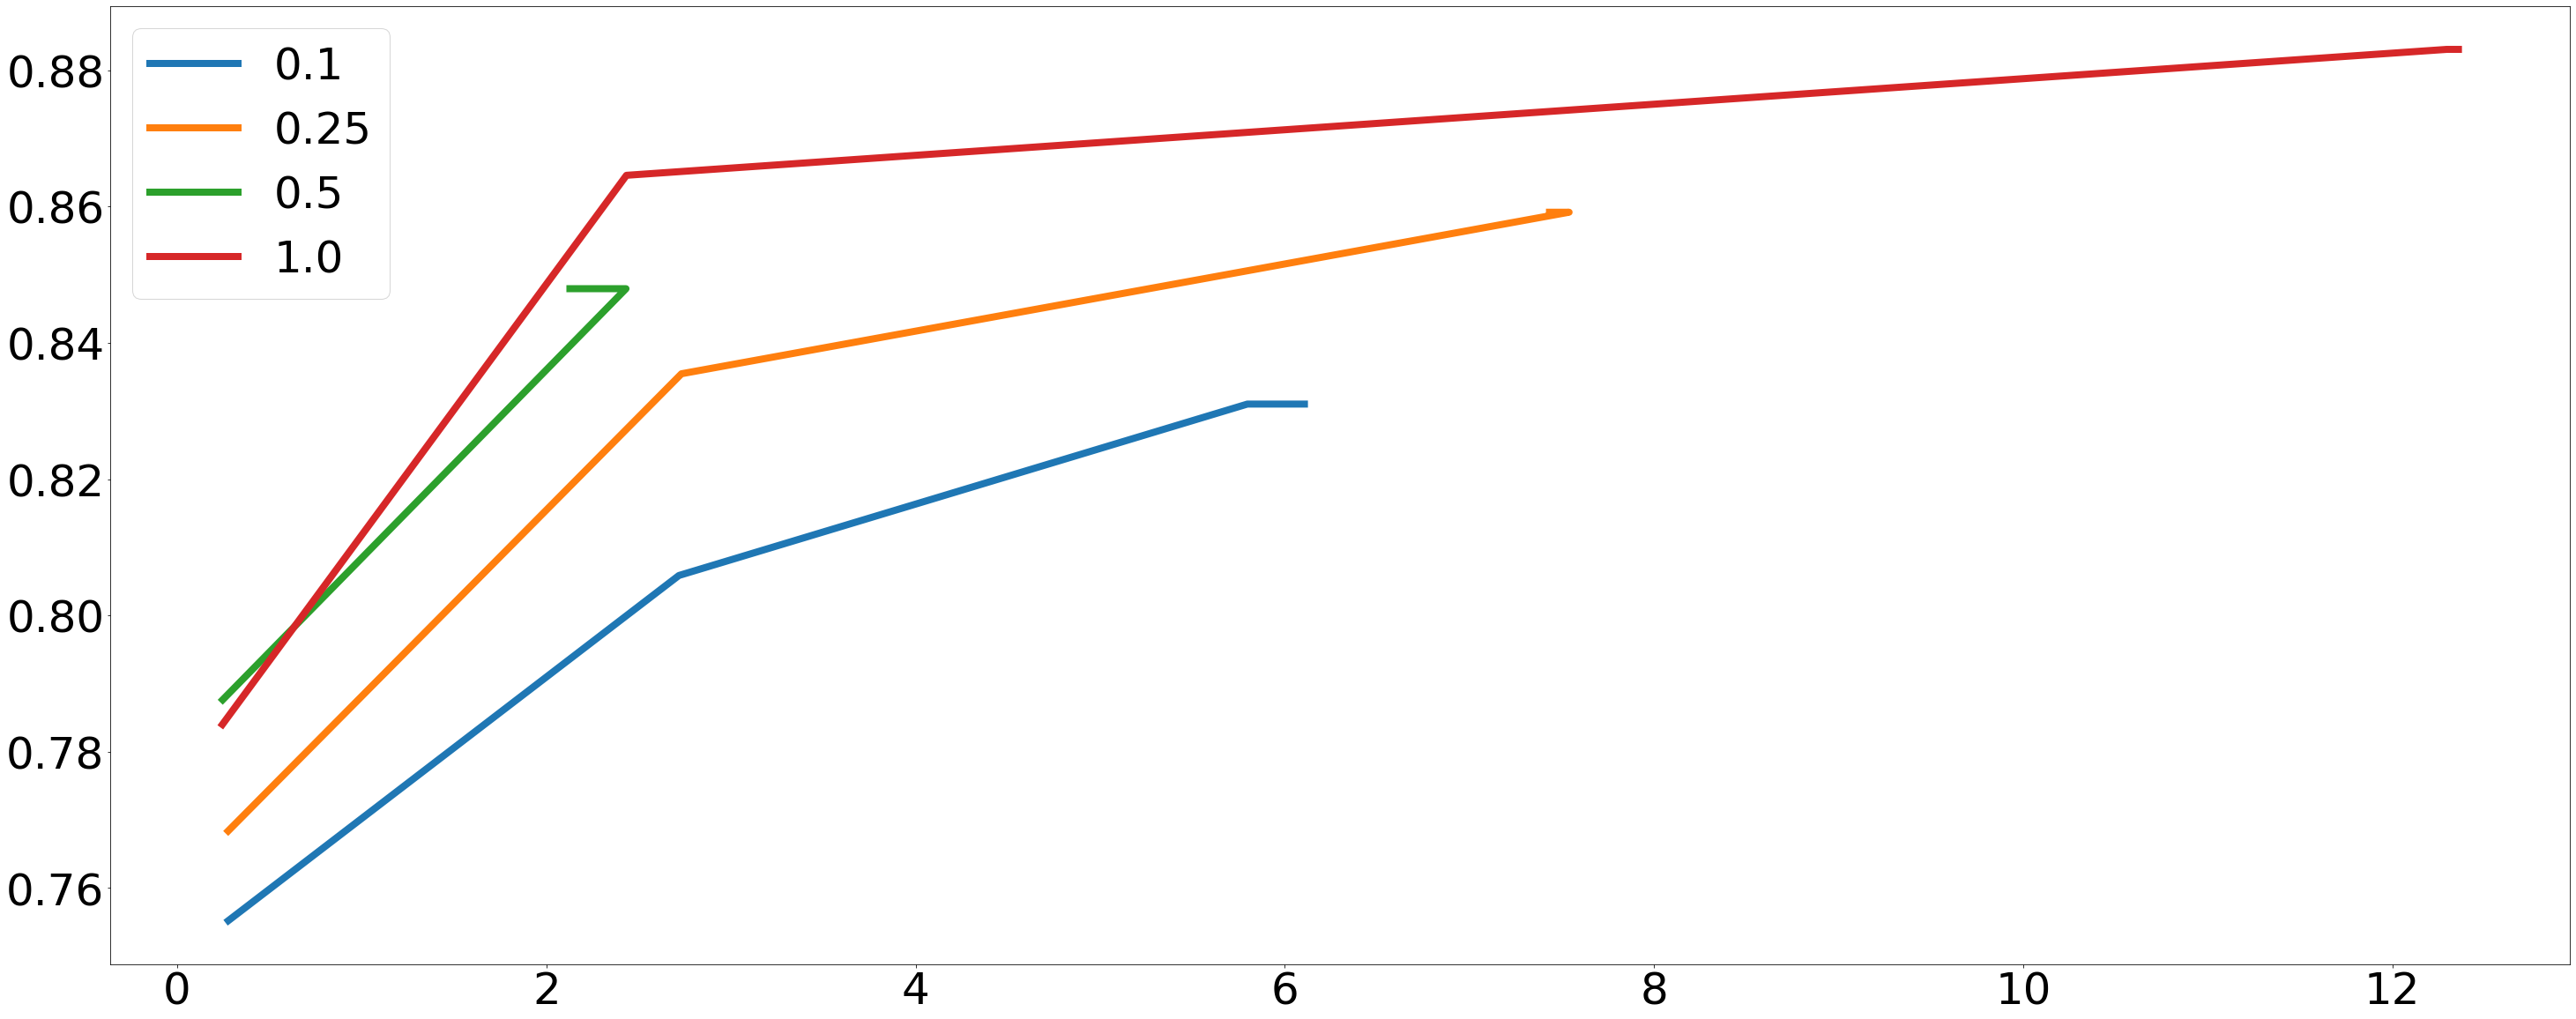

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=alphas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

In [0]:
alphas = [0.1, 0.25, 0.5, 1.0]
accuracy = []
iter_lst = []
for alpha in alphas:
    curr_accuracy = []
    curr_iter_lst = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=8192, step_alpha=alpha, step_beta=0.0, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter_lst.append(len(oracle.history['func']))
    iter_lst.append(curr_iter_lst)
    accuracy.append(curr_accuracy)

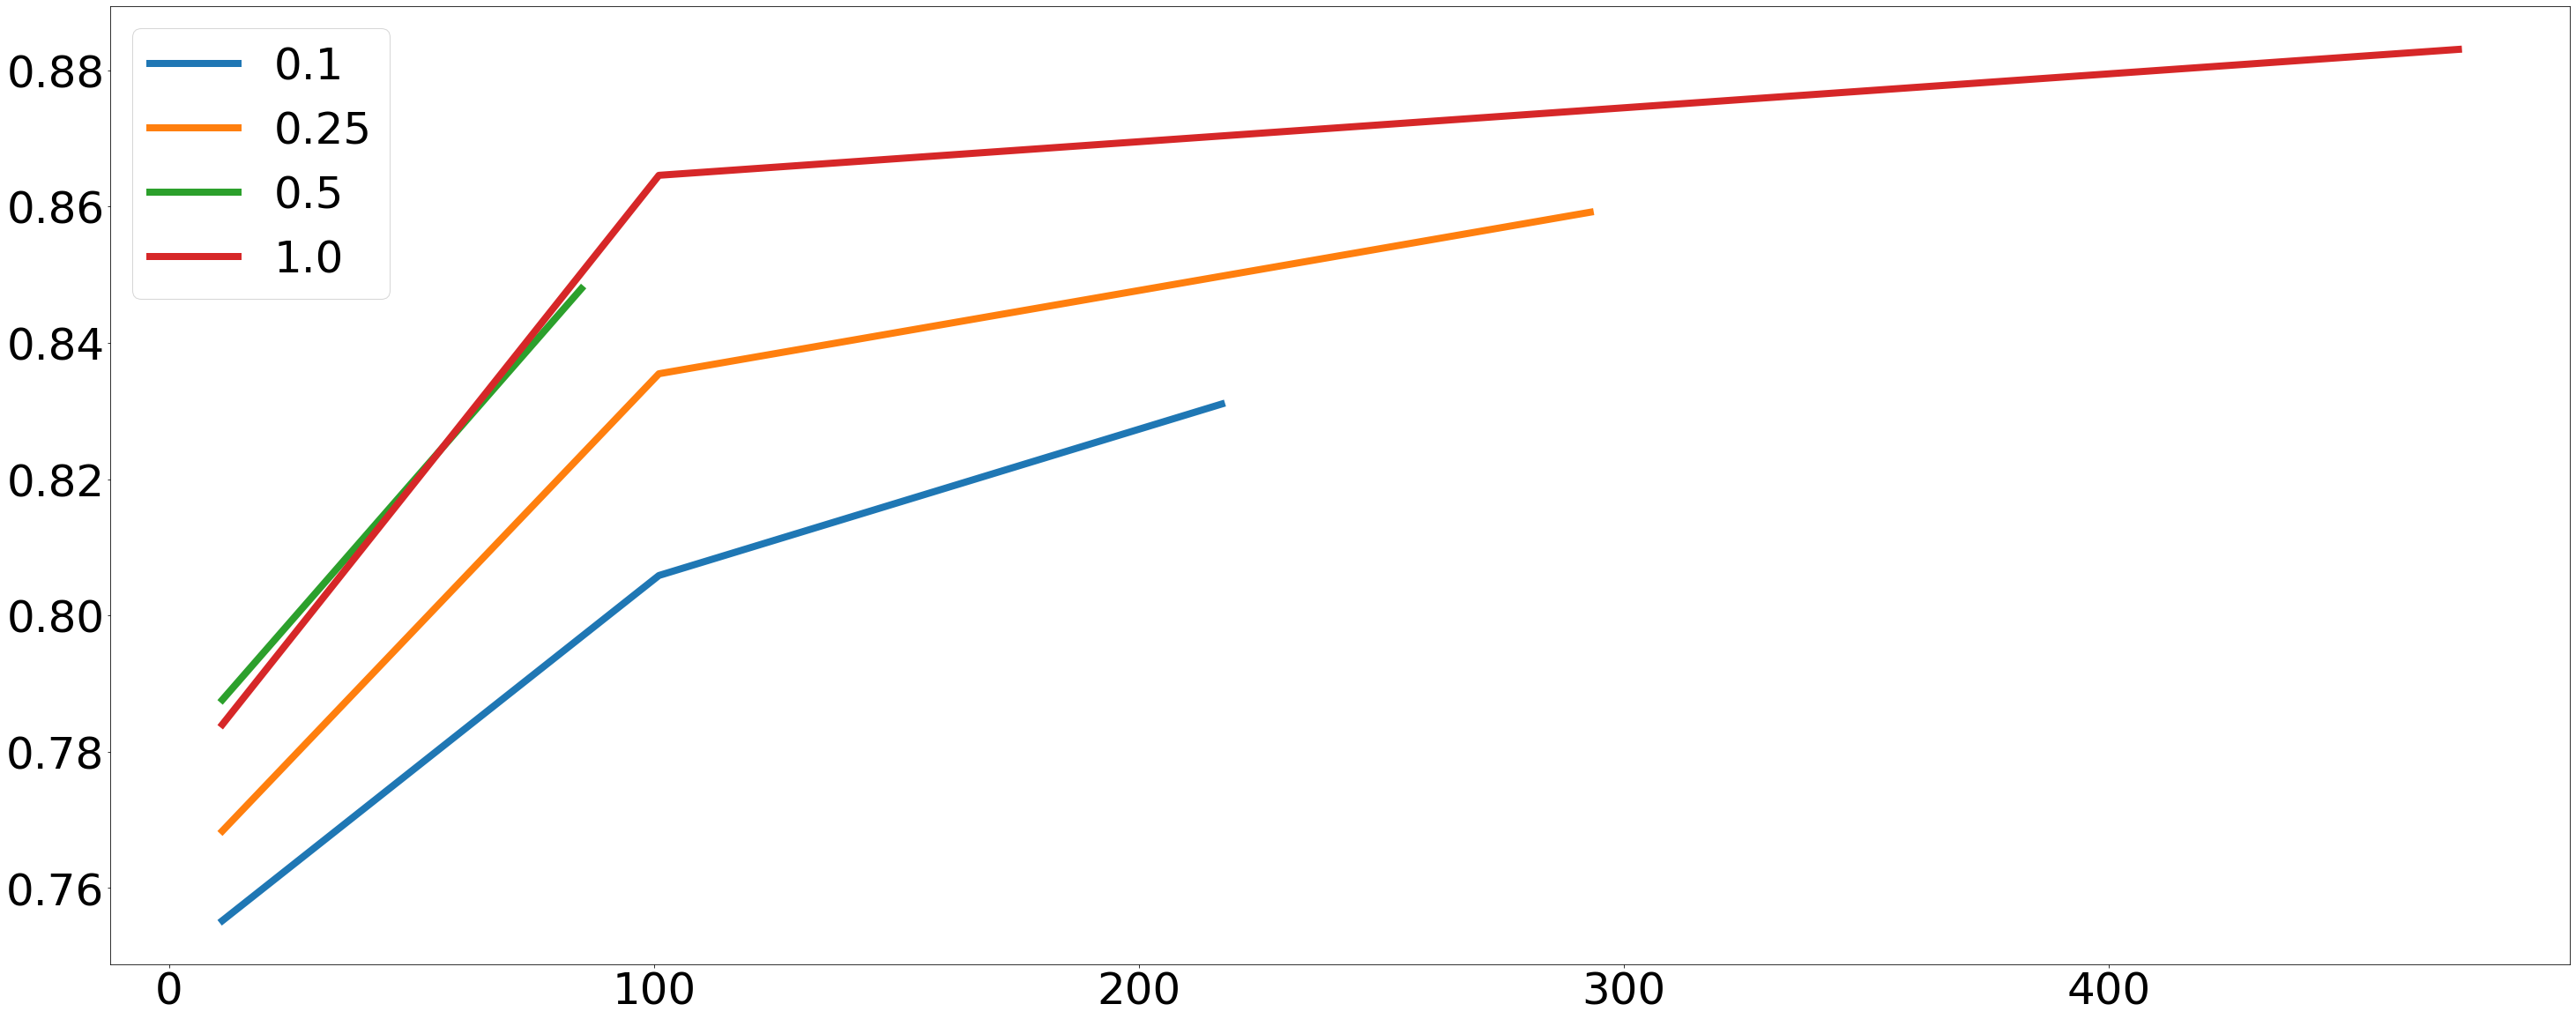

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(iter_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=alphas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

step_alpha = 1.0 показывает лучший результат. Рассуждения аналогичны обычному градиентном у спуску. + из-за более случайного выбора направления стохасический градиентный спуск приближается ближе к оптимуму (примерно 0.2 значение функционала против 0.3 для обычного)

step_beta

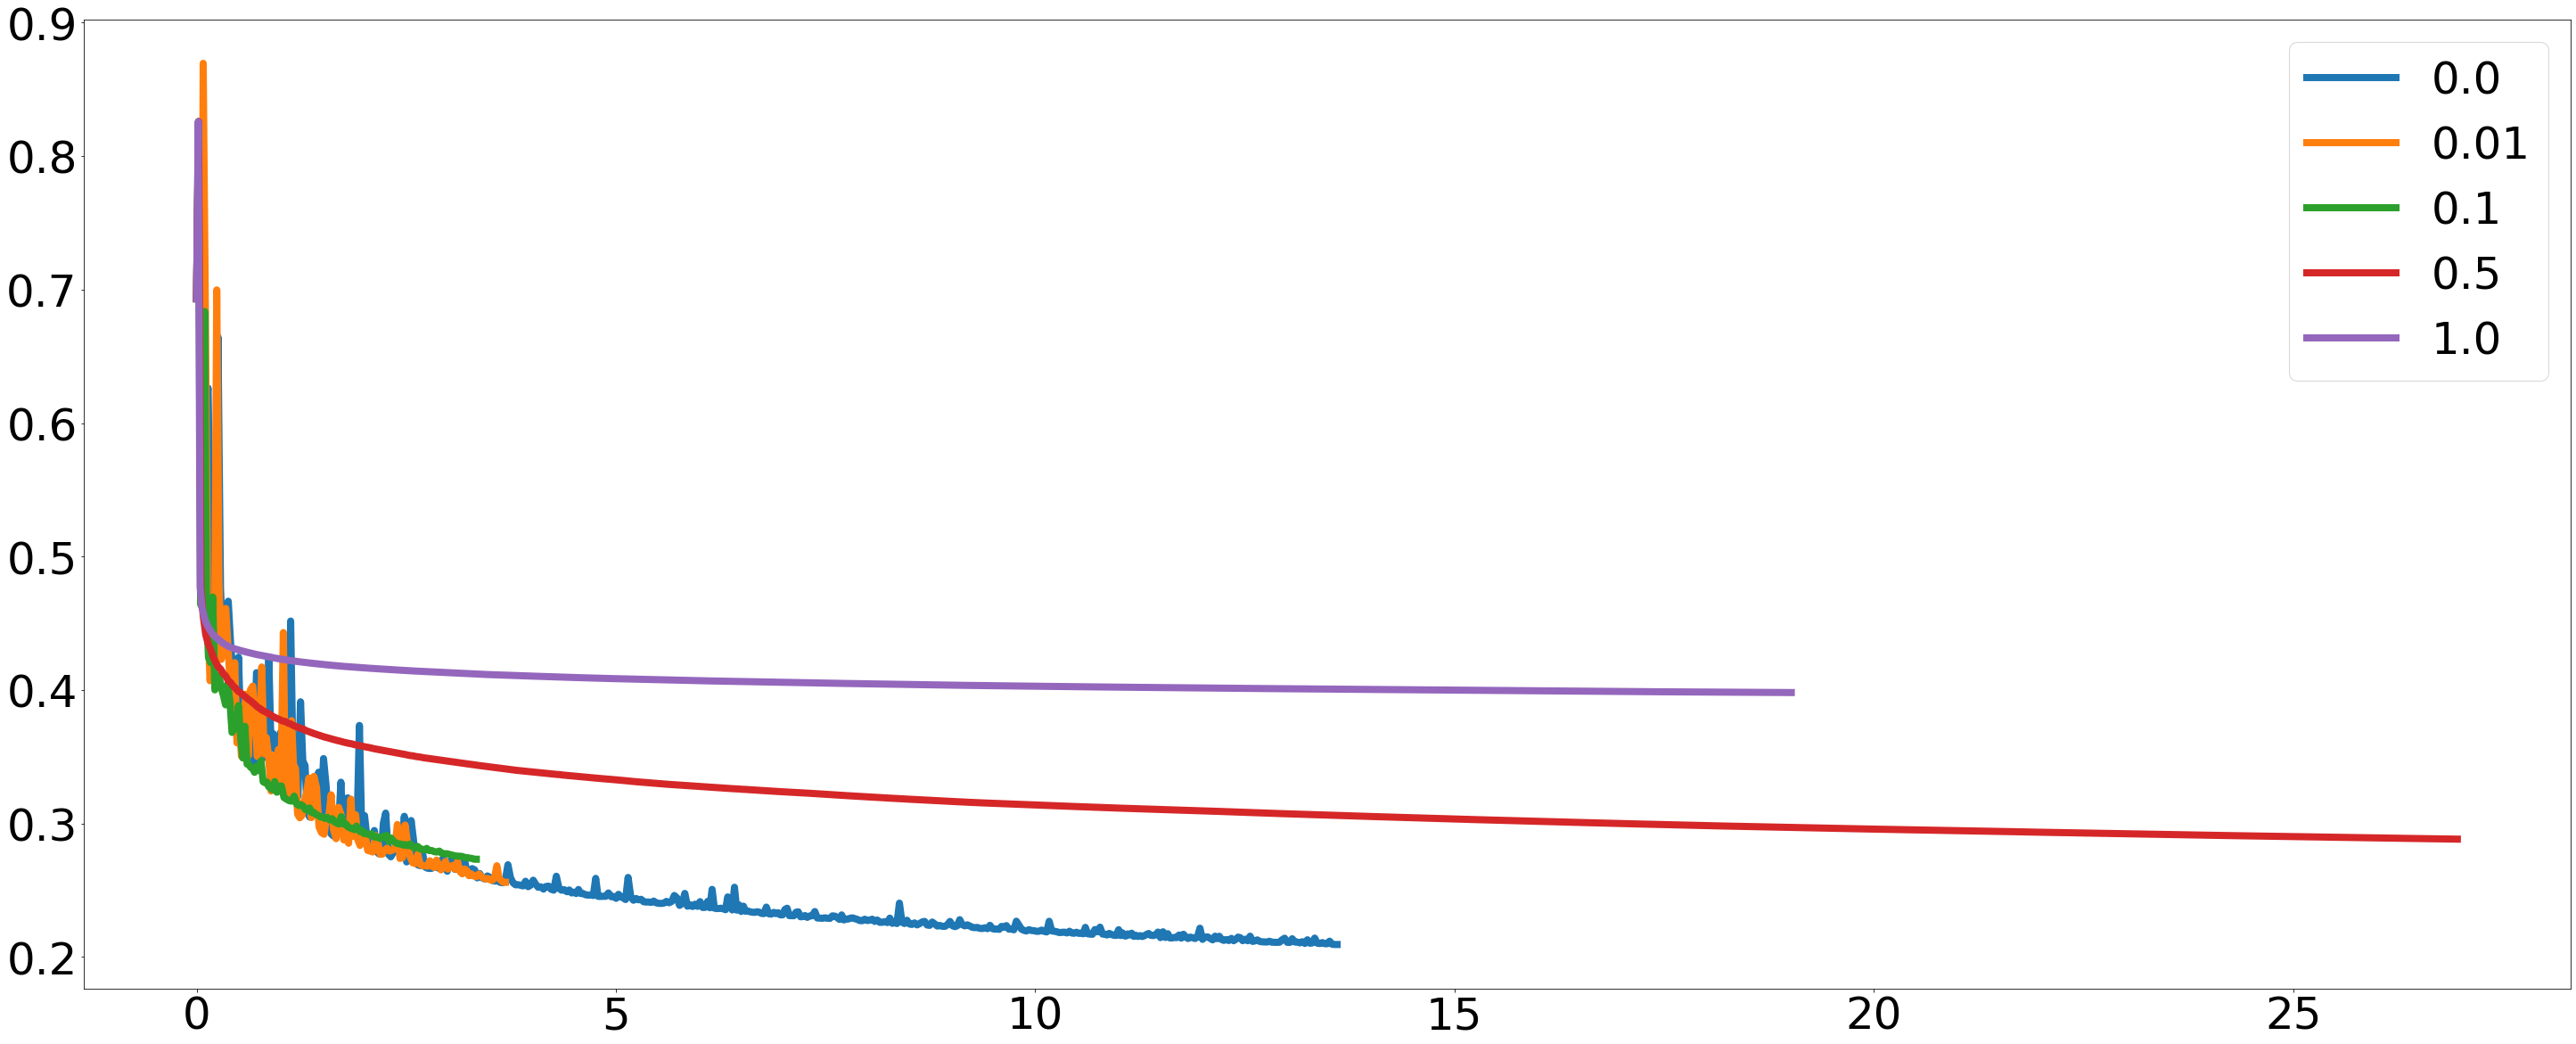

In [0]:
fig = plt.figure(figsize=(50, 20))
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
for beta in betas:
    oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=beta, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=beta)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

График зависимости значения функции потерь от итерации метода

In [0]:
fig = plt.figure(figsize=(50, 20))
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
for beta in betas:
    oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=beta, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True)
    plt.plot(oracle.history['func'], lw = 8, label=beta)
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Итог в плане минимизации функционала step_alpha = 1.0 даёт наилучший результат (в обычном спуске такого однозначного эффекта не было)

Зависимость точности от реального времени работы метода

In [0]:
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
accuracy = []
time_lst = []
for beta in betas:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=beta, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

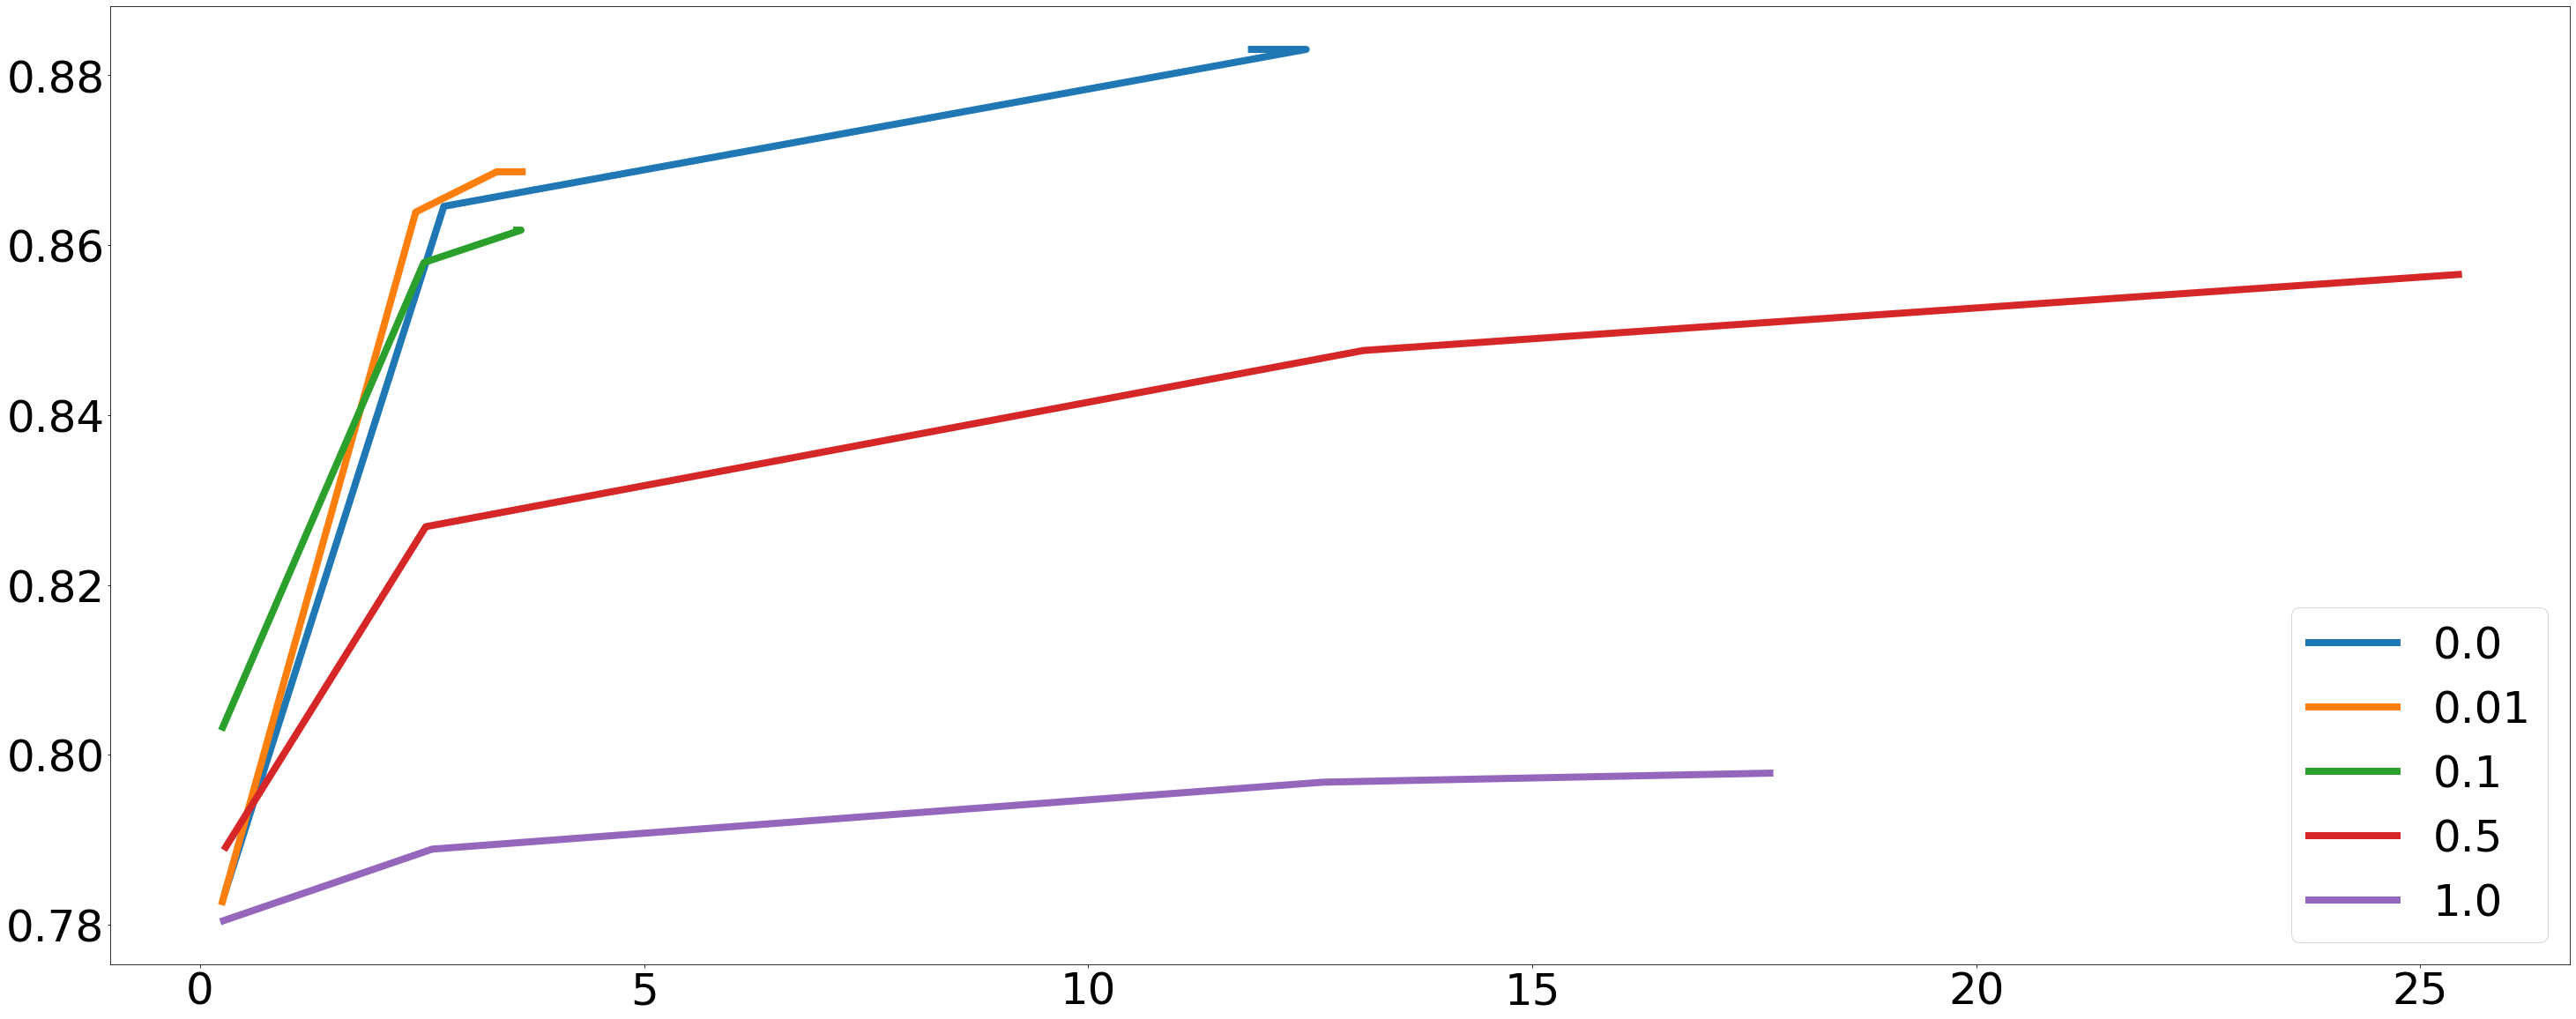

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=betas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

In [0]:
betas = [0.0, 0.01, 0.1, 0.5, 1.0]
accuracy = []
iter_lst = []
for beta in betas:
    curr_accuracy = []
    curr_iter_lst = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=beta, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter_lst.append(len(oracle.history['func']))
    iter_lst.append(curr_iter_lst)
    accuracy.append(curr_accuracy)

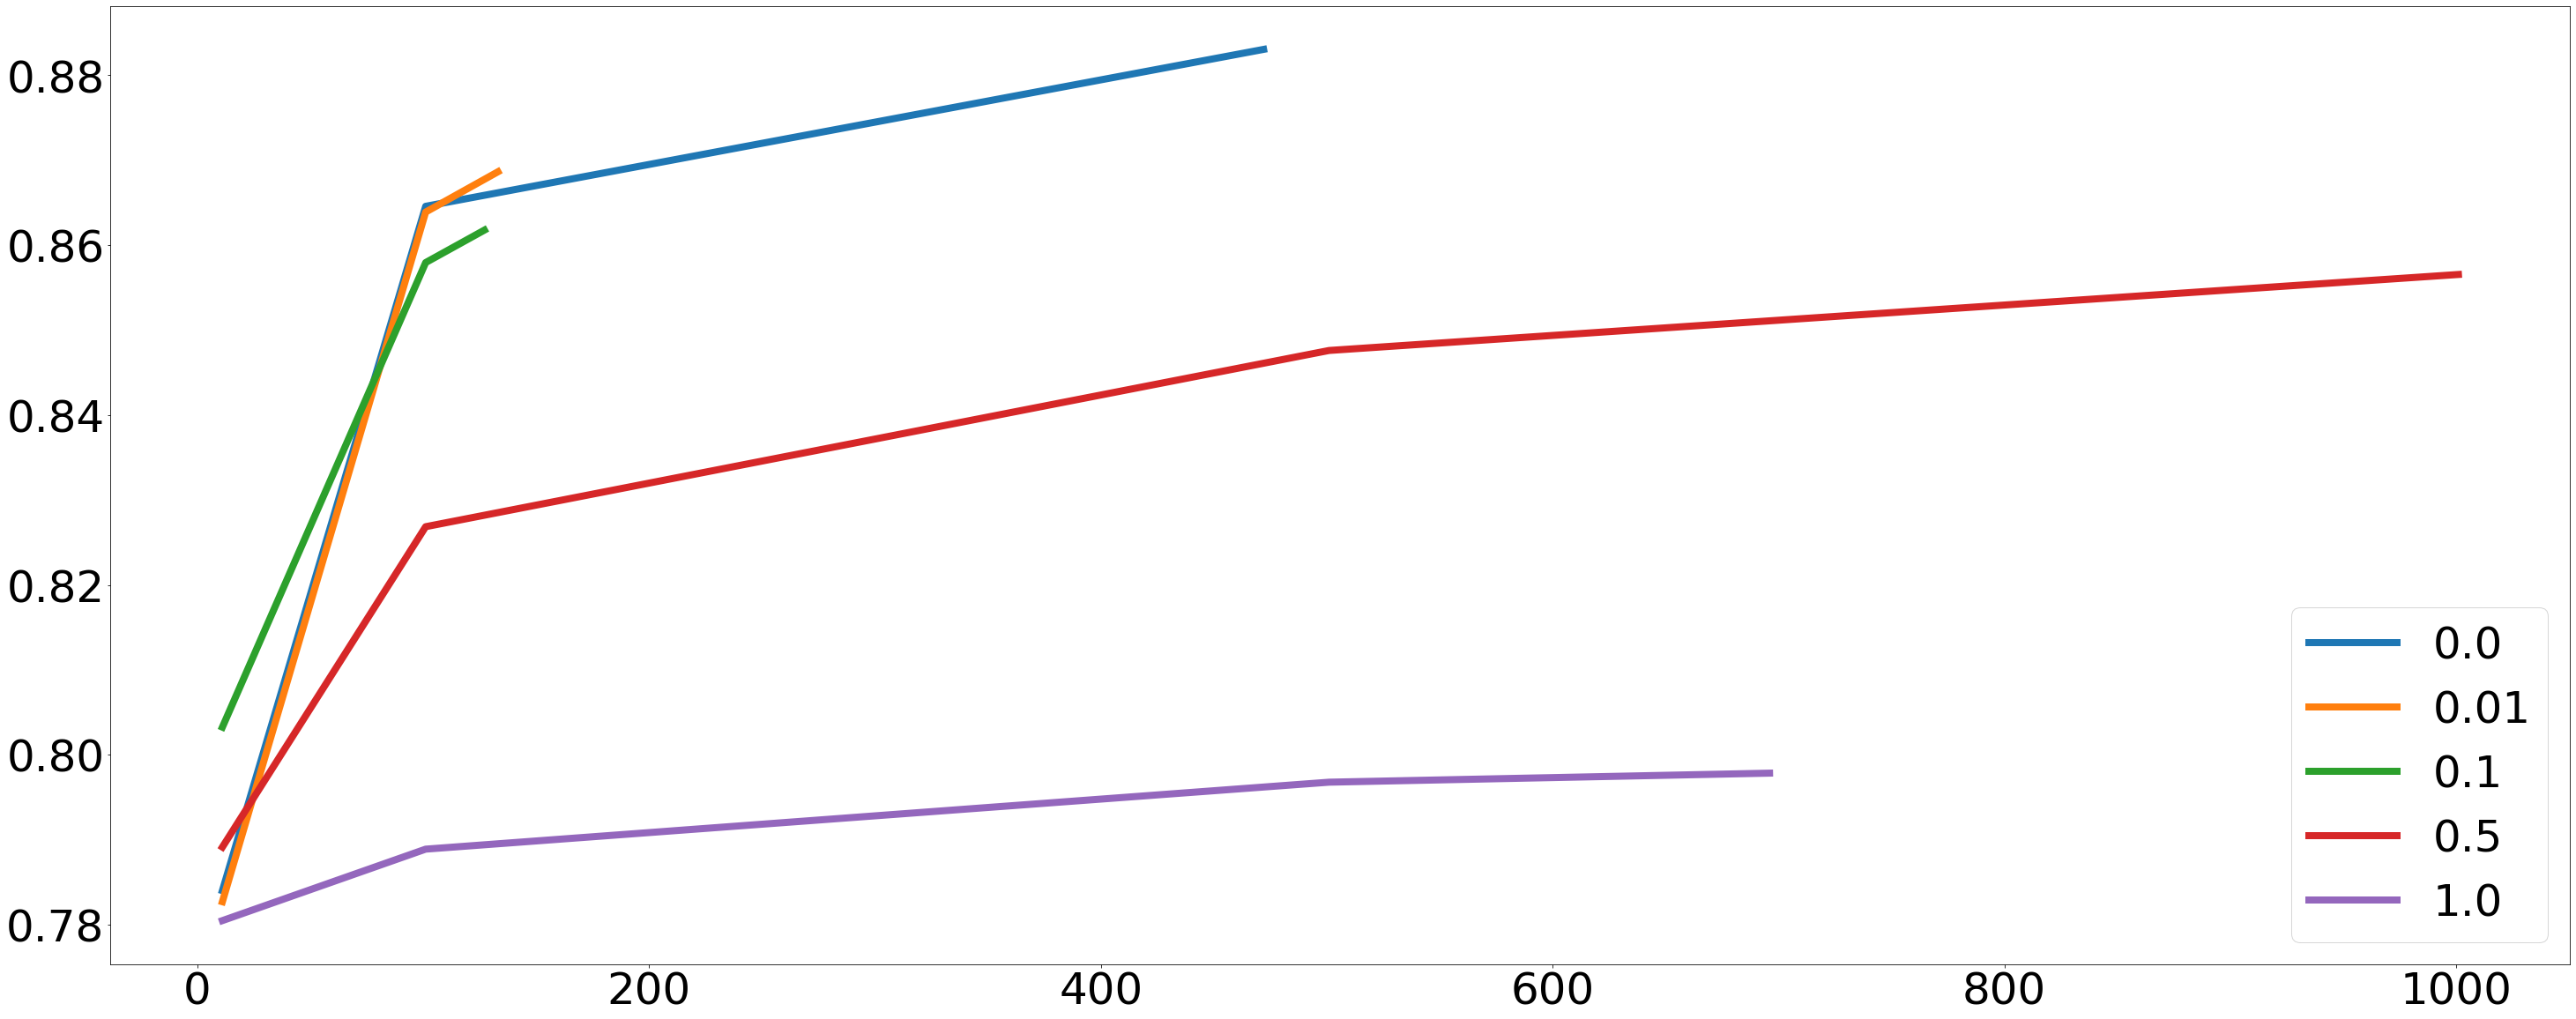

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=betas[i])
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Видно, что beta=0.0 показывает лучший результат.

Начальное приближение

Приведу все 4 графика (первые 2 не очень показательны из-за выбросов в начальной точке). Вывод под графиками.

In [0]:
oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
res = oracle.fit(X_train, y_train, trace=True)
original = oracle.get_weights()

Зависимость функционала от времени работы

In [0]:
fig = plt.figure(figsize=(50, 20))
weights = ([np.zeros(X_train.shape[1])] + [original]
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
for w_0 in weights:
    oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True, w_0=w_0)
    time_lst = []
    for i in range(len(oracle.history['time'])):
        time_lst.append(sum(oracle.history['time'][:i+1]))
    plt.plot(time_lst, oracle.history['func'], lw = 8, label=norm(w_0))
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость функционала от числа итераци

In [0]:
fig = plt.figure(figsize=(50, 20))
weights = ([np.zeros(X_train.shape[1])] + [original]
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
for w_0 in weights:
    oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    res = oracle.fit(X_train, y_train, trace=True, w_0=w_0)
    plt.plot(oracle.history['func'], lw = 8, label=norm(w_0))
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от реального времени работы метода

In [0]:
weights = ([np.zeros(X_train.shape[1])] + [original]
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
accuracy = []
time_lst = []
for w_0 in weights:
    curr_accuracy = []
    curr_time = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True, w_0=w_0)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_time.append(sum(oracle.history['time']))
    time_lst.append(curr_time)
    accuracy.append(curr_accuracy)

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(time_lst)):
        plt.plot(time_lst[i], accuracy[i], lw = 8, label=norm(weights[i]))
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Зависимость точности от итерации метода

In [0]:
weights = ([np.zeros(X_train.shape[1])] + [original]
           + [np.random.random(X_train.shape[1]) for i in range(3)] 
           + [(np.random.random(X_train.shape[1]) - 0.5) for i in range(3)])
accuracy = []
iter_lst = []
for w_0 in weights:
    curr_accuracy = []
    curr_iter_lst = []
    for max_iter in (10, 100, 500, 1000):
        oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=max_iter, random_seed=3153, l_2_coef=0.0)
        res = oracle.fit(X_train, y_train, trace=True, w_0=w_0)
        pred = oracle.predict(X_test)
        score = (pred == y_test).sum() / y_test.shape[0]
        curr_accuracy.append(score)
        curr_iter_lst.append(len(oracle.history['func']))
    iter_lst.append(curr_iter_lst)
    accuracy.append(curr_accuracy)

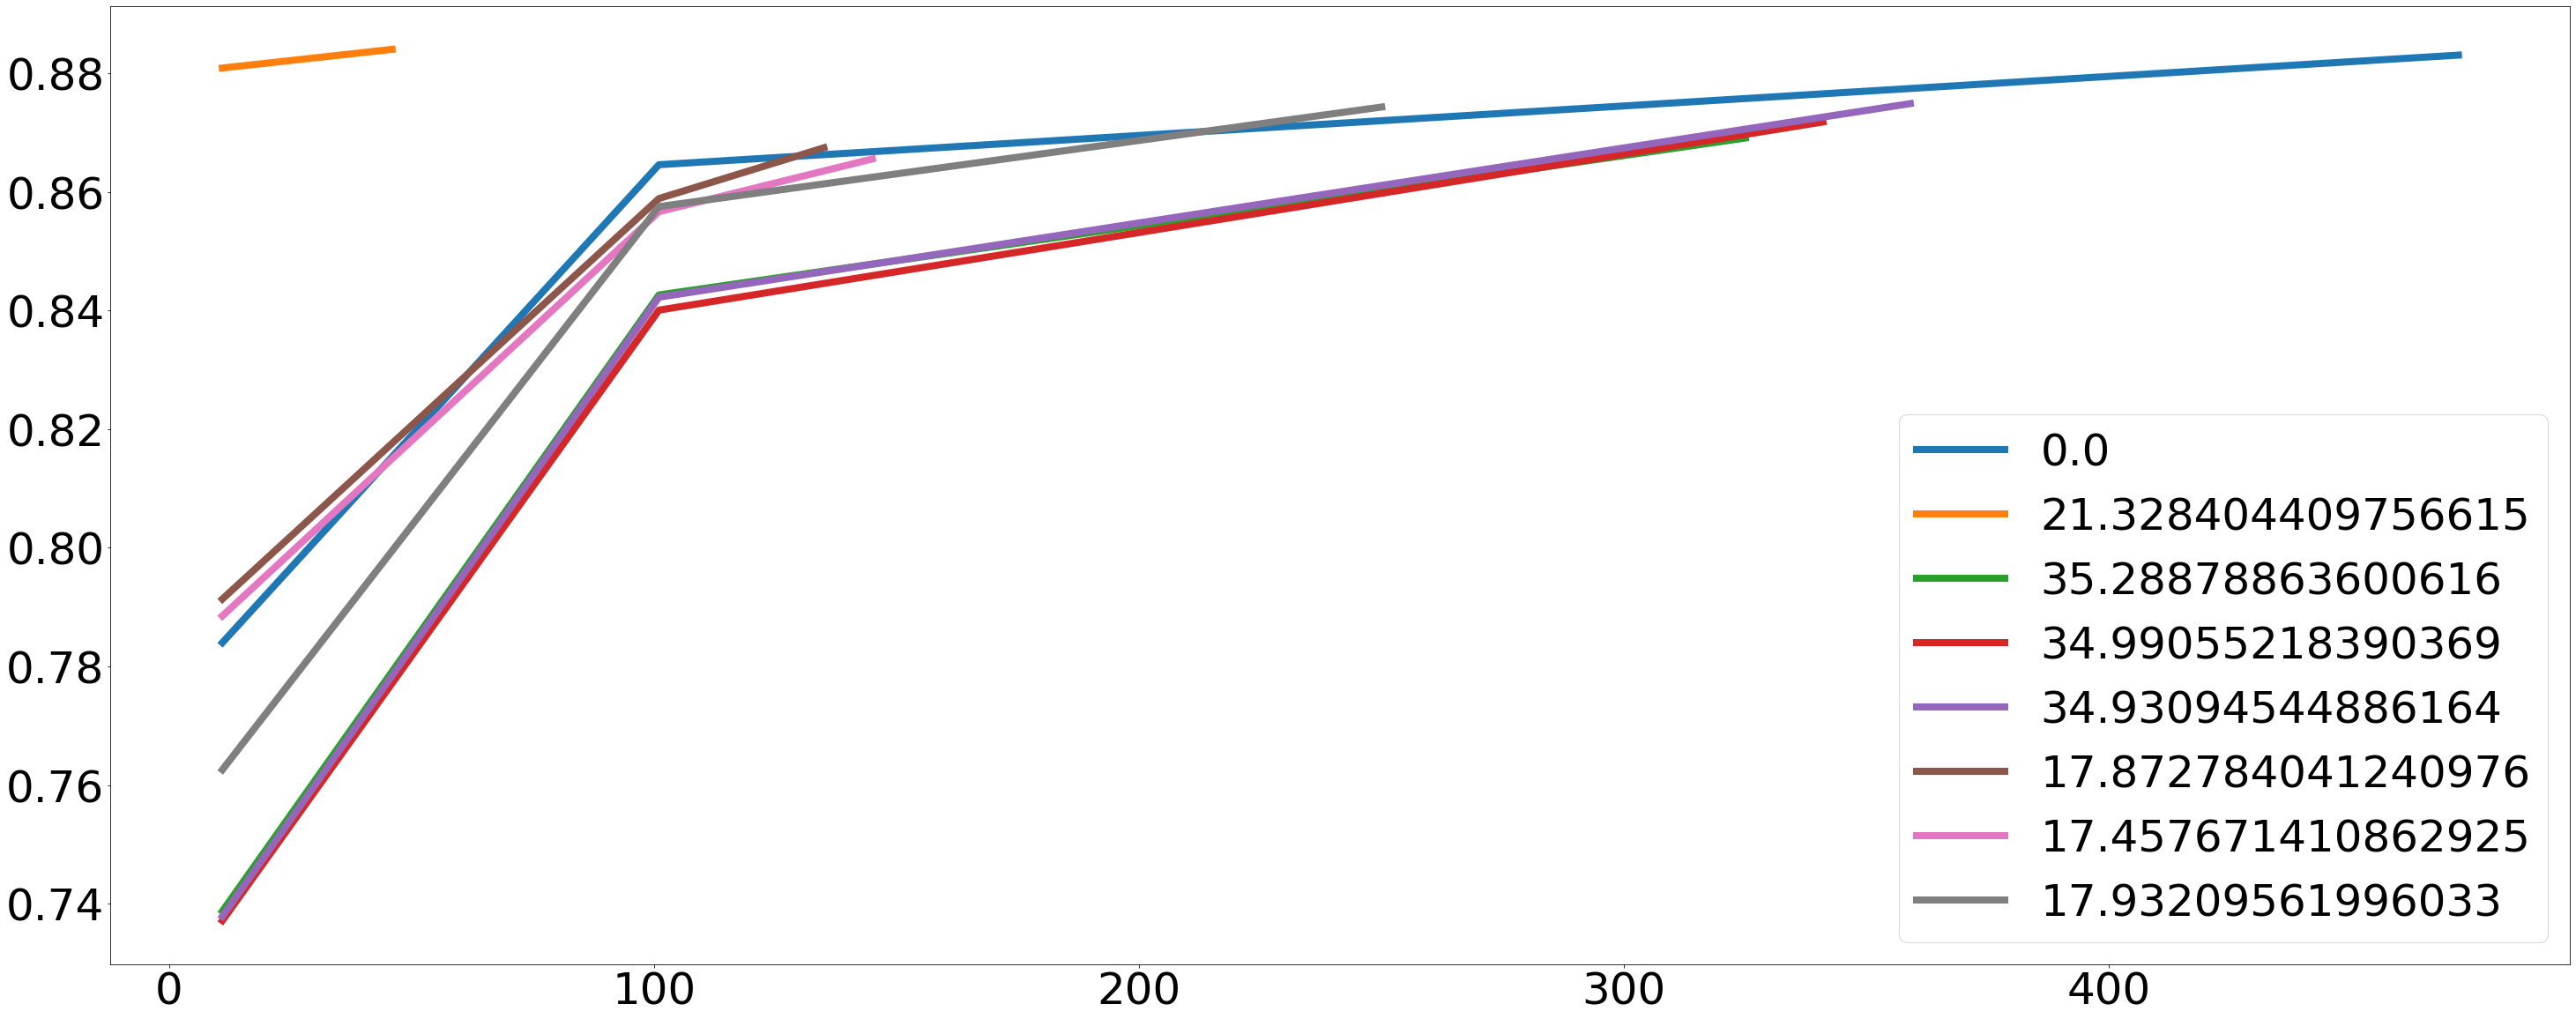

In [0]:
fig = plt.figure(figsize=(50, 20))
for i in range(len(iter_lst)):
        plt.plot(iter_lst[i], accuracy[i], lw = 8, label=norm(weights[i]))
        plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)
plt.show()

Итог: стохастически градиентный спуск меньше зависит от выбора начального прилижения: из любой точки сходимость достаточно быстрая

**Выводы**

Сравним два метода между собой на основе графиков выше.  
1. В зависимости от batch_size стохастический градиентный метод можт работать как быстрее обычного, так и сильно медленнее. Оптимальный batch_size для этой задачи ~ 1024.
2. Сходимость разности значения функционалов в случае стохастического спуска быстрее: всегда было ~ 300-500 эпох. В то время как в обычном градиентном спуске требовалось для многих параметров 1000 - 4000 итераций. Кроме того, сходимость из случайного начального приближения тоже лучше у стохастического градиентного спуска.
3. За счёт более случайного выбора направления стохастический градиентный спуск достиг более оптимального значения функционала и лучшей accuracy: 0.89 против 0.86  
Недостатки SGD:  
1. Если взять неправильный batch_size, то у меня время fit-а становится очень большим, а значение функционала (при маленьких batch_size) очень прыгает, что замедляет сходимость. Т.е. надо быть внимательным с batch_size.
2. В случае SGD сходимость намного менее монотонная.
SGD работает у меня чуть дольше: 12 секунд против 10 секунд, но достигает лучшей оптимизации функционала и лучшей accuracy.

Тестирую на реальном датасете, используя Bag of Words и TF-IDF по отдельности.

In [23]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy.sparse
import time
import matplotlib
%matplotlib inline

df = pd.read_csv("toxic_train.csv")
df = df[['Unnamed: 0', 'comment_text', 'is_toxic']]
df.columns = ['id', 'text', 'is_toxic']
df.loc[:, 'is_toxic'] = (df.loc[:, 'is_toxic'].astype('int') - 0.5) * 2
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: x.lower())
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: re.sub('[^а-яёa-z0-9]', ' ', x))
df.head()

id                                               text  is_toxic
0   0  explanation why the edits made under my userna...      -1.0
1   1  d aww  he matches this background colour i m s...      -1.0
2   2  hey man  i m really not trying to edit war  it...      -1.0
3   3    more i can t make any real suggestions on im...      -1.0
4   4  you  sir  are my hero  any chance you remember...      -1.0

In [24]:
df_test = pd.read_csv("toxic_test.csv")
df_test.head()

df_test = df_test[['Unnamed: 0', 'comment_text', 'is_toxic']]
df_test.columns = ['id', 'text', 'is_toxic']
df_test.loc[:, 'is_toxic'] = (df_test.loc[:, 'is_toxic'].astype('int') - 0.5) * 2
df_test.loc[:, 'text'] = df_test.loc[:, 'text'].apply(lambda x: x.lower())
df_test.loc[:, 'text'] = df_test.loc[:, 'text'].apply(lambda x: re.sub('[^а-яёa-z0-9]', ' ', x))
df_test.head()

id                                               text  is_toxic
0   0  thank you for understanding  i think very high...      -1.0
1   1                    dear god this site is horrible       -1.0
2   2       somebody will invariably try to add relig...      -1.0
3   3       it says it right there that it is a type ...      -1.0
4   4          before adding a new product to the lis...      -1.0

In [0]:
vectorizer = CountVectorizer()
tf_idf = TfidfVectorizer()

In [0]:
y_train = df.loc[:, 'is_toxic'].values
y_test = df_test.loc[:, 'is_toxic'].values

In [27]:
min_dfs = [1, 0.0001, 0.0005, 0.001, 0.005, 0.01]
max_dfs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
maxmin = []
for i in range(len(max_dfs)):
    for j in range(i+1):
        maxmin.append((min_dfs[j], max_dfs[i]))
maxmin = maxmin + [(i, 1.0) for i in max_dfs]
maxmin.append((1, 1.0))
maxmin_str = [str(i[1]) + '\n' +  str(i[0]) for i in maxmin]
maxmin_str

['0.0001\n1',
 '0.0005\n1',
 '0.0005\n0.0001',
 '0.001\n1',
 '0.001\n0.0001',
 '0.001\n0.0005',
 '0.005\n1',
 '0.005\n0.0001',
 '0.005\n0.0005',
 '0.005\n0.001',
 '0.01\n1',
 '0.01\n0.0001',
 '0.01\n0.0005',
 '0.01\n0.001',
 '0.01\n0.005',
 '1.0\n0.0001',
 '1.0\n0.0005',
 '1.0\n0.001',
 '1.0\n0.005',
 '1.0\n0.01',
 '1.0\n1']

TF-IDF

In [28]:
sizes = []
time_lst = []
accuracy_lst = []
for k in maxmin:
    tf_idf = TfidfVectorizer(min_df=k[0], max_df=k[1])
    X_train = tf_idf.fit_transform(df.loc[:, 'text'])
    X_train = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_train, np.ones((X_train.shape[0], 1)))))
    sizes.append(X_train[1])
    X_test = tf_idf.transform(df_test.loc[:, 'text'])
    X_test = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_test, np.ones((X_test.shape[0], 1)))))
    
    oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    start = time.monotonic()
    res = oracle.fit(X_train, y_train, trace=True)
    finish = time.monotonic()
    time_lst.append(finish - start)
    pred = oracle.predict(X_test)
    score = (pred == y_test).sum() / y_test.shape[0]
    accuracy_lst.append(score)
    print(k, X_train.shape, finish - start, score)

(1, 0.0001) (52061, 73609) 0.16627371499998844 0.6980557167730702
(1, 0.0005) (52061, 83729) 4.32153484499986 0.6980557167730702
(0.0001, 0.0005) (52061, 10121) 12.372780692000106 0.6996034049139098
(1, 0.001) (52061, 85923) 16.268223663999834 0.6998935964403172
(0.0001, 0.001) (52061, 12315) 20.569496937000167 0.7226736312633004
(0.0005, 0.001) (52061, 2195) 6.768891130000156 0.715273747339911
(1, 0.005) (52061, 88630) 36.19469649599978 0.7866124975817372
(0.0001, 0.005) (52061, 15022) 24.712798779999957 0.7927548848906946
(0.0005, 0.005) (52061, 4902) 14.791796186000283 0.7964306442251886
(0.001, 0.005) (52061, 2708) 14.06928541599973 0.7916908492938672
(1, 0.01) (52061, 89091) 39.82057593300033 0.812342812923196
(0.0001, 0.01) (52061, 15483) 27.008294019999994 0.8159218417488876
(0.0005, 0.01) (52061, 5363) 16.66607599100007 0.8188237570129618
(0.001, 0.01) (52061, 3169) 15.976718003000315 0.816212033275295
(0.005, 0.01) (52061, 462) 7.567371621999882 0.7558521957825498
(0.0001, 1.0

BagOfWords

In [0]:
bow_time = []
bow_accuracy = []
bow_sizes = []
for k in maxmin:
    tf_idf = CountVectorizer(min_df=k[0], max_df=k[1])
    X_train = tf_idf.fit_transform(df.loc[:, 'text'])
    X_train = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_train, np.ones((X_train.shape[0], 1)))))
    bow_sizes.append(X_train[1])
    X_test = tf_idf.transform(df_test.loc[:, 'text'])
    X_test = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_test, np.ones((X_test.shape[0], 1)))))
    
    oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                 tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
    start = time.monotonic()
    res = oracle.fit(X_train, y_train, trace=True)
    finish = time.monotonic()
    bow_time.append(finish - start)
    pred = oracle.predict(X_test)
    score = (pred == y_test).sum() / y_test.shape[0]
    bow_accuracy.append(score)
    print(k, X_train.shape, finish - start, score)

(1, 0.0001) (52061, 73609) 10.02333112800261 0.6990713871154962
(1, 0.0005) (52061, 83729) 11.686940533982124 0.7123234668214354
(0.0001, 0.0005) (52061, 10121) 5.011806210008217 0.704488295608435
(1, 0.001) (52061, 85923) 4.6854906679946 0.7129038498742504
(0.0001, 0.001) (52061, 12315) 2.5100112989894114 0.7074385761269104
(0.0005, 0.001) (52061, 2195) 2.2960662429977674 0.7072934803637068
(1, 0.005) (52061, 88630) 6.037335652014008 0.7884987425033856
(0.0001, 0.005) (52061, 15022) 4.83291421199101 0.7882569162313794
(0.0005, 0.005) (52061, 4902) 8.1699196069967 0.7923679628554846
(0.001, 0.005) (52061, 2708) 7.083671967004193 0.785355000967305
(1, 0.01) (52061, 89091) 27.427311358012957 0.8203714451538016
(0.0001, 0.01) (52061, 15483) 18.267513009981485 0.819259044302573
(0.0005, 0.01) (52061, 5363) 4.396242830000119 0.8110853163087638
(0.001, 0.01) (52061, 3169) 9.892225160991075 0.8114238730895724
(0.005, 0.01) (52061, 462) 3.822587470000144 0.7499516347455988
(0.0001, 1.0) (52061

График, показывающий зависимость Accuracy от min_df и max_df в случае TF-IDF и BafOfWords.  
Нижний ряд по оси x соответствует параметру min_df.  
Верхний ряд по оси x соответсвует параметру max_df.
Из графика видно, что с увеличением max_df увеличивается и точность, поэтому убирать часто встречающиеся слова точно не надо.

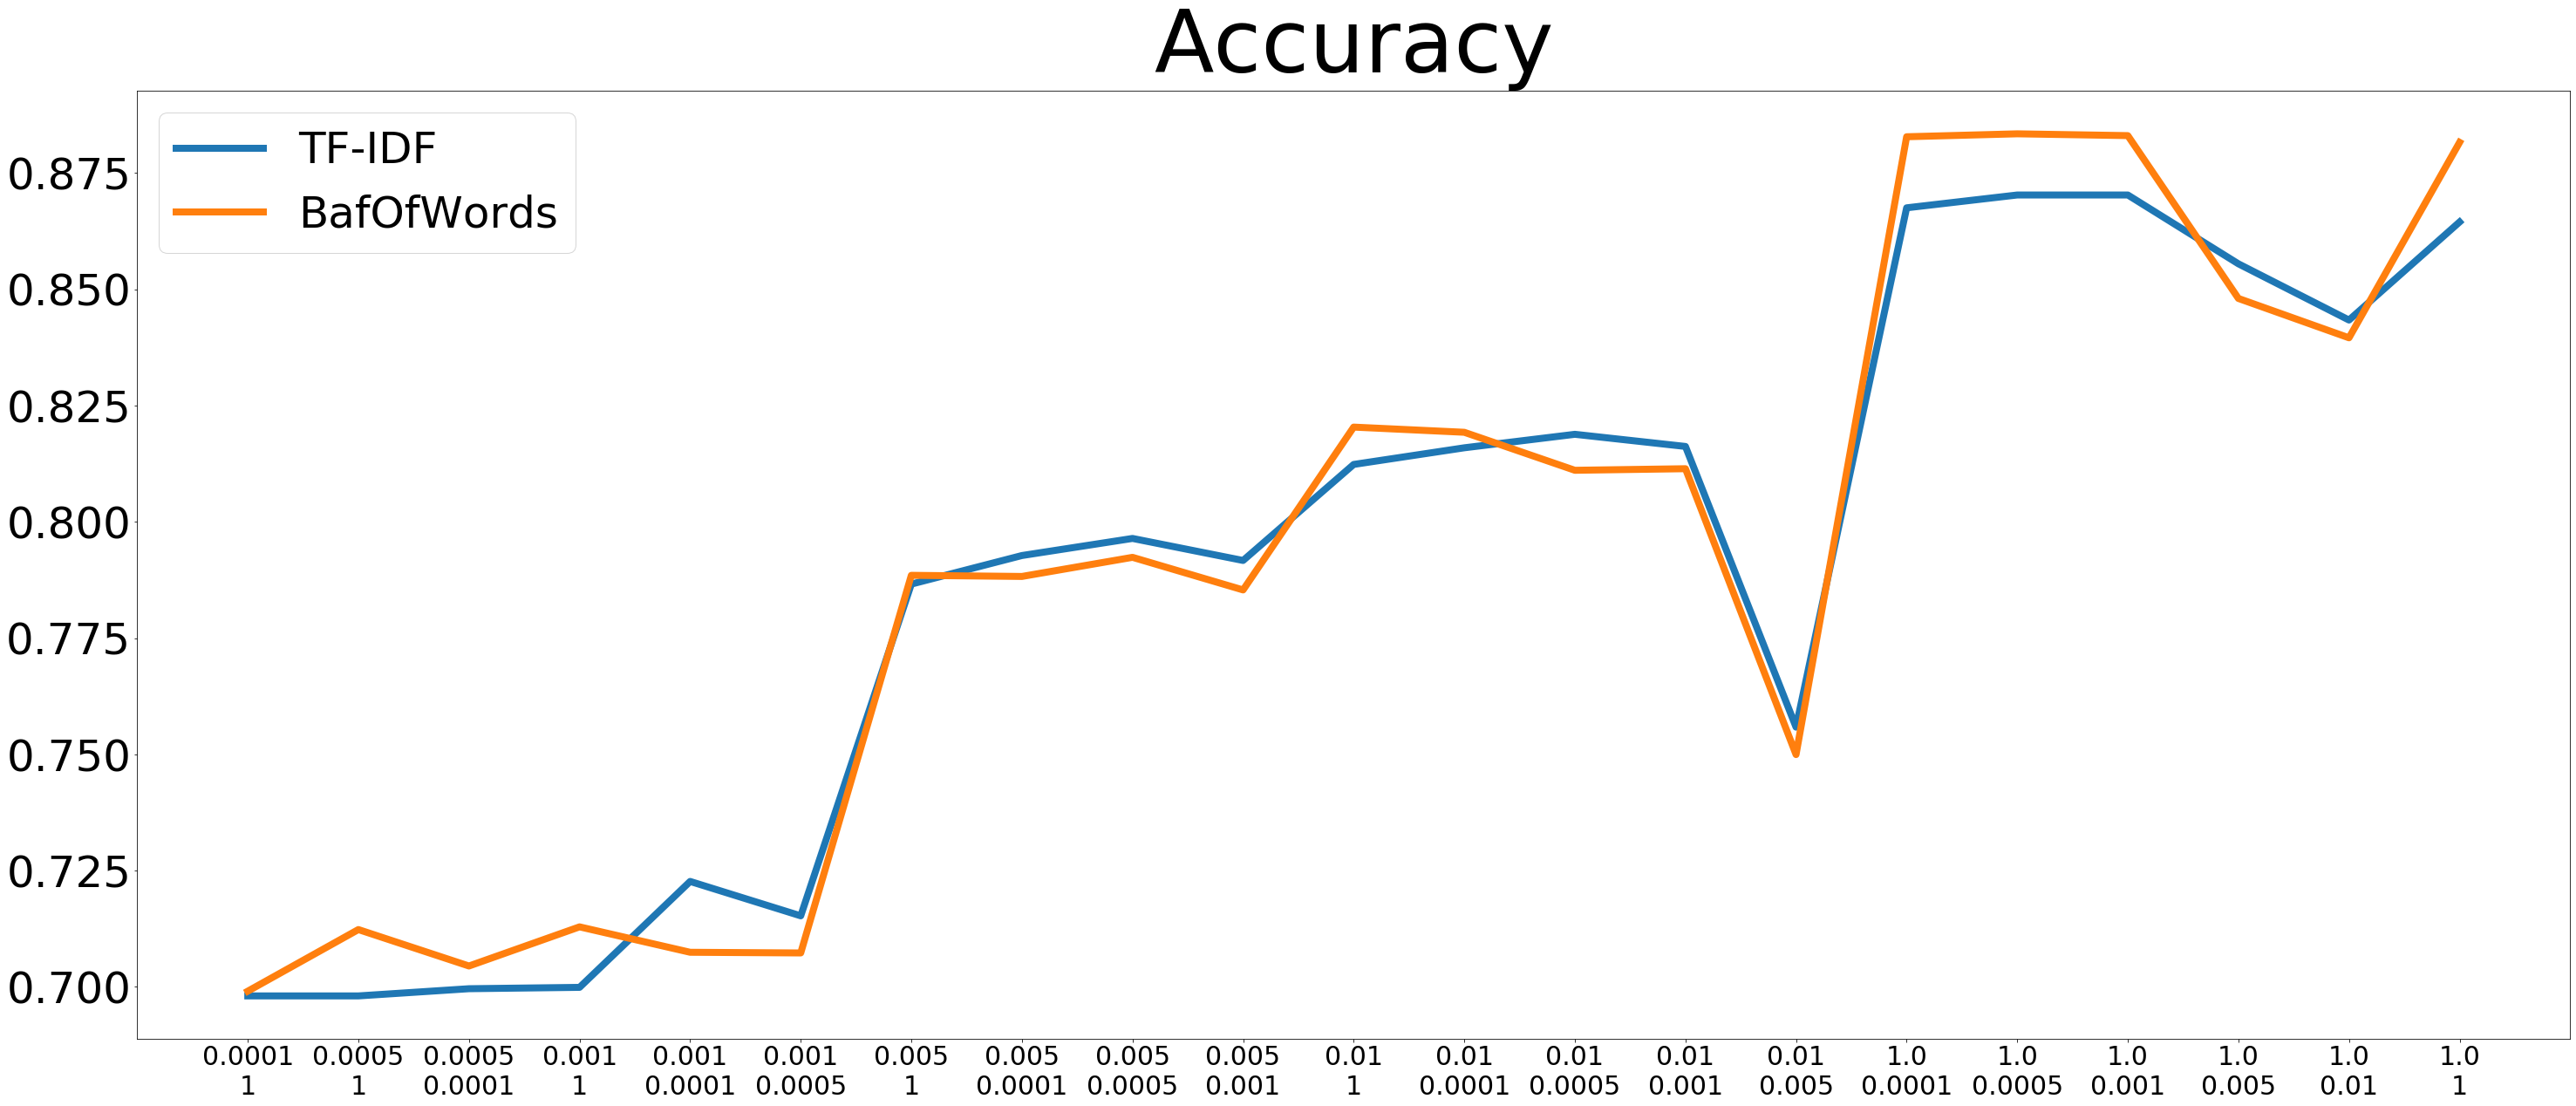

In [0]:
fig = plt.figure(figsize=(50, 20))
plt.plot(maxmin_str, accuracy_lst, lw = 8, label='TF-IDF')
plt.plot(maxmin_str, bow_accuracy, lw = 8, label='BafOfWords')
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_yticklabels()):
    item.set_fontsize(50)
for item in ax.get_xticklabels():
    item.set_fontsize(30)
plt.title('Accuracy', fontsize=100)
plt.show()

In [0]:
BagOfWords даёт наибольшую точность и почти для всех размеров признакового пространства не хуже TF-IDF.

График, показывающий зависимость времени обучения (fit-а) от min_df и max_df в случае TF-IDF и BafOfWords.

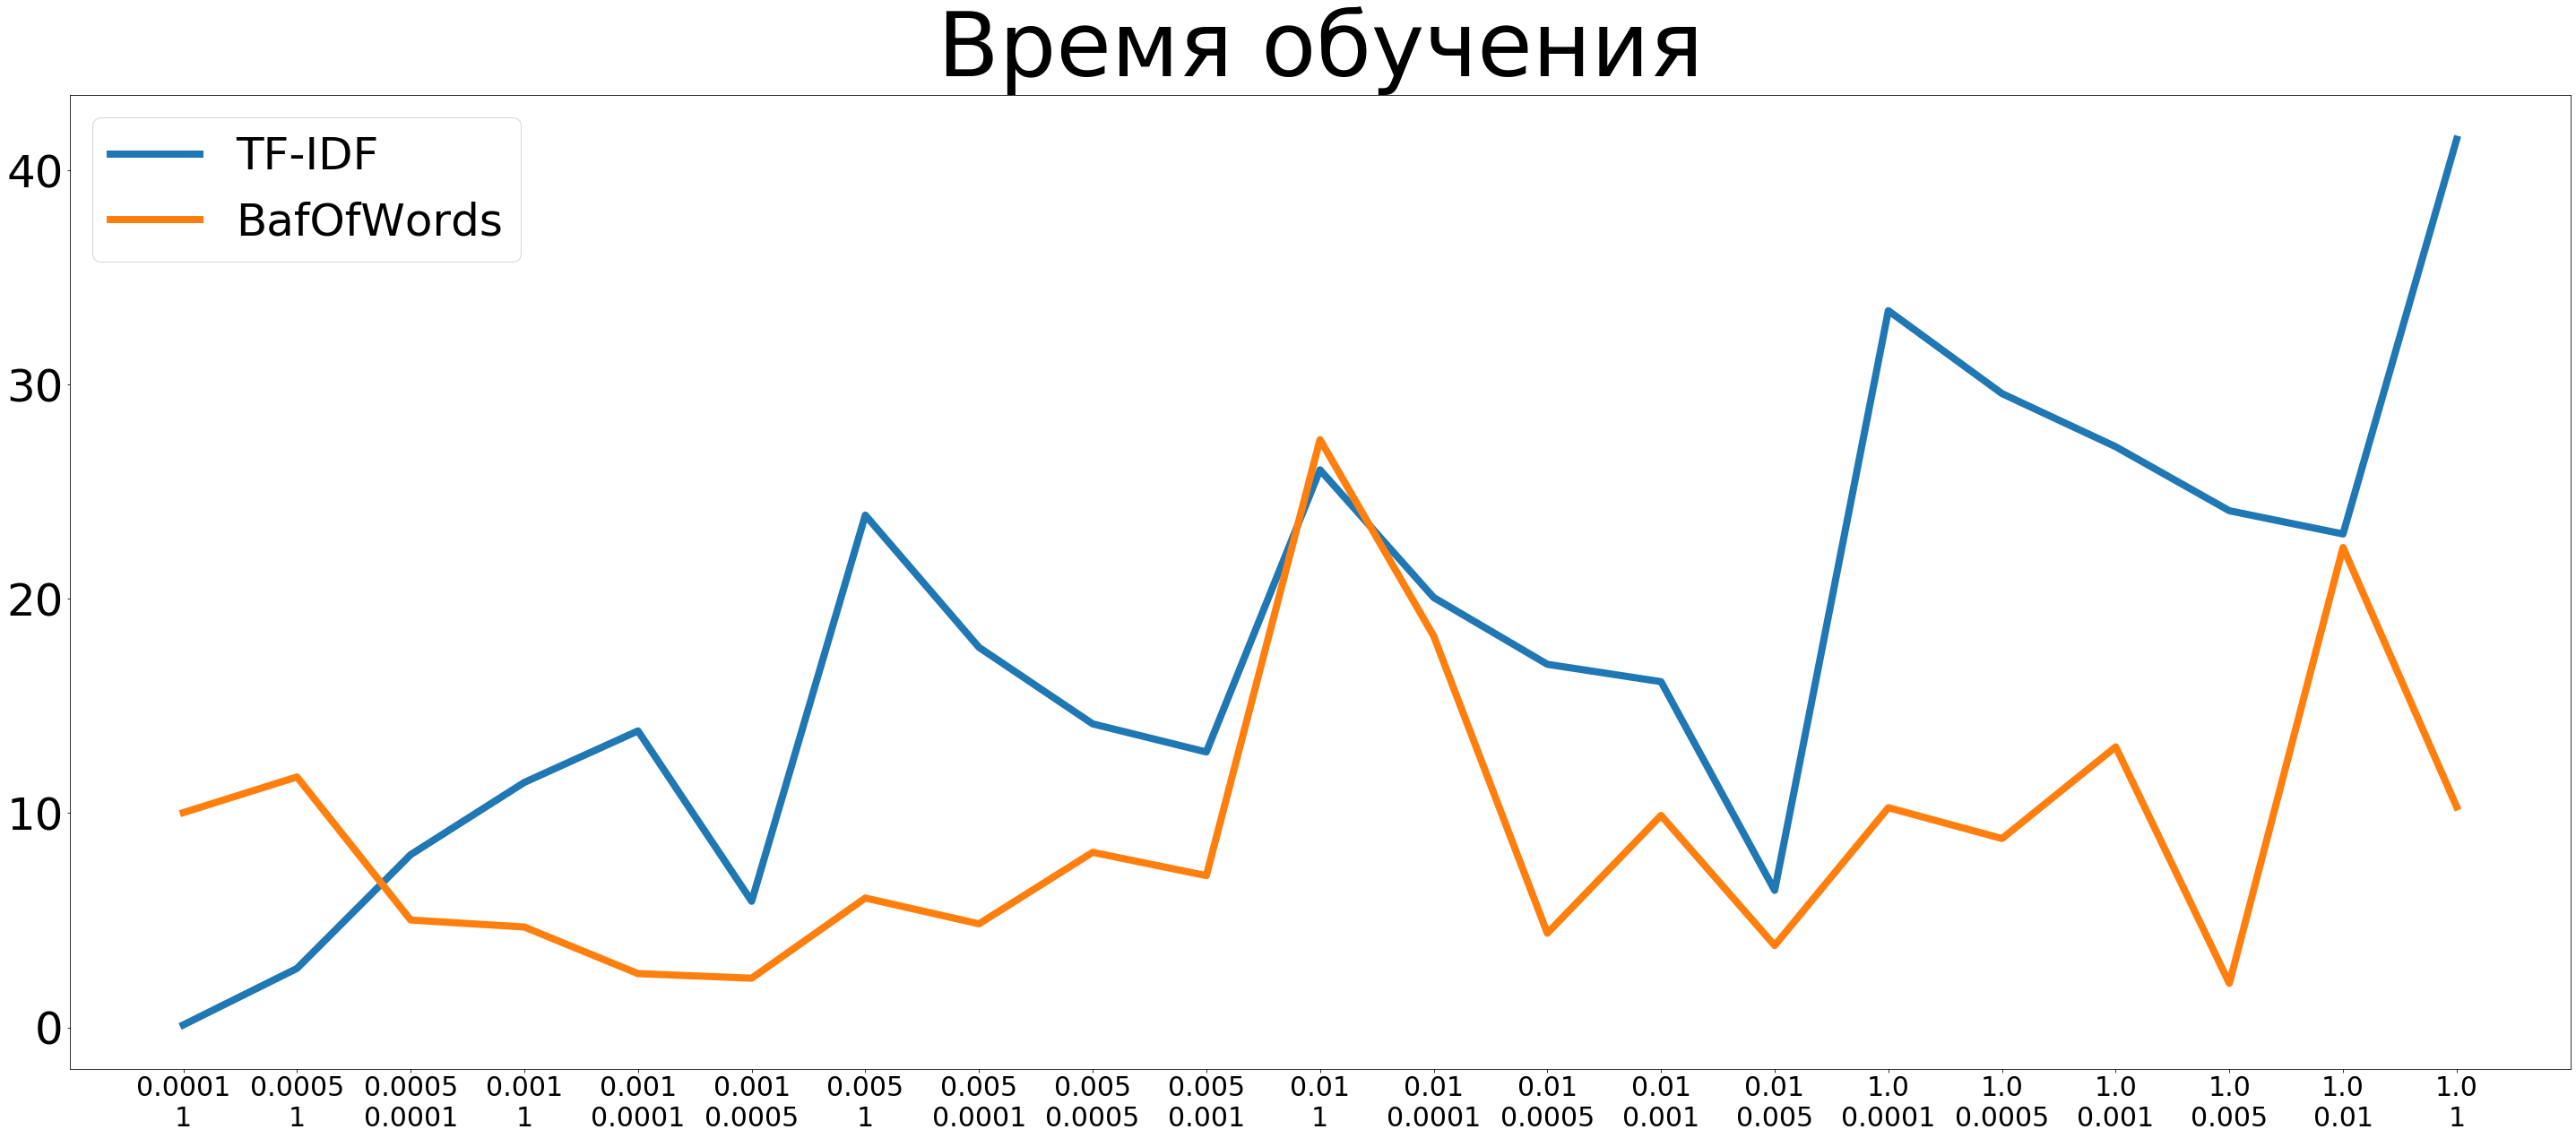

In [0]:
fig = plt.figure(figsize=(50, 20))
plt.plot(maxmin_str, time_lst, lw = 8, label='TF-IDF')
plt.plot(maxmin_str, bow_time, lw = 8, label='BafOfWords')
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_yticklabels()):
    item.set_fontsize(50)
for item in ax.get_xticklabels():
    item.set_fontsize(30)
plt.title('Время обучения', fontsize=100)
plt.show()

При BafOfWords обучение заметно ускоряется.

Размер признакового пространтсва в зависимости от min_df и max_df в случае TF-IDF и BafOfWords (на оси y - доля слов вошедших в признаки от всех слов в первоначальной выборке.

In [0]:
sizes_scale = [(i.shape[1] / 89659) * 100 for i in bow_sizes]
bow_sizes_scale = [(i.shape[1] / 89659) * 100 for i in bow_sizes]

Понятно, что механика min_df и max_df совпадает для TF-IDF и BagOfWords, поэтому графики размеров признаковых пространств наложились друг на друга. Если сравнить этот график с графиком точности, то видно, что на точность оказывает намного больший эффект выкидываем ли мы часто встречающиеся слова или нет, а не размер признакового пространства.  
Наибольшая accuracy достигается при количестве признаков в 5%-10% от всех слов в первоначальном тексте. 

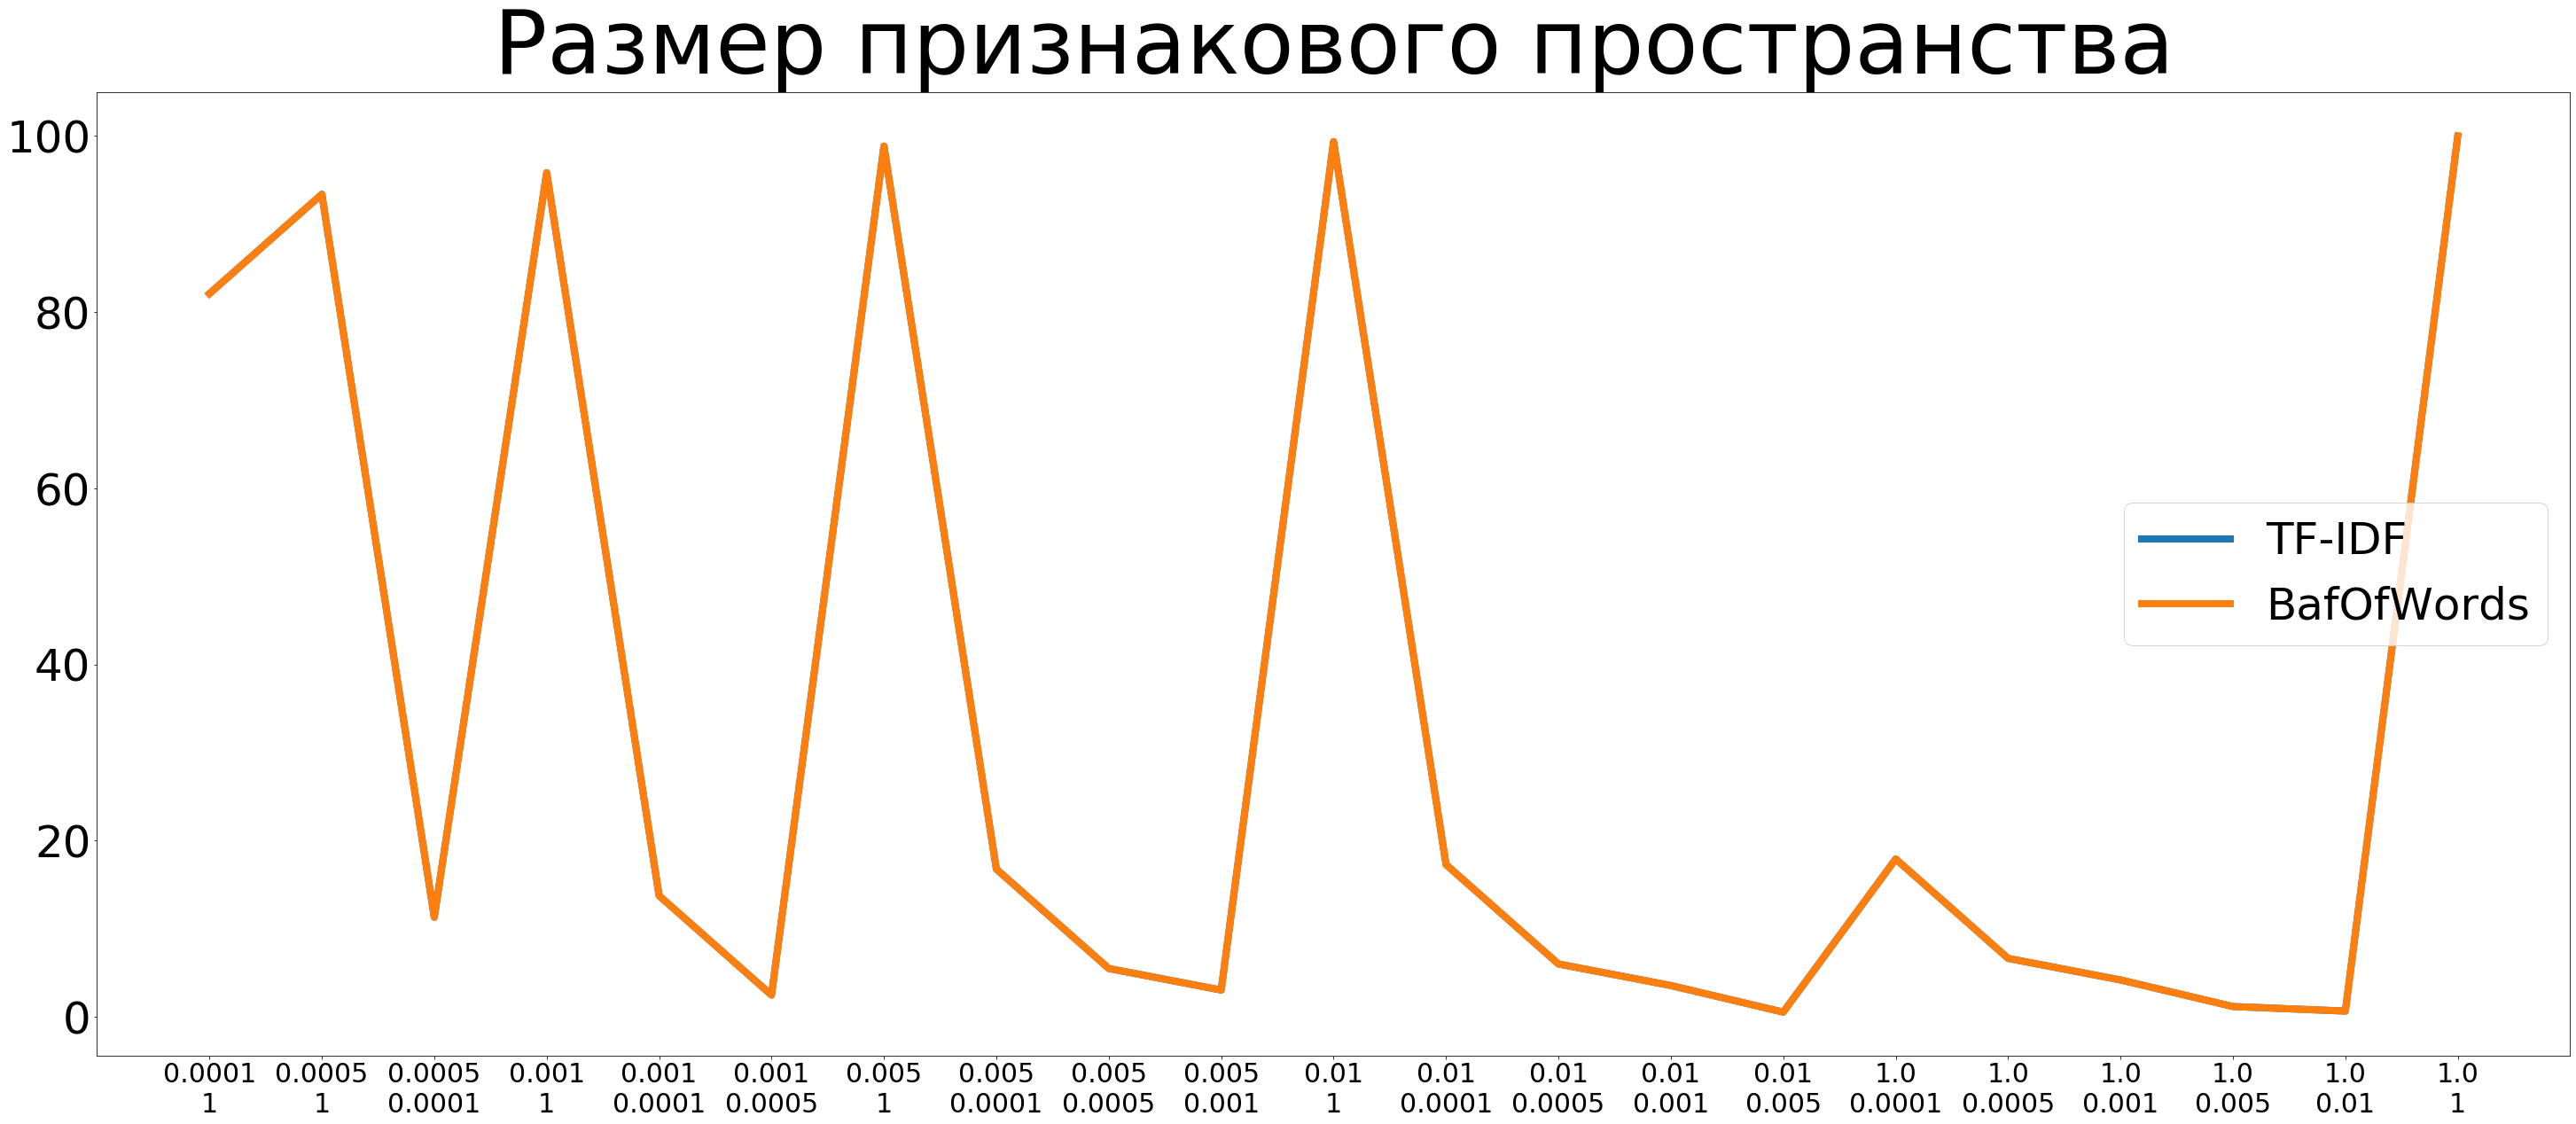

In [0]:
fig = plt.figure(figsize=(50, 20))
plt.plot(maxmin_str, sizes_scale, lw = 8, label='TF-IDF')
plt.plot(maxmin_str, bow_sizes_scale, lw = 8, label='BafOfWords')
plt.legend(fontsize=50)
ax = fig.axes[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_yticklabels()):
    item.set_fontsize(50)
for item in ax.get_xticklabels():
    item.set_fontsize(30)
plt.title('Размер признакового пространства', fontsize=100)
plt.show()

Лучший алгоритм

In [0]:
countvectorizer = CountVectorizer(min_df=0.0005, max_df=1.0)
X_train = countvectorizer.fit_transform(df.loc[:, 'text'])
X_train = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_train, np.ones((X_train.shape[0], 1)))))
bow_sizes.append(X_train[1])
X_test = countvectorizer.transform(df_test.loc[:, 'text'])
X_test = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_test, np.ones((X_test.shape[0], 1)))))
    
oracle = SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, 
                tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)
start = time.monotonic()
res = oracle.fit(X_train, y_train, trace=True)
finish = time.monotonic()
pred = oracle.predict(X_test)
score = (pred == y_test).sum() / y_test.shape[0]
print('BagOfWords')
print("SGDClassifier(batch_size=8192, step_alpha=1.0, step_beta=0.0, tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)")
print()
print('min_df: ' + str(0.0005), 'max_df: ' + str(1.0))
print('Размер признакового пространства: ' + str(X_train.shape) + ' - всего 7% слов характеризуют тексты для такой точноти')
print('Время обучения: ' + str(finish - start))
print('Accuracy: ' + str(score))

BagOfWords
SGDClassifier(loss_function='binary_logistic', batch_size=8192, step_alpha=1.0, step_beta=0.0, tolerance=1e-5, max_iter=1000, random_seed=3153, l_2_coef=0.0)

min_df: 0.0005 max_df: 1.0
Размер признакового пространства: (52061, 5931) - всего 7% слов характеризуют тексты для такой точноти
Время обучения: 9.280264077999163
Accuracy: 0.883439736893016


In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [0]:
right = (pred == y_test)
right

array([ True, False, False, ..., False, False,  True])

In [0]:
proba = oracle.predict_proba(X_test)

In [0]:
df_res = df_test
df_res.shape

(20676, 6)

In [0]:
df_res['prediction'] = pd.Series(pred)
df_res[['probability-1', 'probability+1']] = pd.DataFrame(proba)

In [0]:
mistakes = df_res.loc[~right, :]
mistakes.shape

(2410, 6)

In [0]:
shuffle_mistakes = mistakes.sample(frac=1)

Выборка из 30-ти случайных ошибок

In [0]:
mistakes.prediction.mean()

-0.10290456431535269

In [0]:
mistakes.prediction.sum()

-248.0

In [0]:
shuffle_mistakes.head(30)

id  \
700    700     
19740  54162   
20238  59428   
20399  61160   
20666  63782   
18478  41500   
10230  10230   
8531   8531    
9155   9155    
16888  25667   
9820   9820    
9319   9319    
6982   6982    
12830  12830   
19036  47198   
16902  25832   
17917  35743   
16960  26359   
19444  51092   
15915  15915   
17437  31133   
17308  29852   
17465  31391   
15864  15864   
11413  11413   
5533   5533    
1859   1859    
17495  31692   
16535  21943   
4610   4610    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
700    ech  you silly mensans  you have iq points to spare                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
19740  megan gosse is a poop                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
20238     what 

Выводы

1. Алгоритм допускает ошибку "считает не токсичное токсичным" чуть чаще (на 248 случаев чаще при ~2400 ошибках всего)
2. Алгоритм часто ошибается на длинных комментариях, причём выдавая на них очень большую уверенность близкую к 100%.
3. Алгоритм не распознаёт сарказм из-за этого многие негативные комментарии попадают в положительные. Например, "thanks thanks for blocking that guy what a dick".
4. Так как он используют BagOfWords его вообще путают добрые слова ("good", "thank", "alright"), в негативных комментариях.
5. Алгоритм ошибается на более длинных высказываниях-утверждениях, где только пара слов показывают негативный окрас, но, видимо, они теряются среди большого числа остальных слов.
6. При необходимости можно продолжить анализ ошибок:
    а) разделить комментарии на длинные и не длинные, с каждым блоком работать отдельно или как-то порезать тексты
    б) можно посмотреть степень уверенности на правдивых ответах и на неправдивых. Например, среднегармоническое  	probability-1 и probability+1, возможно введение treshold-а поможет отсеять неоднозначные комментарии
    в) попробовать нормалтзовать данные перед обучением